In [1]:
# Reset workspace

%reset -f

# Animal Group and Number

In [2]:
group_number: int = 5
rat_number: int = 1

# **Importing Libraries**

In [3]:
# Importing Python modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import hilbert
from time import perf_counter, strftime, gmtime, sleep
import plotly.figure_factory as ff
from copy import deepcopy
import plotly.express as px
from loguru import logger
import os
import mat73
from scipy.io import savemat, loadmat
from high_order_spectra_analysis.time_domain_trispectrum.tdts import tdts
from pathos.multiprocessing import ProcessingPool as Pool
from bispectrum_real_data_analysis.scripts.utils import seconds_to_formatted_time
import plotly.express as px
from plotly.subplots import make_subplots
from bispectrum_real_data_analysis.scripts.utils import standardize_array
import pendulum
from scipy import stats as st
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import plotly.graph_objects as go
from scipy import stats
from high_order_spectra_analysis.hosa.hosa import Tdhosa
import seaborn as sns

import matplotlib 
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 
fontsize = 30
plt.rcParams.update({'font.size': fontsize})

%matplotlib inline

In [4]:
fontsize = 30
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize-10) 
plt.rcParams.update({'font.size': fontsize})

plt.subplots_adjust(left=None, bottom=4, right=None, top=5, wspace=5, hspace=5)


<Figure size 640x480 with 0 Axes>

# Methods

In [5]:
# Método que calcula a FFT unilateral e retorna um plot,
# o vetor de frequências em Hertz e os ganhos
def fft(x, fs):
    N = len(x)
    FFT = np.fft.fft(x)
    P2 = np.abs(FFT/N)
    intensity = P2[0:N//2]
    intensity[1:-1] = 2*intensity[1:-1]
    frequency = fs*np.arange(0,N//2)/N
    angle = np.angle(FFT)
    angle = angle[0:N//2]
    return frequency, intensity, angle

In [6]:
def get_exact_value_between_two_points(x, y, x0):
    if len(x) != len(y):
        raise IndexError("The arrays x and y must have the same size.")
    
    two_points_x = [x[x<=x0][-1], x[x>=x0][0]]
    two_points_y = [y[x<=x0][-1], y[x>=x0][0]]
    
    f = scipy.interpolate.interp1d(two_points_x, two_points_y)
    return f(x0)

In [7]:
def intensity_fft_at_frequency(data, f0, fs):
    frequency, intensity, angle = fft(data, fs)
    return get_exact_value_between_two_points(x=frequency, y=np.power(intensity, 2), x0=f0)

In [8]:
def calculate_signal_energy(
    signal: np.ndarray,
    fs: float,
    central_frequency = 53.71,
    range_neighbors = 0.5,
    step_neighbors = 0.1
) -> np.ndarray:
    
        
    # Hz
    lateral_frequencies_steps = np.arange(0, range_neighbors+step_neighbors, step_neighbors)
    
    frequencies_array = np.hstack(
        [
            -lateral_frequencies_steps[::-1]+central_frequency, 
            (lateral_frequencies_steps+central_frequency)[1:]
        ]
    ) 
    
    energies = np.vectorize(intensity_fft_at_frequency, excluded={"data", "fs"})(
        data=signal,
        f0=frequencies_array,
        fs=fs
    )
        
    return energies

In [9]:
# Method to extract events from dataframe

def select_event_window(
    df: pd.DataFrame, 
    event_name: str, 
    samples_before: int = 0, 
    samples_after: int = 0
) -> pd.DataFrame:
    """
    Method to extract the slice of the dataframe which contais the event, with some data before and after, 
    given number of samples to add to the begin and end, respectively.
    """

    window_index = np.argwhere(df.event.to_numpy() == event_name).flatten()
    begin_index = window_index[0] - samples_before
    end_index = window_index[-1] + samples_after
    return df[begin_index:end_index]

In [10]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

In [11]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, filtfilt=False):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    if filtfilt:
        return signal.filtfilt(b, a, data)
    return signal.lfilter(b, a, data)

In [12]:
def decimate(data: pd.DataFrame, desired_frequency_sampling: float, filter: bool = False, time=None):
    if time is None:
        time = data.Time.to_numpy()
    TimeSampling = round(np.mean(time[1:] - time[:-1]), 6)
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The time sampling is {TimeSampling} seconds and the frequency is "
        f"{FrequencySampling/float(1000**(FrequencySampling<=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")

    newTimeSampling = 1.0/desired_frequency_sampling
    decimation_rate = np.ceil(newTimeSampling/TimeSampling).astype(int)
    logger.info(f"The data will be decimated by the rate 1:{decimation_rate}")

    if filter:
        matrix = data.iloc[:, 1:-2].to_numpy()
        decimated_matrix = signal.decimate(matrix, decimation_rate, axis=0, ftype='fir', zero_phase=True)
        new_data = data.copy()[::decimation_rate]
        new_data.iloc[:, 1:-2] = decimated_matrix
    else:
        new_data = data[::decimation_rate]

    TimeSampling = TimeSampling*decimation_rate
    
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The new time sampling is {np.round(TimeSampling, 5)} s and the new frequency is "
    f"{FrequencySampling/float(1000**(FrequencySampling>=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")
    
    return new_data, TimeSampling, FrequencySampling

In [13]:
def sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
):


    # Mean synchronization using sliding window with 90% time overlap
    step = int(0.1*(sliding_window_size/TimeSampling))
    ic_number = 1
    number_of_windows_overlap = int((window_size/TimeSampling)//step)
    start_window = np.arange(0, len(ic_data_complete), step).astype(int)
    end_window = (start_window + int(sliding_window_size/TimeSampling)).astype(int)
    end_window[-1] = len(ic_data_complete) - 1

    clustering_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)
    mean_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)


    for i in range(number_of_windows_overlap):
        event_time_window = event_time[start_window[i]:end_window[i]]
        ic_data = ic_data_complete[start_window[i]:end_window[i]]
        phase_data_CS_event = phase_data_CS[start_window[i]:end_window[i]]
        analytic_signal_ic = hilbert(ic_data)
        phase_data_ic = np.unwrap(np.angle(analytic_signal_ic))
        phase_angle_diff = phase_data_CS_event - phase_data_ic
        euler_phase_diff = np.exp(1j*phase_angle_diff)
        mean_phase_diff = np.mean(euler_phase_diff)
        phase_sync = np.abs(mean_phase_diff)
        clustering_phase_array[i] = phase_sync
        mean_phase_array[i] = np.angle(mean_phase_diff)

    mean_phase_sync = clustering_phase_array.mean()
    mean_phase_angle = np.angle(np.mean(np.exp(1j*mean_phase_array)))
    ax = PolarPlotPhasors.plot_array_angles(mean_phase_array, color=None, linewidth=0.5)
    ax = PolarPlotPhasors.add_vector_polar(ax, angle=mean_phase_angle, module=mean_phase_sync, linewidth=10, color='red')
    ax.set_xlabel(f"\nphase clustering: {np.round(mean_phase_sync, 4)}", fontsize=16)
    plt.show()

In [14]:
def get_spectogram(x: np.ndarray, fs: float, nfft=None, nperseg=None, noverlap=None):
    f, t, Sxx = signal.spectrogram(x, fs, nfft=nfft, nperseg=nperseg, noverlap=noverlap)
    return f, t, Sxx    

In [15]:
def plot_spectogram(
    t, 
    f, 
    Sxx, 
    ylim: list = None, 
    yticks: list = None, 
    cmap: str = 'hot', 
    title='Spectogram',
    save: bool = False,
    name_to_save: str = "fig.eps"
):
    
    plt.figure(figsize=(12,10))
    plt.title(title)
    plt.pcolormesh(t, f, Sxx, cmap=cmap)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if ylim is not None:
        plt.ylim(ylim)
    if yticks is not None:
        plt.yticks(yticks)
    if save:
        if name_to_save == "fig.eps" and os.path.isfile("fig.eps"):
            i = 2
            while os.path.isfile(name_to_save):
                name_to_save =  f"fig_{i}.eps"
                i += 1
        plt.savefig(name_to_save, format=name_to_save.split(".")[-1])
    plt.show()

In [16]:
def run_and_plot(
    event_data: pd.DataFrame, 
    fs: float, 
    ylim: list = None, 
    yticks: list = None, 
    cmap: str = 'hot', 
    title='Spectogram',
    save: bool = False,
    name_to_save: str = "fig.eps"
) -> None:

    """
    Method to plot the waveform and spectogram of the CS modullating signal paired with each channel at time.
    """
    for index_of_channel in range(1, event_data.shape[1]-1):
        
        name_of_channel = list(event_data.columns)[index_of_channel]

        logger.info(f"Channel {index_of_channel - 1}: {name_of_channel.replace('_', ' ')}")
        
        f, t, Sxx = get_spectogram(
            event_data[name_of_channel], 
            fs=fs, 
            nperseg=int(10*fs),
            noverlap=int(9*fs)
        )
        
        name_to_save = ".".join([f"{name_to_save.split('.')[0]}_{name_of_channel}", "eps"])
        
        plot_spectogram(
            t, 
            f, 
            Sxx, 
            ylim=ylim, 
            yticks=yticks, 
            cmap=cmap, 
            title=title, 
            save=save, 
            name_to_save=name_to_save
        )
        
        print("\n\n")

In [17]:
class TDTS:
    def __init__(
        self,
        frequency_sampling: float,
        time: np.ndarray | None = None,
        frequency_array: np.ndarray | None = None,
        fmin: float | None = None,
        fmax: float | None = None,
        freq_step: float = 1e-3,
        phase_step: float = 1e-3,
        dtype: np.dtype = np.float64,
        enable_progress_bar: bool = True
    ):
        self.frequency_sampling = frequency_sampling
        self.time = time
        self.frequency_array = frequency_array
        self.fmin = fmin
        self.fmax = fmax
        self.freq_step = freq_step
        self.phase_step = phase_step
        self.dtype = dtype
        self.enable_progress_bar = enable_progress_bar

    def run_tbds(self, signal_dict: np.ndarray | pd.Series): 
        event, signal = list(signal_dict.items())[0]
        return {
            event: tdts(
                signal, 
                self.frequency_sampling, 
                time=self.time, 
                frequency_array=self.frequency_array, 
                fmin=self.fmin, 
                fmax=self.fmax, 
                freq_step=self.freq_step, 
                phase_step=self.phase_step, 
                dtype=self.dtype, 
                enable_progress_bar=self.enable_progress_bar
            )
        }

In [18]:
def moving_average(x, N):
    return np.convolve(x, np.ones(N), 'same') / N

In [19]:
def get_events(data, threshold, window_size, time_sampling):
    
    x = data.CS_modulating.to_numpy()
    N = len(x)
    index = np.arange(N)
    plt.figure(figsize=(16,14))
    plt.subplot(321)
    plt.plot(index, x)
    plt.ylabel("x")

    x = x - np.mean(x[:10])
    plt.subplot(322)
    plt.plot(index, x)
    plt.ylabel("x - mean(x)")

    x = x**2
    plt.subplot(323)
    plt.plot(index, x)
    plt.ylabel("(x - mean(x))^2")

    x = moving_average(x, window_size)
    plt.subplot(324)
    plt.plot(index, x)
    plt.axhline(threshold, color="red", label="threshold")
    plt.legend()
    plt.ylabel("moving_average_10_(x - mean(x))^2")

    x[x>threshold] = 1
    x[x<threshold] = 0

    plt.subplot(325)
    plt.plot(index, x)
    plt.ylabel("threshold(moving_average_10_(x - mean(x))^2)")

    indices = index[np.append(False, x[1:] - x[:-1]) != 0]

    for event, s, e in zip(range(1, 6), indices[0::2], indices[1::2]):
        print(f"\nEvent: {event}")
        print(f"start: {s}\nend: {e}") 
        print(f"time duration: {(e-s)*time_sampling}")

    print(f"\nlen(indices) = {len(indices)}")

    data = data.assign(event=np.empty(len(data), dtype=str))
    data.loc[:, "event"] = "base"

    for i, event in zip(range(0, len(indices), 2), np.arange(1, 6)):
        start = indices[i]
        end = indices[i+1]
        data.loc[start:end, "event"] = f"event_{event}"

    data.event.unique()

    plt.subplot(326)
    for event in data.event.unique():
        plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)

    plt.ylabel("events")

    plt.show()
    return data

# Loading files

In [20]:
# Loading and creating the data matrix

BASE_PATH = "/home/matheus/Documents/repositories/bispectrum_real_data_analysis/bispectrum_real_data_analysis/data/rats"    

logger.info(f"Loading .mat files for group {group_number} rat {rat_number}...")

data_train_filename = f"{BASE_PATH}/G{group_number}-R{rat_number}_PreTreino.mat"
data_test_filename = f"{BASE_PATH}/G{group_number}-R{rat_number}_Salina.mat"

raw_data_train = mat73.loadmat(data_train_filename)
raw_data_test = mat73.loadmat(data_test_filename)

logger.success("Creating data matrix...")

TimeSamplingTrain = 1.0/raw_data_train["srate"]
TimeSamplingTest = 1.0/raw_data_test["srate"]

N = raw_data_train["data"].shape[1]
M = raw_data_test["data"].shape[1]

timeTrain = np.arange(0, TimeSamplingTrain*N, TimeSamplingTrain)[:N]
timeTest = np.arange(0, TimeSamplingTest*M, TimeSamplingTest)[:M]

data_train = pd.DataFrame(
    {
        "Time": timeTrain,
        "CS_modulating": raw_data_train["data"][0],
        "Inferior_colliculus": raw_data_train["data"][1]
    }
) 

data_test = pd.DataFrame(
    {
        "Time": timeTest,
        "CS_modulating": raw_data_test["data"][0],
        "Inferior_colliculus": raw_data_test["data"][1]
    }
) 

logger.success("Done!")

2023-05-11 21:14:18.601 | INFO     | __main__:<module>:5 - Loading .mat files for group 5 rat 1...
2023-05-11 21:14:18.943 | SUCCESS  | __main__:<module>:13 - Creating data matrix...
2023-05-11 21:14:18.981 | SUCCESS  | __main__:<module>:40 - Done!


## Train data


Event: 1
start: 581533
end: 673143
time duration: 30.018764795081726

Event: 2
start: 856193
end: 947803
time duration: 30.018764795081726

Event: 3
start: 1222407
end: 1314017
time duration: 30.018764795081726

Event: 4
start: 1680174
end: 1771784
time duration: 30.018764795081726

Event: 5
start: 1954835
end: 2046445
time duration: 30.018764795081726

len(indices) = 10


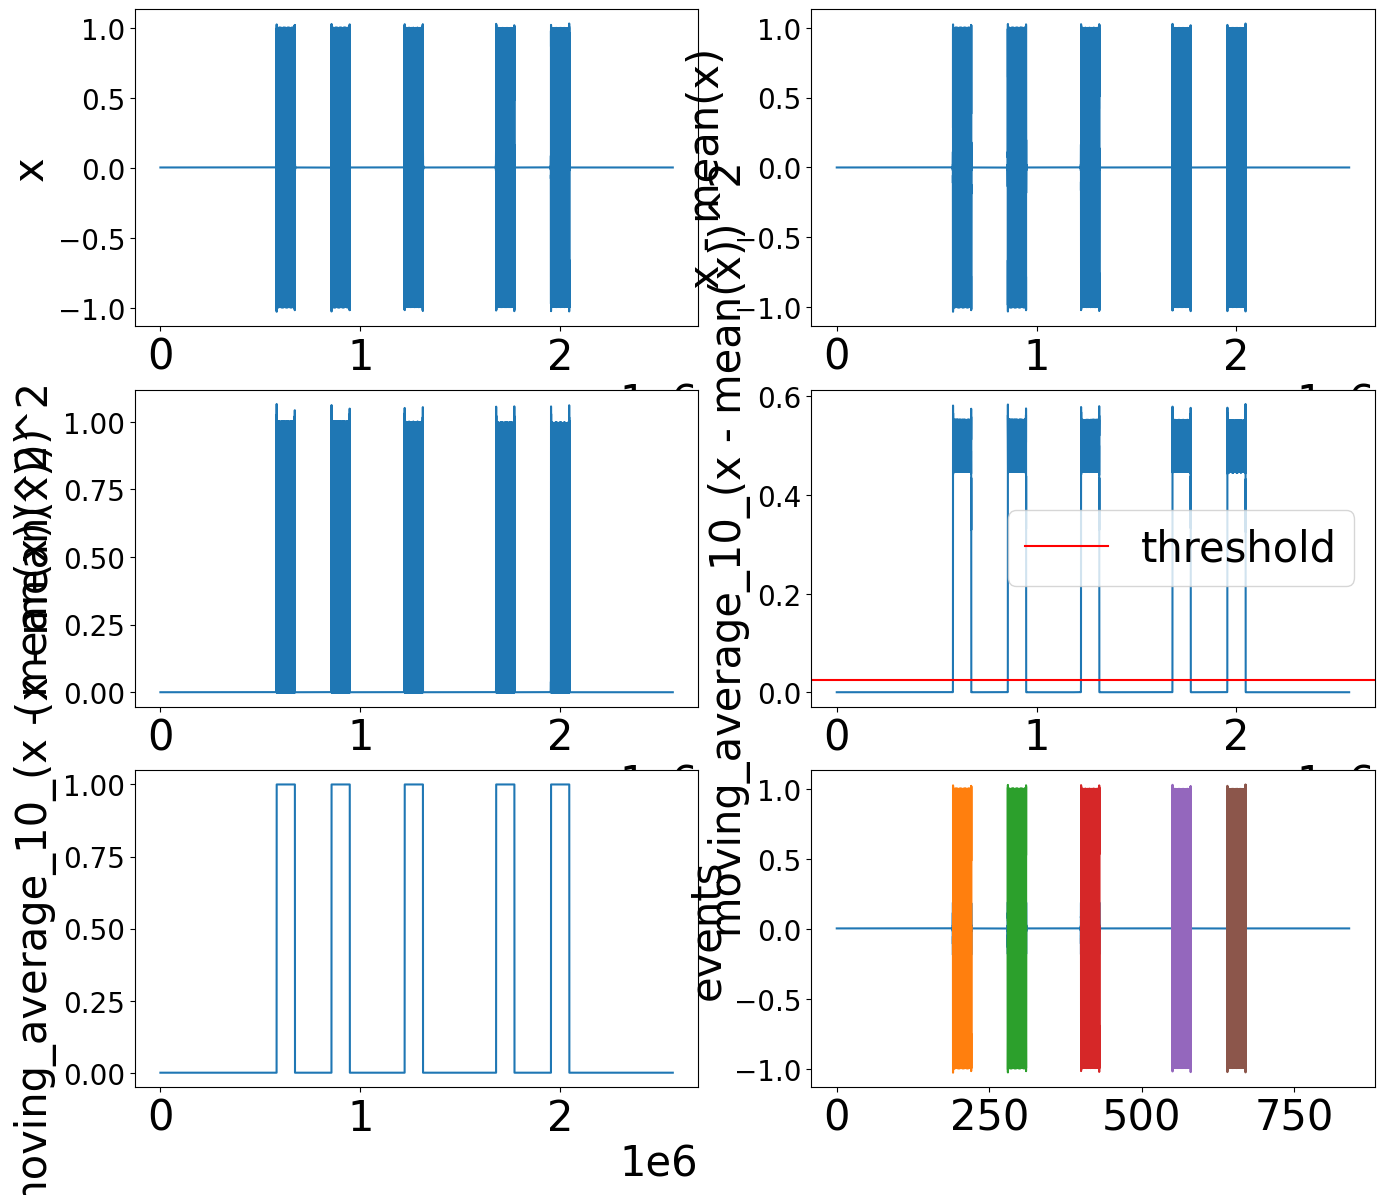

In [21]:
threshold = 0.025
window_size = 100

data_train = get_events(
    data=data_train, 
    threshold=threshold, 
    window_size=window_size, 
    time_sampling=TimeSamplingTrain
)

In [22]:
savemat(f"{data_train_filename.split('.')[0]}_events.mat", data_train.to_dict())

In [23]:
desired_frequency_sampling = 500

data_train, TimeSampling, FrequencySampling = decimate(data_train, desired_frequency_sampling=desired_frequency_sampling)

data_train.to_csv(f"{data_train_filename.split('.')[0]}_to_bispectrum.csv", index=False)

2023-05-11 21:14:30.786 | INFO     | __main__:decimate:6 - The time sampling is 0.000328 seconds and the frequency is 3048.780487804878 kHz
2023-05-11 21:14:30.786 | INFO     | __main__:decimate:11 - The data will be decimated by the rate 1:7
2023-05-11 21:14:30.787 | INFO     | __main__:decimate:24 - The new time sampling is 0.0023 s and the new frequency is 435.5400696864112 Hz


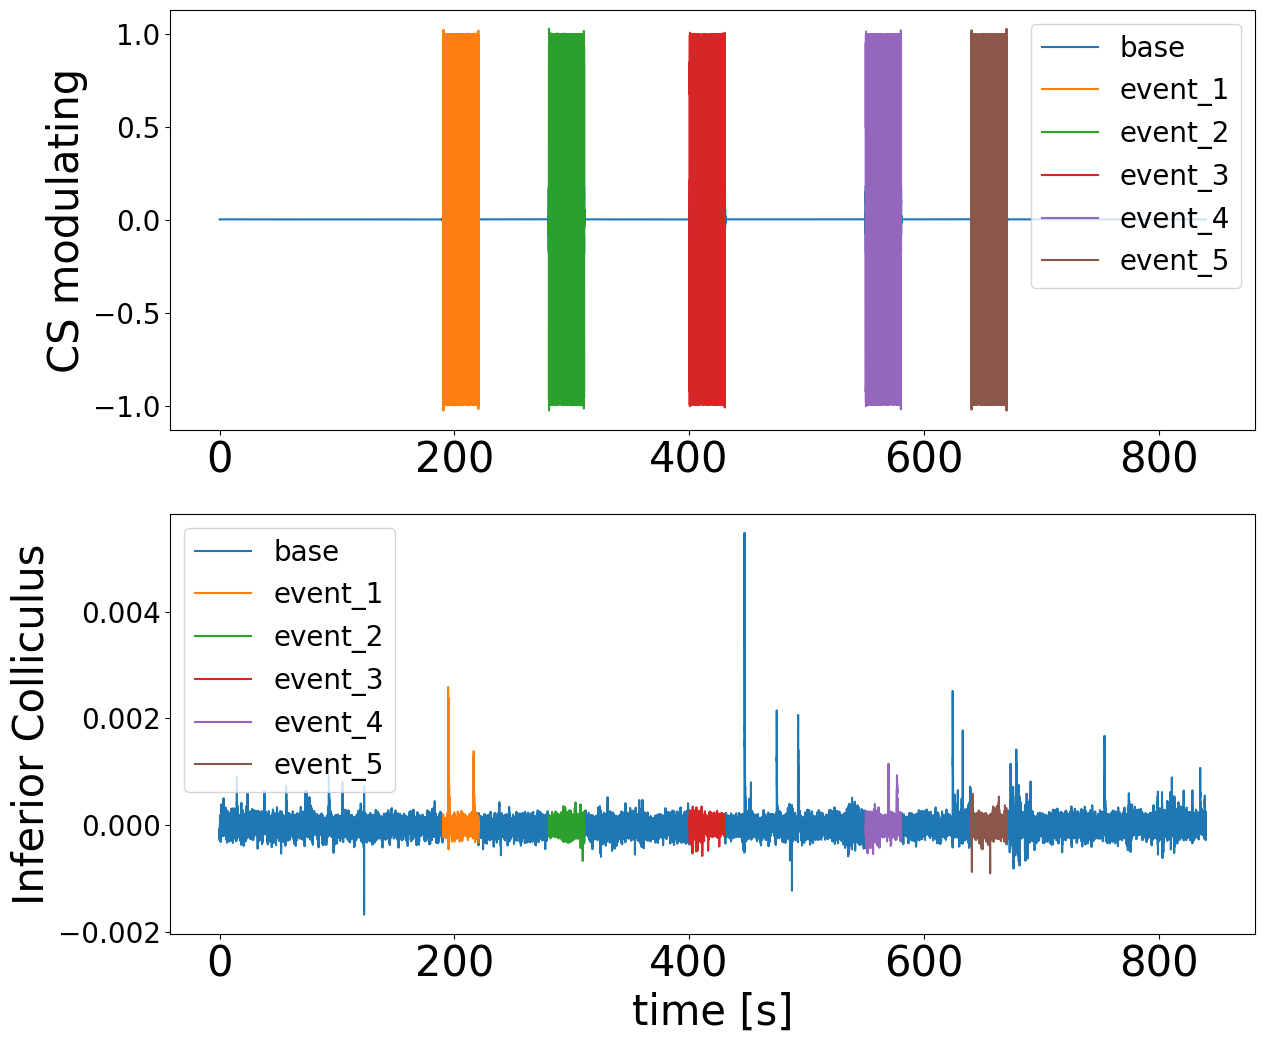

In [24]:
plt.figure(figsize=(14,12))

plt.subplot(211)
for event in data_train.event.unique():
    plt.plot(data_train.loc[data_train.event==event, "Time"], data_train.loc[data_train.event==event, "CS_modulating"], label=event)
plt.legend(prop={'size': 20})
plt.ylabel("CS modulating")

plt.subplot(212)
for event in data_train.event.unique():
    plt.plot(data_train.loc[data_train.event==event, "Time"], data_train.loc[data_train.event==event, "Inferior_colliculus"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus")
plt.legend(prop={'size': 20})

plt.show()

## Test data


Event: 1
start: 581681
end: 673291
time duration: 30.018764795081726

Event: 2
start: 856342
end: 947952
time duration: 30.018764795081726

Event: 3
start: 1222556
end: 1314166
time duration: 30.018764795081726

Event: 4
start: 1680322
end: 1771933
time duration: 30.019092475081674

Event: 5
start: 1954983
end: 2046593
time duration: 30.018764795081726

len(indices) = 10


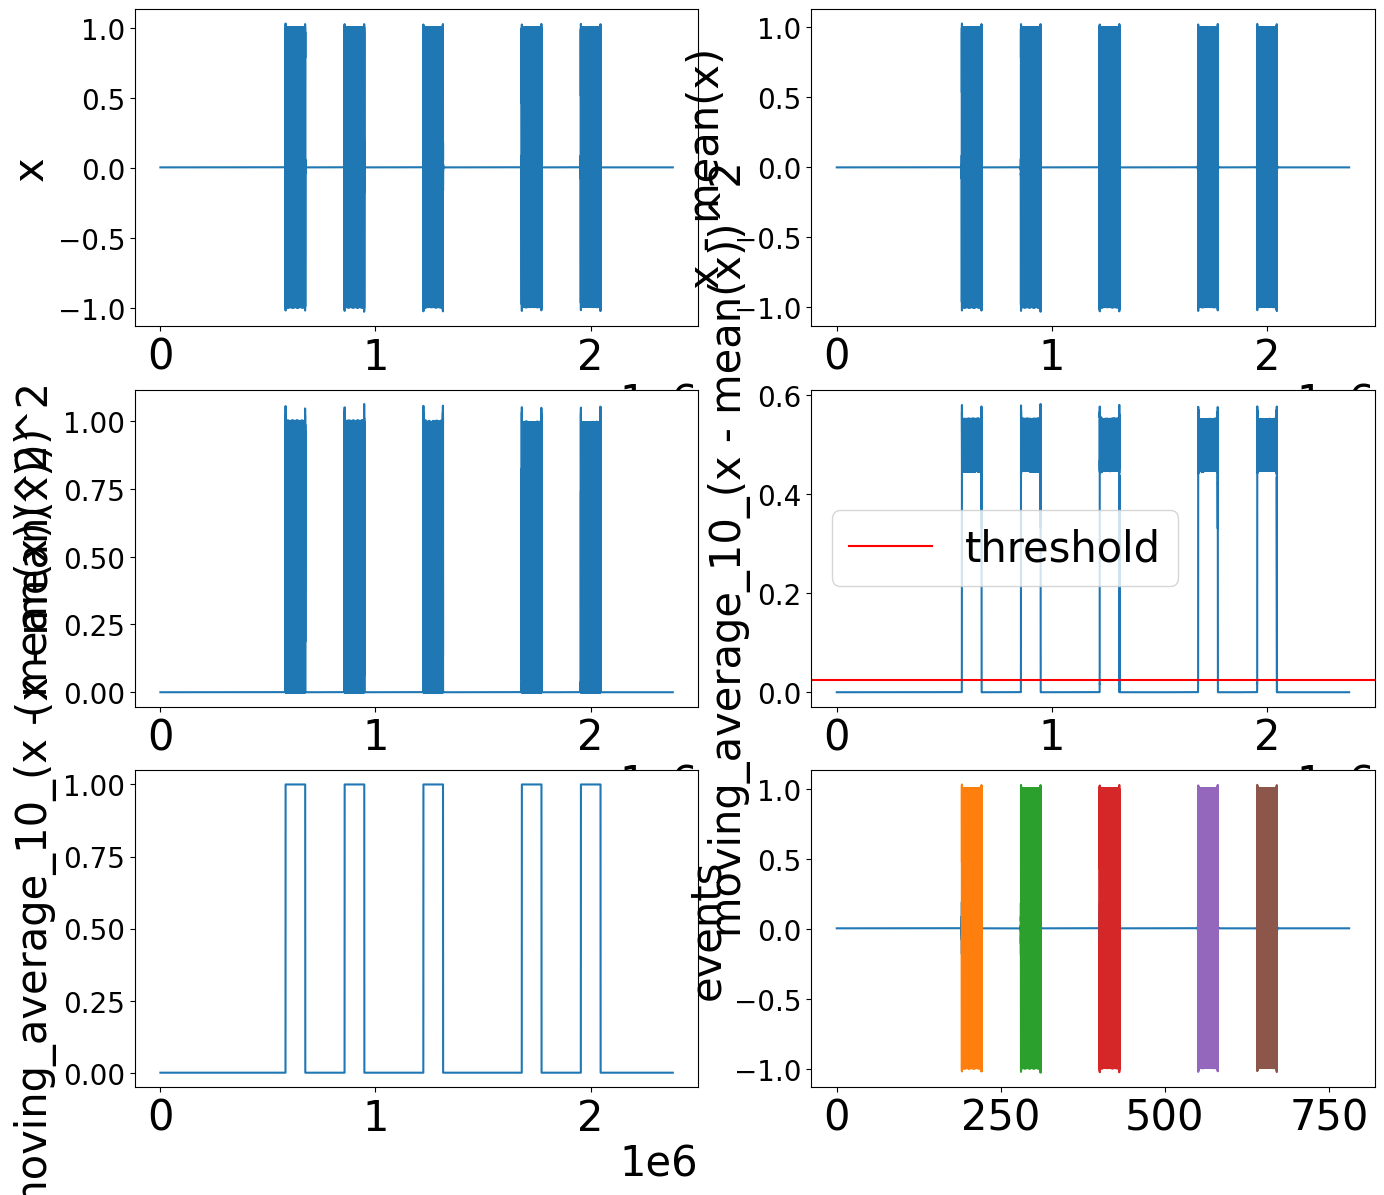

In [25]:
threshold = 0.025
window_size = 100

data_test = get_events(
    data=data_test, 
    threshold=threshold, 
    window_size=window_size, 
    time_sampling=TimeSamplingTest
)

In [26]:
savemat(f"{data_test_filename.split('.')[0]}_events.mat", data_test.to_dict())

In [27]:
data_test, TimeSampling, FrequencySampling = decimate(data_test, desired_frequency_sampling=desired_frequency_sampling)
data_test.to_csv(f"{data_test_filename.split('.')[0]}_to_bispectrum.csv", index=False)

2023-05-11 21:14:46.039 | INFO     | __main__:decimate:6 - The time sampling is 0.000328 seconds and the frequency is 3048.780487804878 kHz
2023-05-11 21:14:46.040 | INFO     | __main__:decimate:11 - The data will be decimated by the rate 1:7
2023-05-11 21:14:46.040 | INFO     | __main__:decimate:24 - The new time sampling is 0.0023 s and the new frequency is 435.5400696864112 Hz


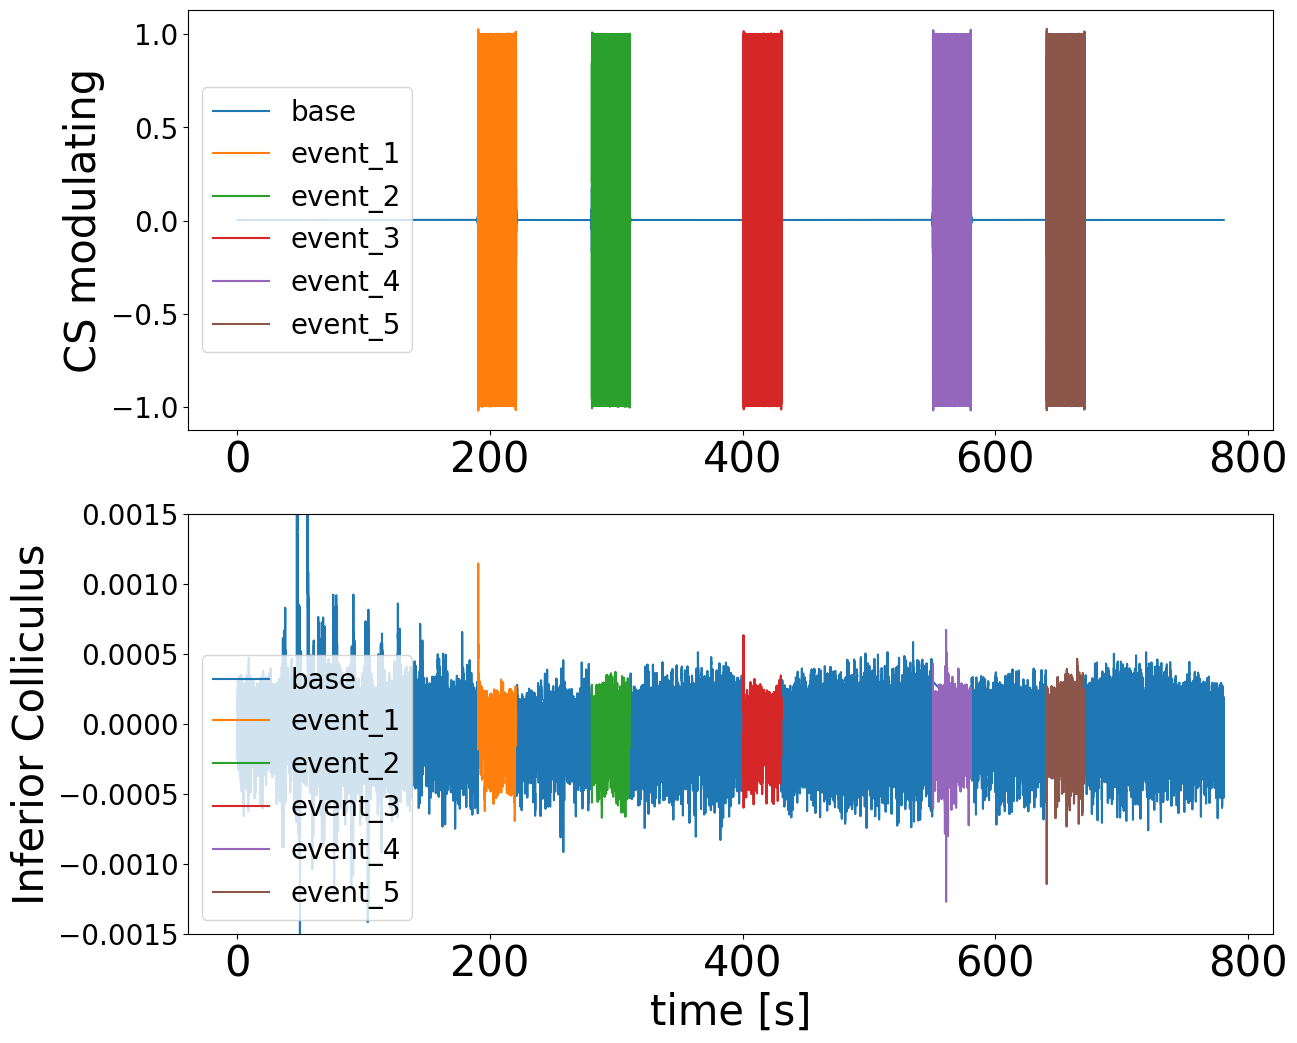

In [28]:
plt.figure(figsize=(14,12))

plt.subplot(211)
for event in data_train.event.unique():
    plt.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "CS_modulating"], label=event)
plt.legend(loc=6, prop={'size': 20})
plt.ylabel("CS modulating")

plt.subplot(212)
for event in data_test.event.unique():
    plt.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "Inferior_colliculus"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus")
plt.legend(prop={'size': 20})
plt.ylim([-1.5e-3, 1.5e-3])
plt.savefig(
    "test_waveform.jpg",
    format="jpg",
    bbox_inches='tight', 
    dpi=150
)
plt.show()

# Data filtering

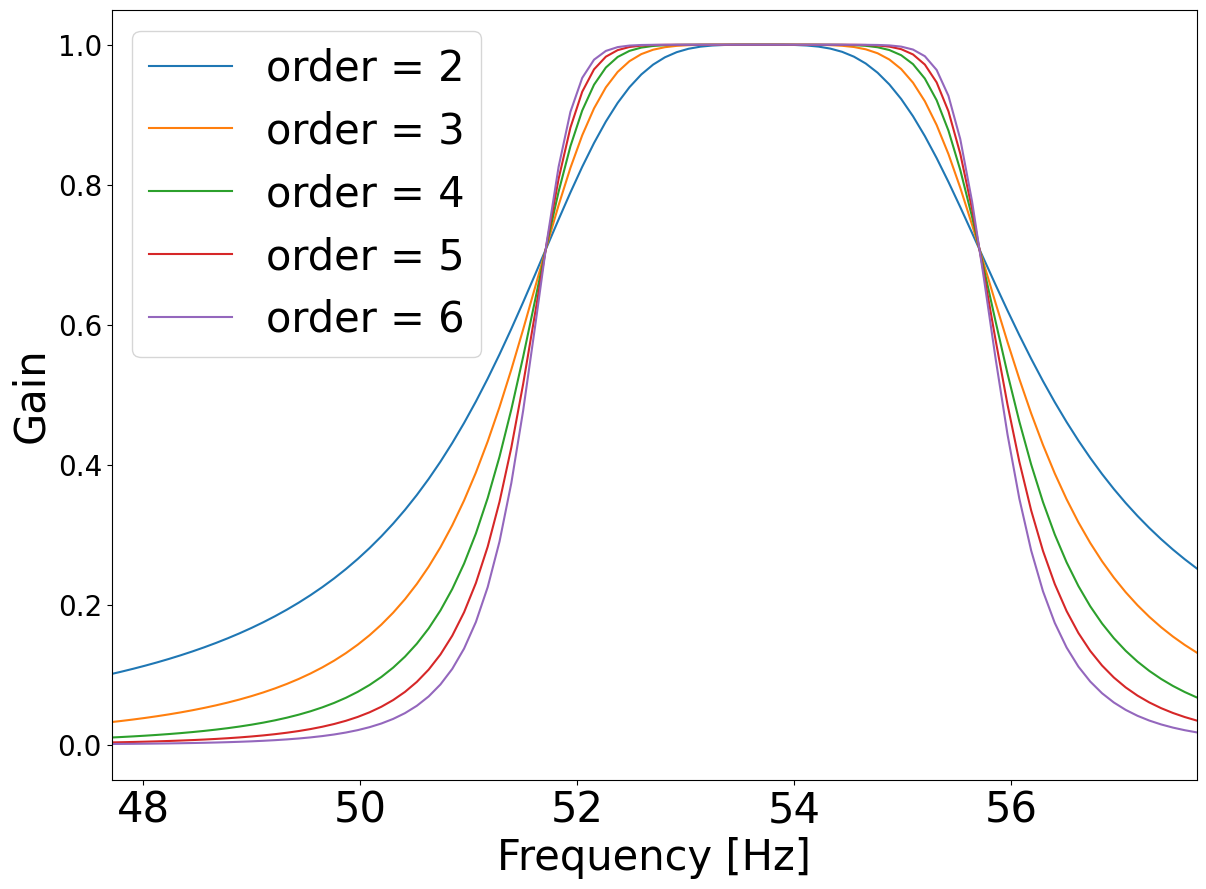

In [29]:
low_cut_hz = 53.71 - 2.0
high_cut_hz = 53.71 + 2.0
fs = 1.0/TimeSampling

plt.figure(figsize=(14,10))
plt.clf()

for order in range(2,7):
    b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs, order=order)
    w, h = signal.freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)


plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.legend()
plt.xlim([low_cut_hz-4, high_cut_hz+2])
plt.show()

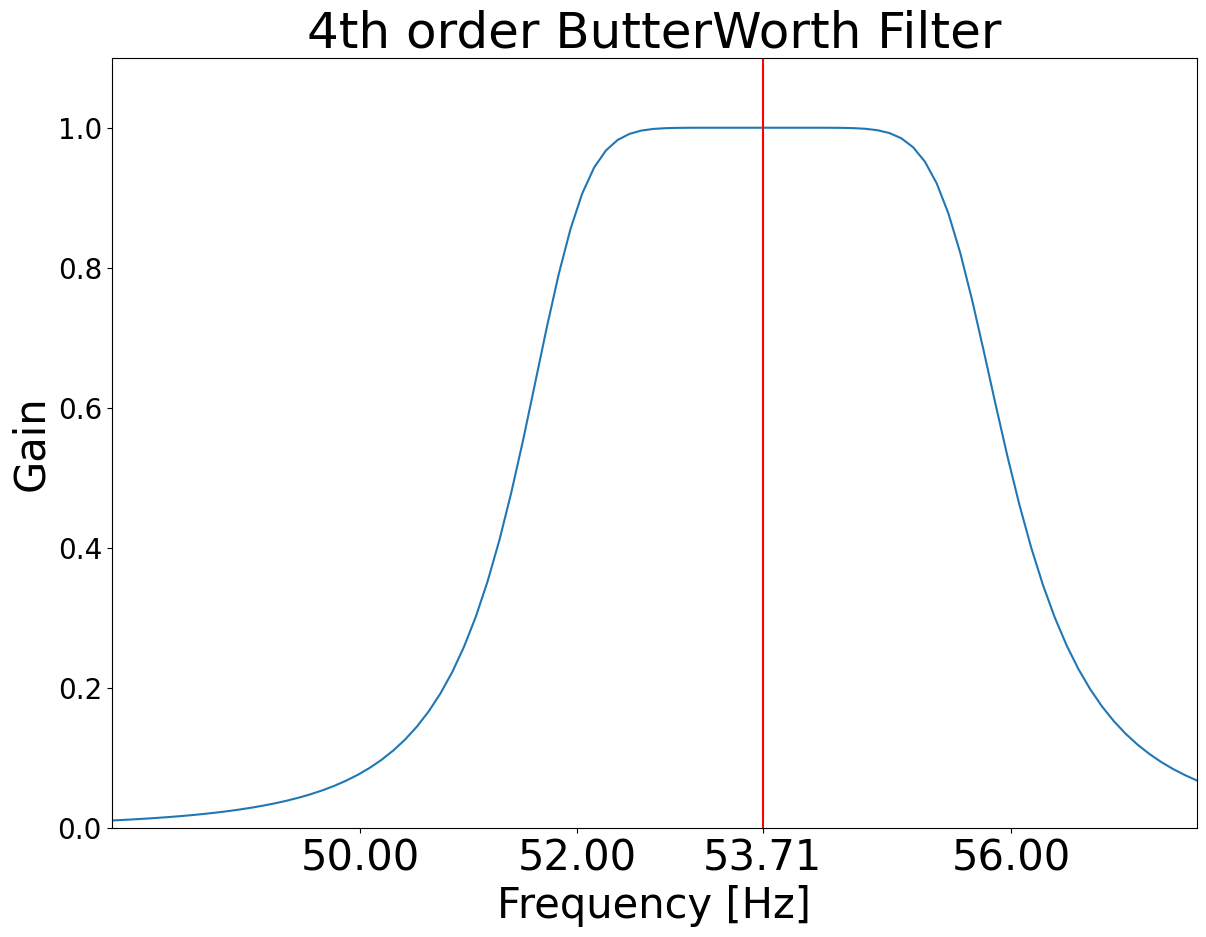

In [30]:
filter_order = 4
b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs=fs, order=filter_order)

plt.figure(figsize=(14,10))
plt.clf()
w, h = signal.freqz(b, a, fs=fs, worN=2000)
plt.plot(w, abs(h))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.vlines(53.71, -1, 2, color='red')
plt.ylim([0, 1.1])
plt.xticks([50, 52, 53.71, 56])
plt.xlim([low_cut_hz-4, high_cut_hz+2])
plt.title(f"{filter_order}th order ButterWorth Filter")
plt.show()

## Filtering using filtfilt to avoid phase changes

In [31]:
def filter_function(column): 
    return butter_bandpass_filter(
        data=column, 
        lowcut=low_cut_hz, 
        highcut=high_cut_hz,
        fs=fs,
        order=filter_order, 
        filtfilt=True
    )

## Filtering train data

In [32]:
data_train.columns

Index(['Time', 'CS_modulating', 'Inferior_colliculus', 'event'], dtype='object')

In [33]:
filtered_Inferior_colliculus = filter_function(data_train.Inferior_colliculus.to_numpy())
data_train = data_train.assign(filtered_Inferior_colliculus=filtered_Inferior_colliculus)

In [34]:
data_train.columns

Index(['Time', 'CS_modulating', 'Inferior_colliculus', 'event',
       'filtered_Inferior_colliculus'],
      dtype='object')

## Filtering test data

In [35]:
data_test.columns

Index(['Time', 'CS_modulating', 'Inferior_colliculus', 'event'], dtype='object')

In [36]:
filtered_Inferior_colliculus = filter_function(data_test.Inferior_colliculus.to_numpy())
data_test = data_test.assign(filtered_Inferior_colliculus=filtered_Inferior_colliculus)

In [37]:
data_test.columns

Index(['Time', 'CS_modulating', 'Inferior_colliculus', 'event',
       'filtered_Inferior_colliculus'],
      dtype='object')

# Data Visualization

<Figure size 1400x1200 with 0 Axes>

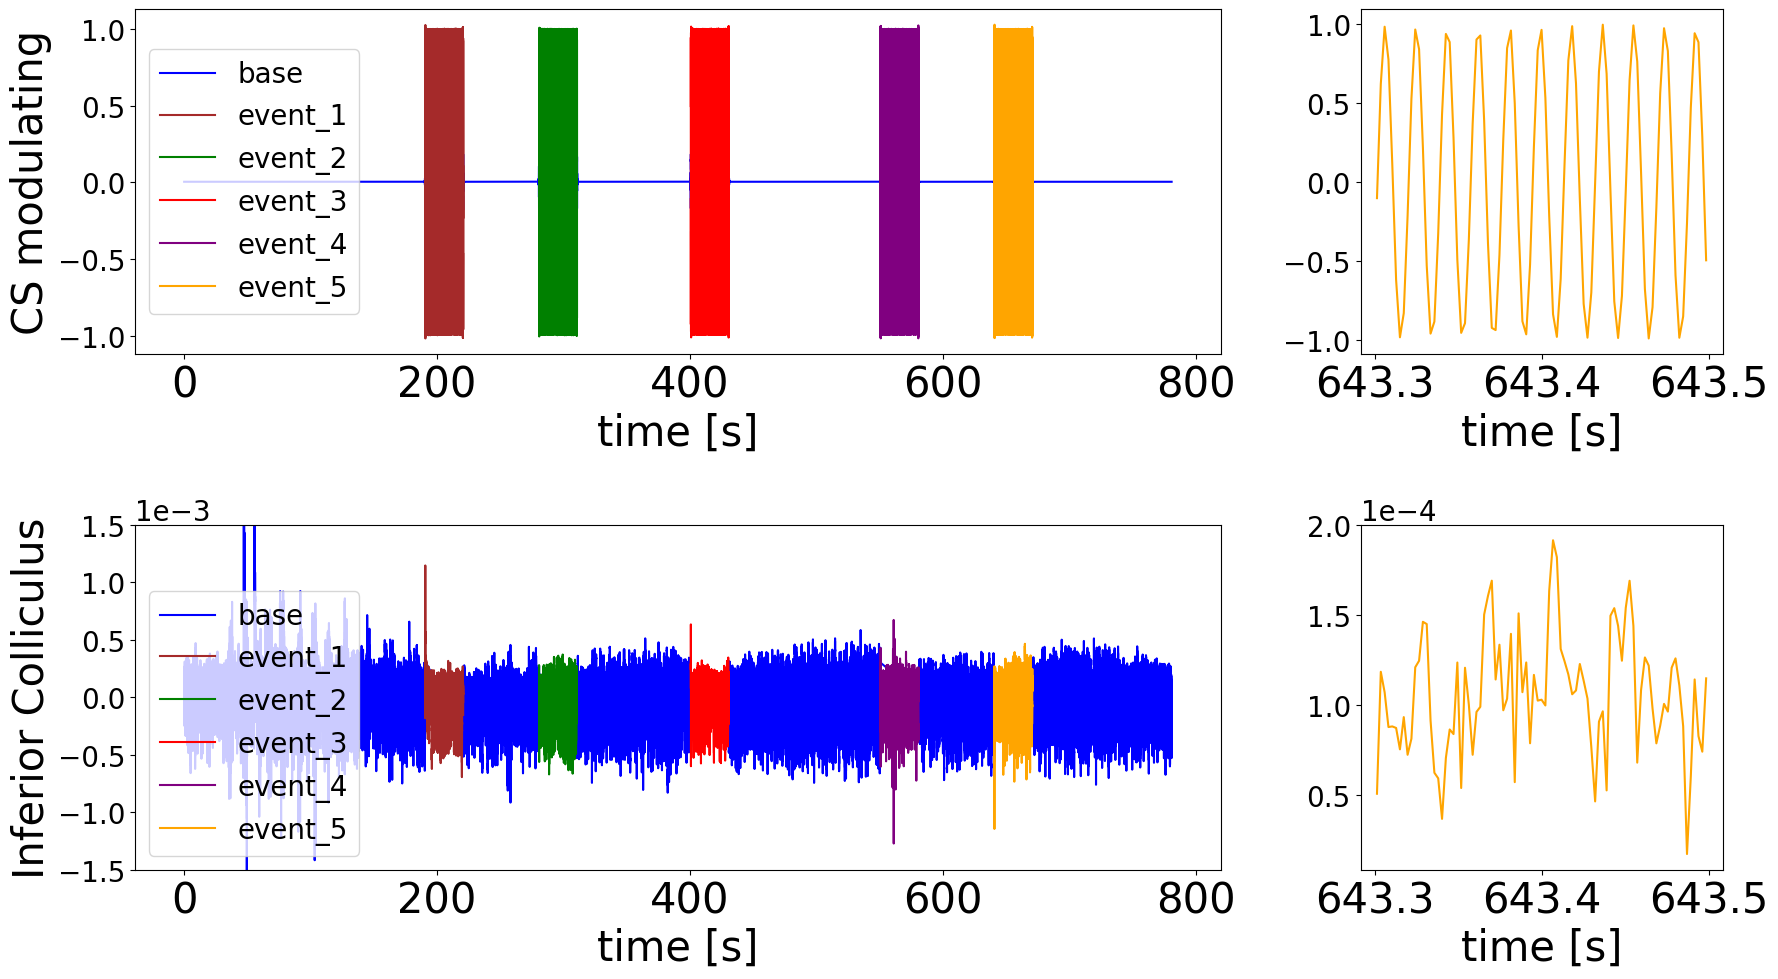

In [38]:
fig = plt.figure(figsize=(14,12))

colors = ["blue", "brown", "green", "red", "purple", "orange"]

f, eixos = plt.subplots(2, 2, gridspec_kw={'width_ratios': [3, 1]})
f.set_size_inches(18.5, 10.5)

a0, a1, a2, a3 = eixos.reshape(-1)

for event, color in zip(data_train.event.unique(), colors):
    a0.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "CS_modulating"], label=event, color=color)
a0.legend(loc=6, prop={'size': 20})
a0.set_ylabel("CS modulating")
a0.set_xlabel("time [s]")

for event, color in zip(data_train.event.unique(), colors):
    a2.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "Inferior_colliculus"], label=event, color=color)
a2.set_ylabel("Inferior Colliculus")
a2.legend(prop={'size': 20})
a2.set_ylim([-1.5e-3, 1.5e-3])
a2.ticklabel_format(axis='y', style='sci', scilimits=(1e-3, 1e3), useOffset=False)
a2.set_xlabel("time [s]")

begin_time_to_zoom = 643.3
time_to_zoom = 0.2

a1.plot(data_test.loc[(begin_time_to_zoom <= data_test.Time)&(data_test.Time <= begin_time_to_zoom+time_to_zoom), "Time"], data_test.loc[(begin_time_to_zoom <= data_test.Time)&(data_test.Time <= begin_time_to_zoom+time_to_zoom), "CS_modulating"], color="orange")
a1.set_xlabel("time [s]")

a3.plot(data_test.loc[(begin_time_to_zoom <= data_test.Time)&(data_test.Time <= begin_time_to_zoom+time_to_zoom), "Time"], data_test.loc[(begin_time_to_zoom <= data_test.Time)&(data_test.Time <= begin_time_to_zoom+time_to_zoom), "Inferior_colliculus"], color="orange")
a3.set_xlabel("time [s]")
a3.ticklabel_format(axis='y', style='sci', scilimits=(1e-3, 1e3), useOffset=False)

f.tight_layout()

plt.savefig(
    "test_waveform4.jpg",
    format="jpg",
    bbox_inches='tight', 
    dpi=150
)

plt.show()

## Train data

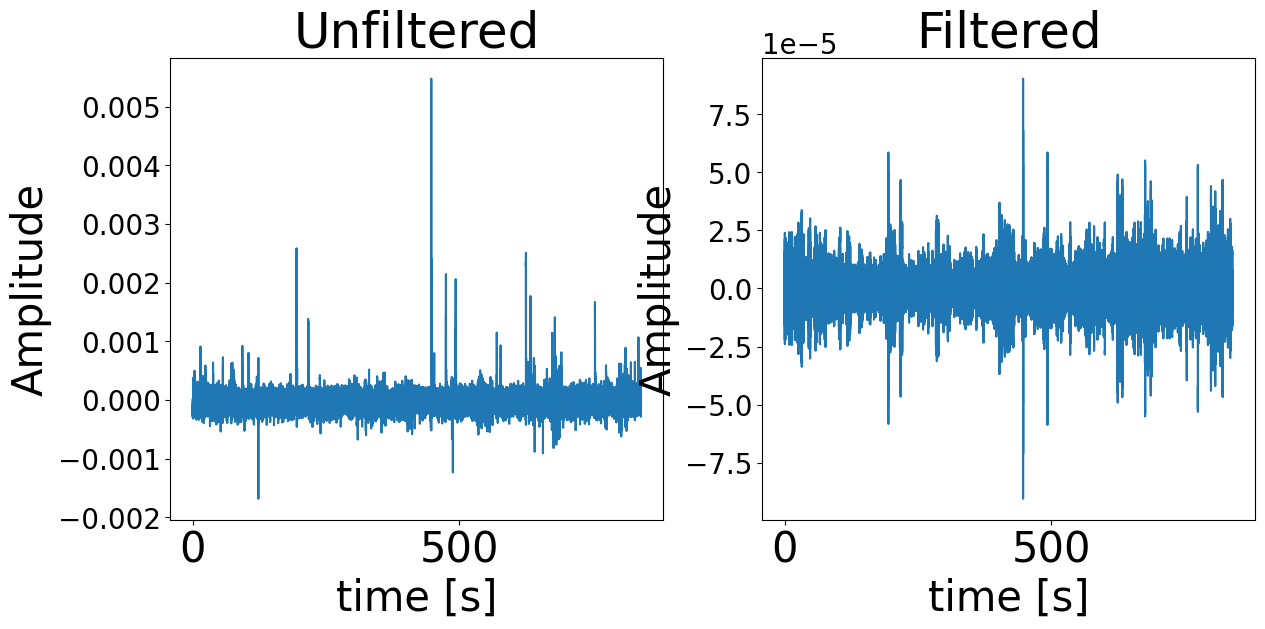

In [39]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.plot(data_train.Time, data_train.loc[:,'Inferior_colliculus'])
plt.title("Unfiltered")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(data_train.Time, data_train.loc[:,'filtered_Inferior_colliculus'])
plt.title("Filtered")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")

plt.show()

## Test data

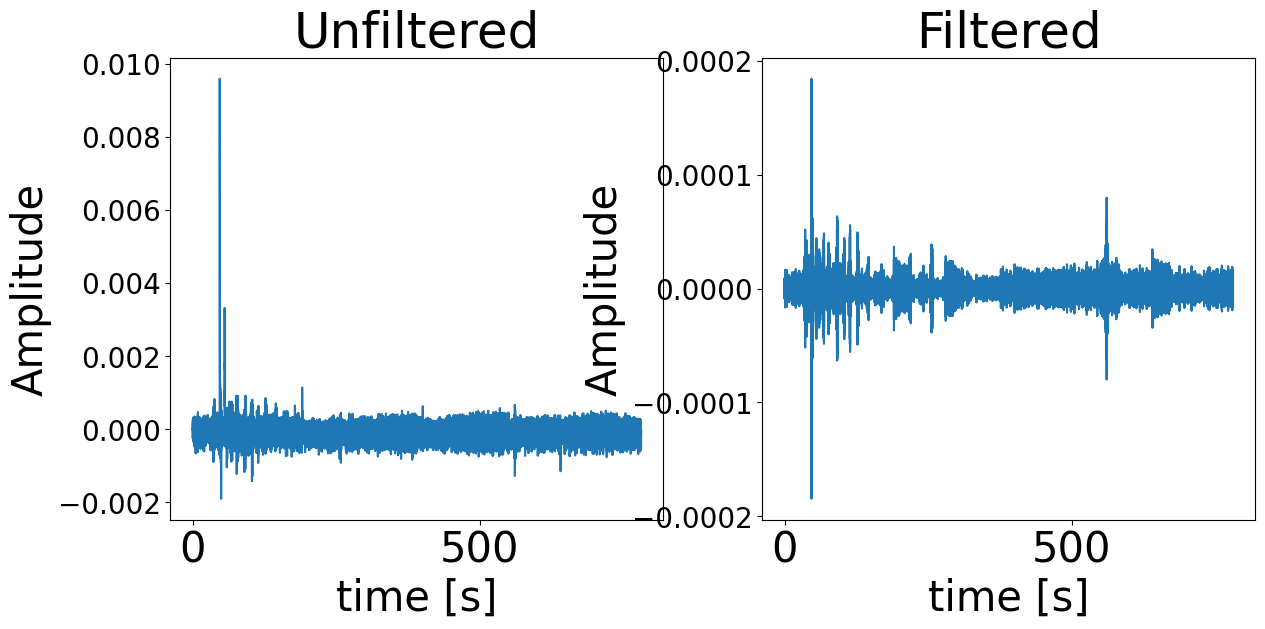

In [40]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.plot(data_test.Time, data_test.loc[:,'Inferior_colliculus'])
plt.title("Unfiltered")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(data_test.Time, data_test.loc[:,'filtered_Inferior_colliculus'])
plt.title("Filtered")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")

plt.show()

# Normalizing Data

## Normalizing train data

In [41]:
norm = False

In [42]:
def norm_function(x: np.ndarray) -> np.ndarray:
    return (x.copy() - x.mean())/x.std()

if norm:
    normalized_Inferior_colliculus = norm_function(data_train.Inferior_colliculus.to_numpy())
    data_train = data_train.assign(norm_Inferior_colliculus=normalized_Inferior_colliculus)
    
    normalized_Inferior_colliculus = norm_function(data_test.Inferior_colliculus.to_numpy())
    data_test = data_test.assign(norm_Inferior_colliculus=normalized_Inferior_colliculus)
    
    plt.figure(figsize=(14,6))

    plt.subplot(121)
    plt.plot(data_train.Time, data_train.loc[:,'Inferior_colliculus'])
    plt.title("Train - Raw")
    plt.xlabel("time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(122)
    plt.plot(data_train.Time, data_train.loc[:,'norm_Inferior_colliculus'])
    plt.title("Train - Normalized")
    plt.xlabel("time [s]")
    plt.ylabel("Amplitude")

    plt.show()

    plt.figure(figsize=(14,6))

    plt.subplot(121)
    plt.plot(data_test.Time, data_test.loc[:,'Inferior_colliculus'])
    plt.title("Test - RAW")
    plt.xlabel("time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(122)
    plt.plot(data_test.Time, data_test.loc[:,'norm_Inferior_colliculus'])
    plt.title("Test - Normalized")
    plt.xlabel("time [s]")
    plt.ylabel("Amplitude")

plt.show()

## Saving data

In [43]:
data_train_backup = data_train
data_test_backup = data_test

# Energy

2023-05-11 21:14:55.064 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 1


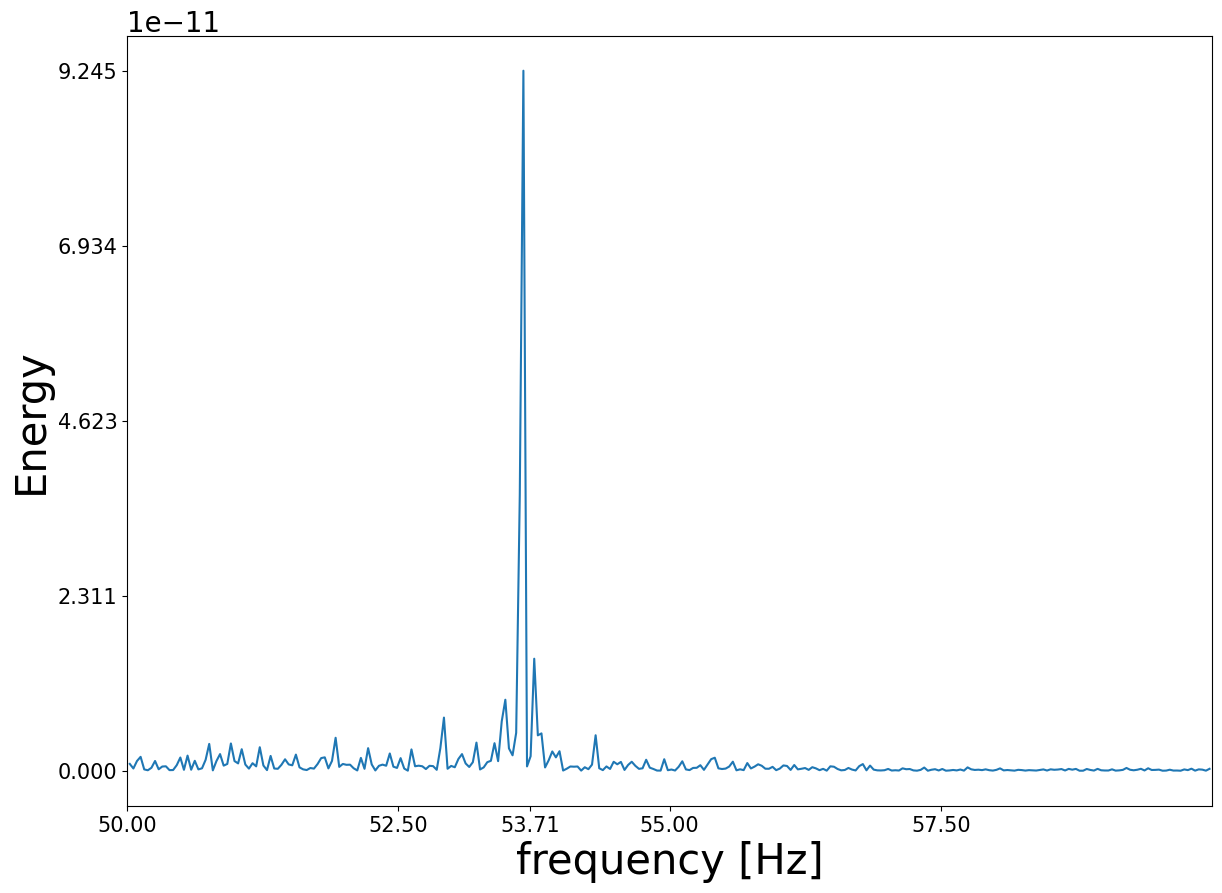

2023-05-11 21:14:55.279 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 1 - raw data
2023-05-11 21:14:55.279 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 1


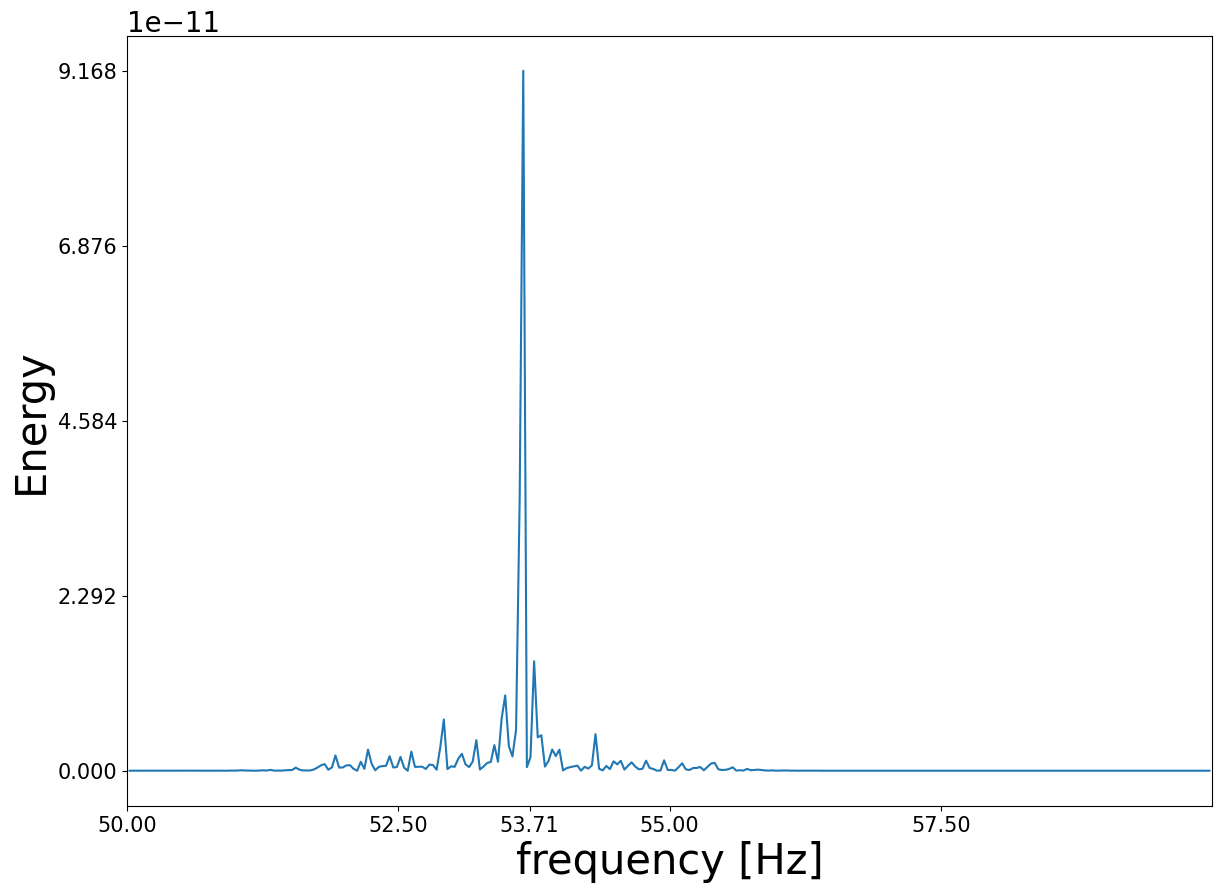

2023-05-11 21:14:55.483 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 1 - filtered data
2023-05-11 21:14:55.483 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 2


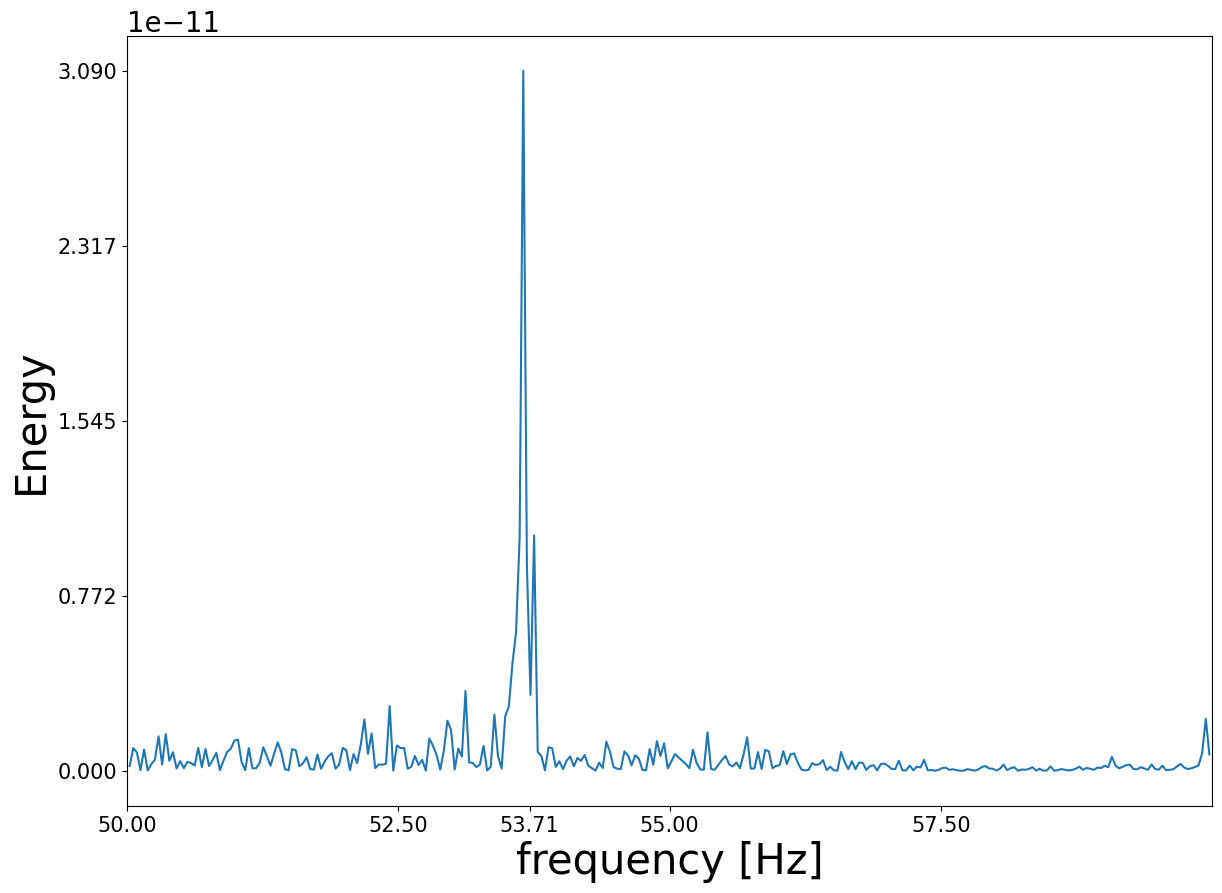

2023-05-11 21:14:55.685 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 2 - raw data
2023-05-11 21:14:55.686 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 2


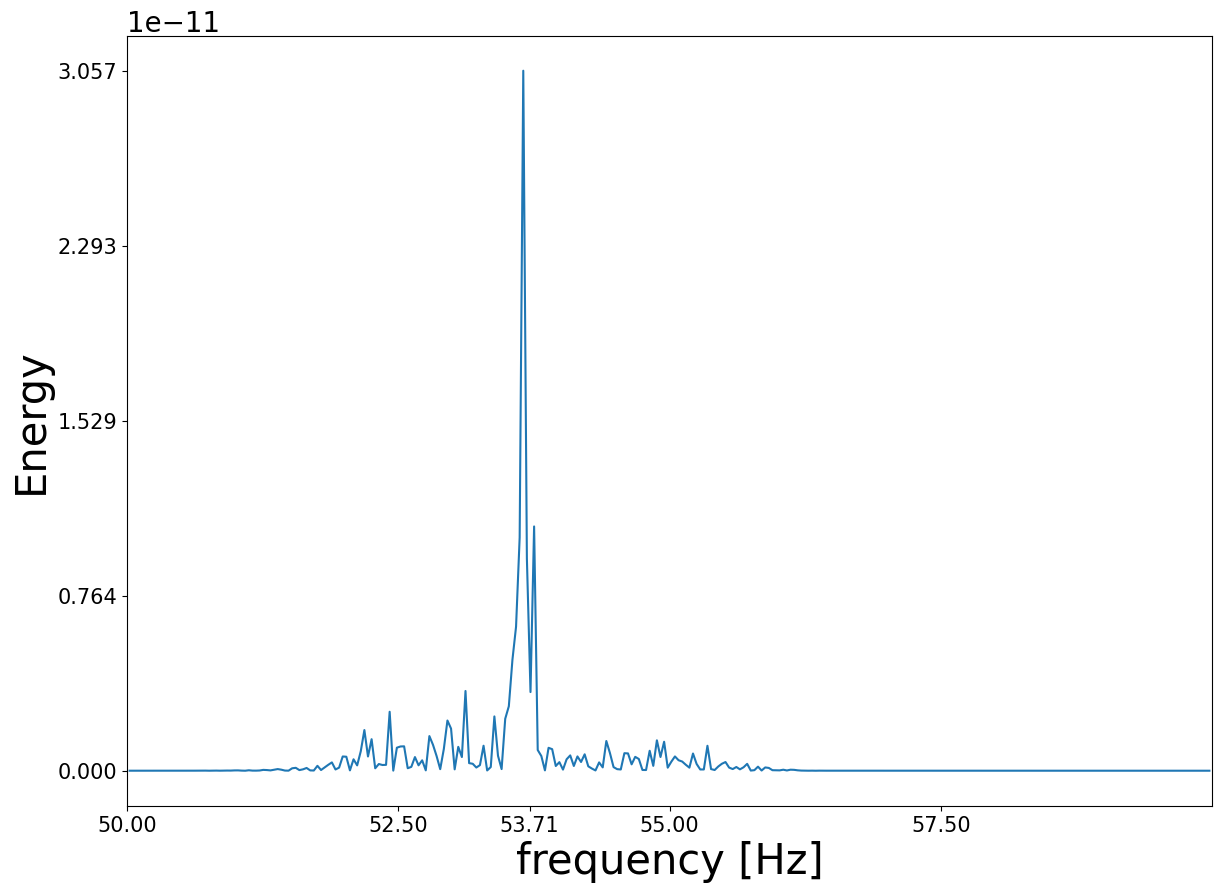

2023-05-11 21:14:55.948 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 2 - filtered data
2023-05-11 21:14:55.949 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 3


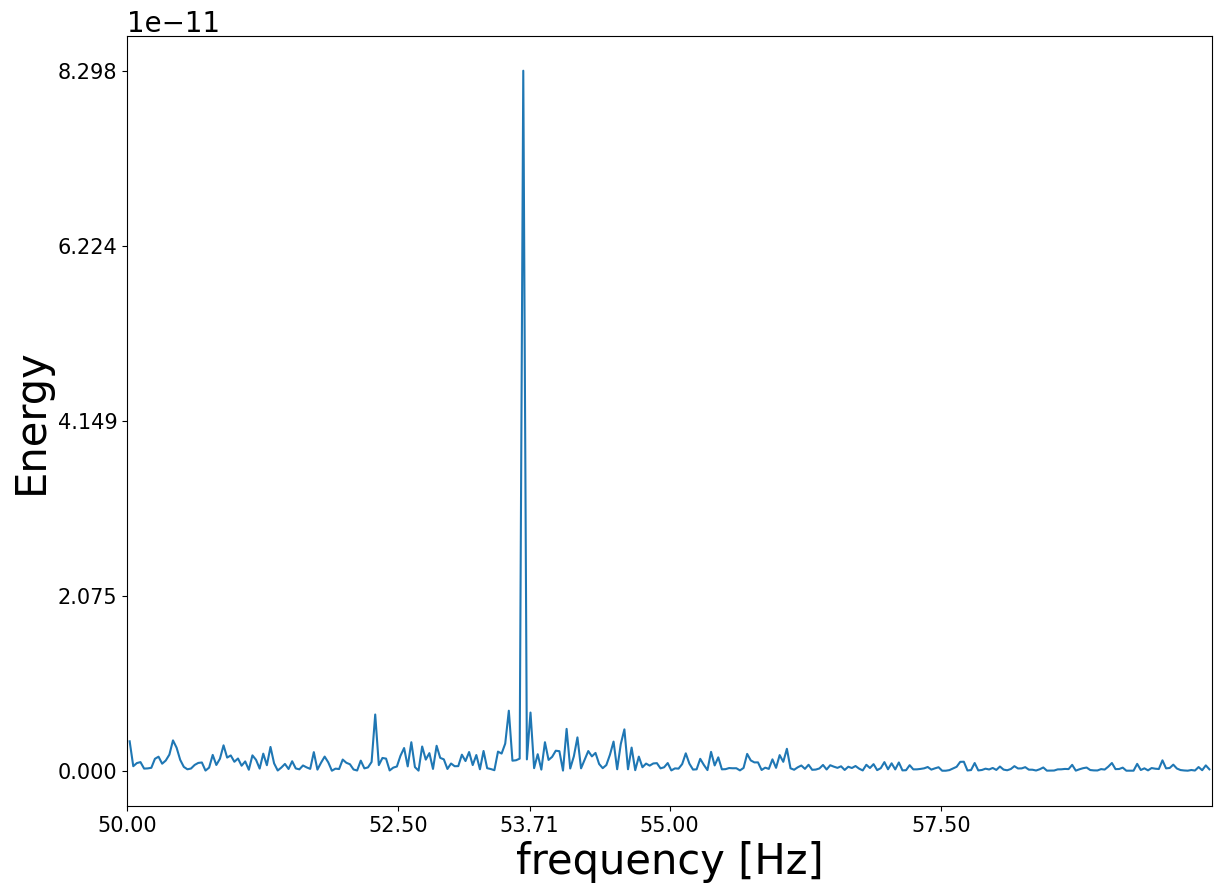

2023-05-11 21:14:56.148 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 3 - raw data
2023-05-11 21:14:56.148 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 3


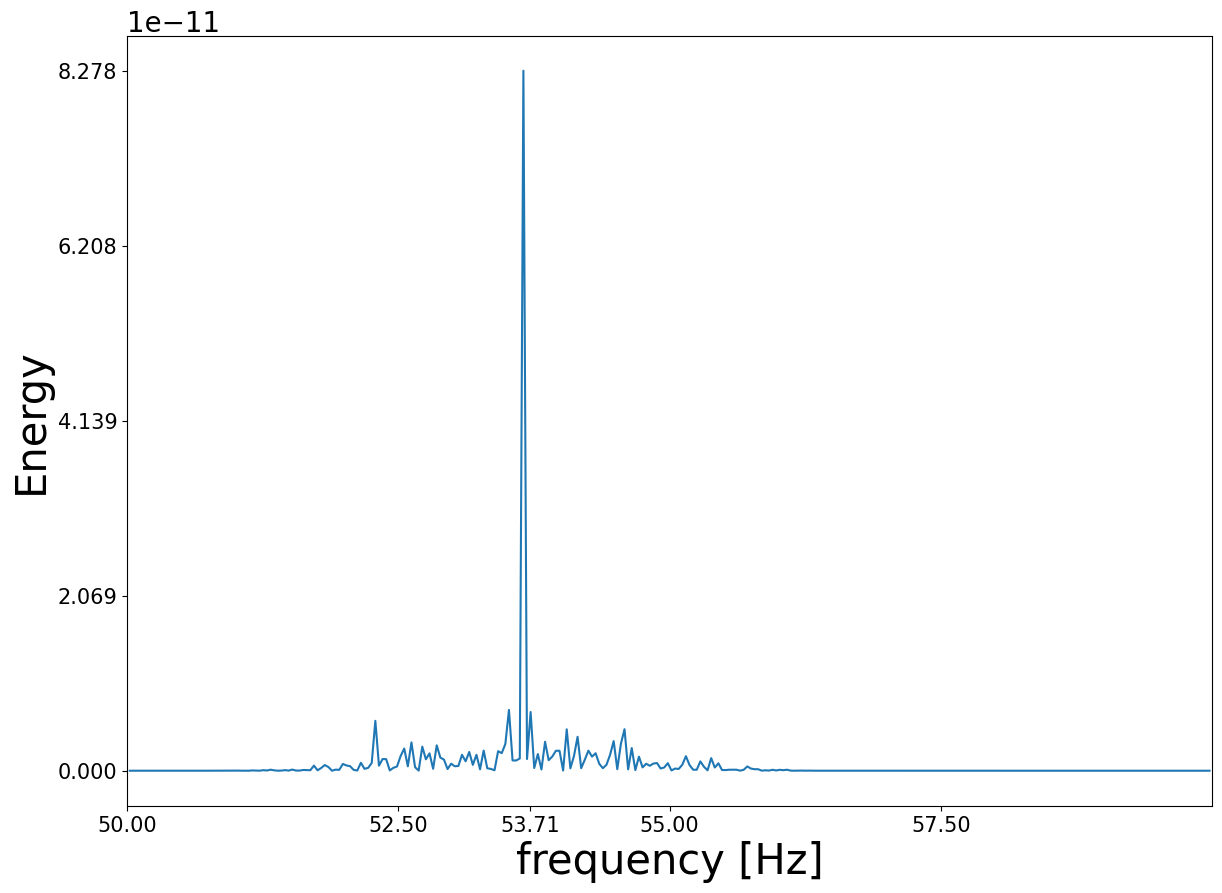

2023-05-11 21:14:56.342 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 3 - filtered data
2023-05-11 21:14:56.342 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 4


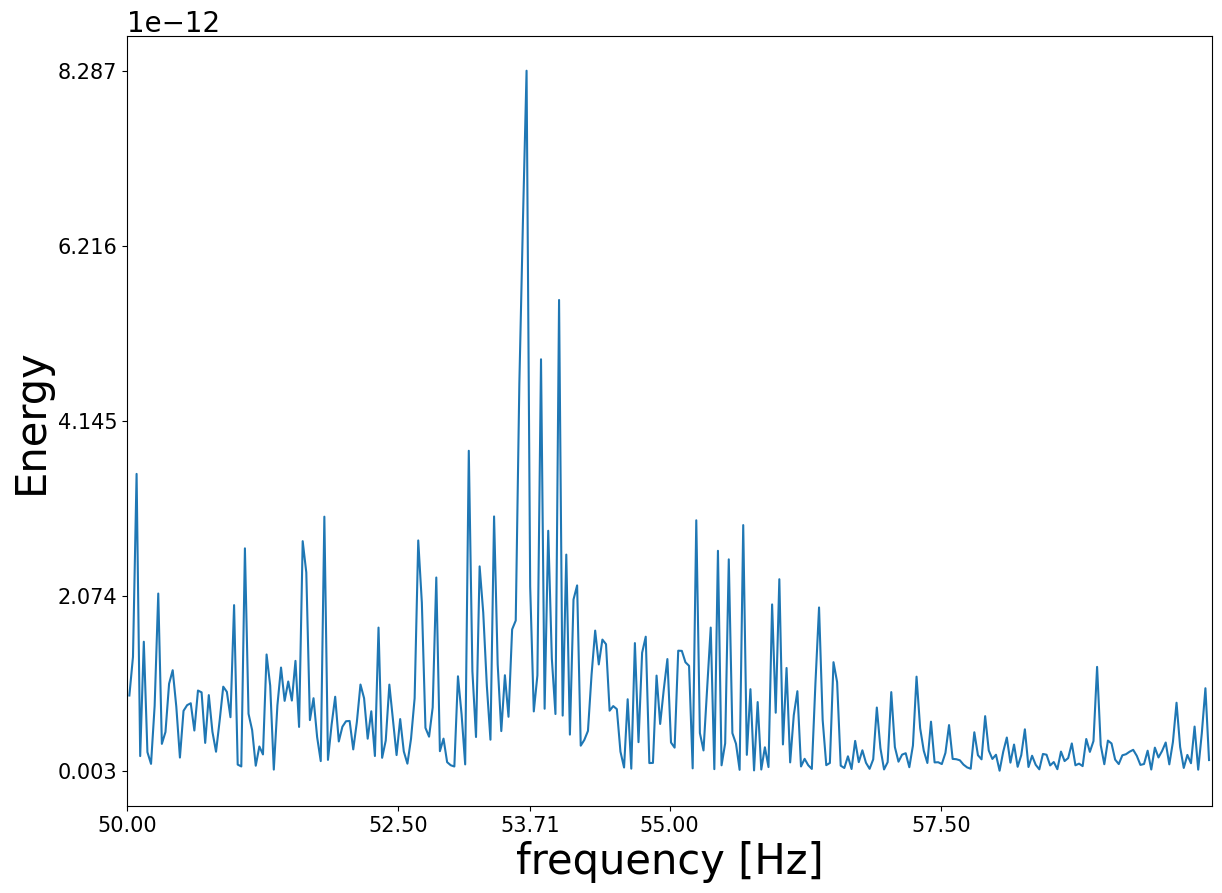

2023-05-11 21:14:56.556 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 4 - raw data
2023-05-11 21:14:56.557 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 4


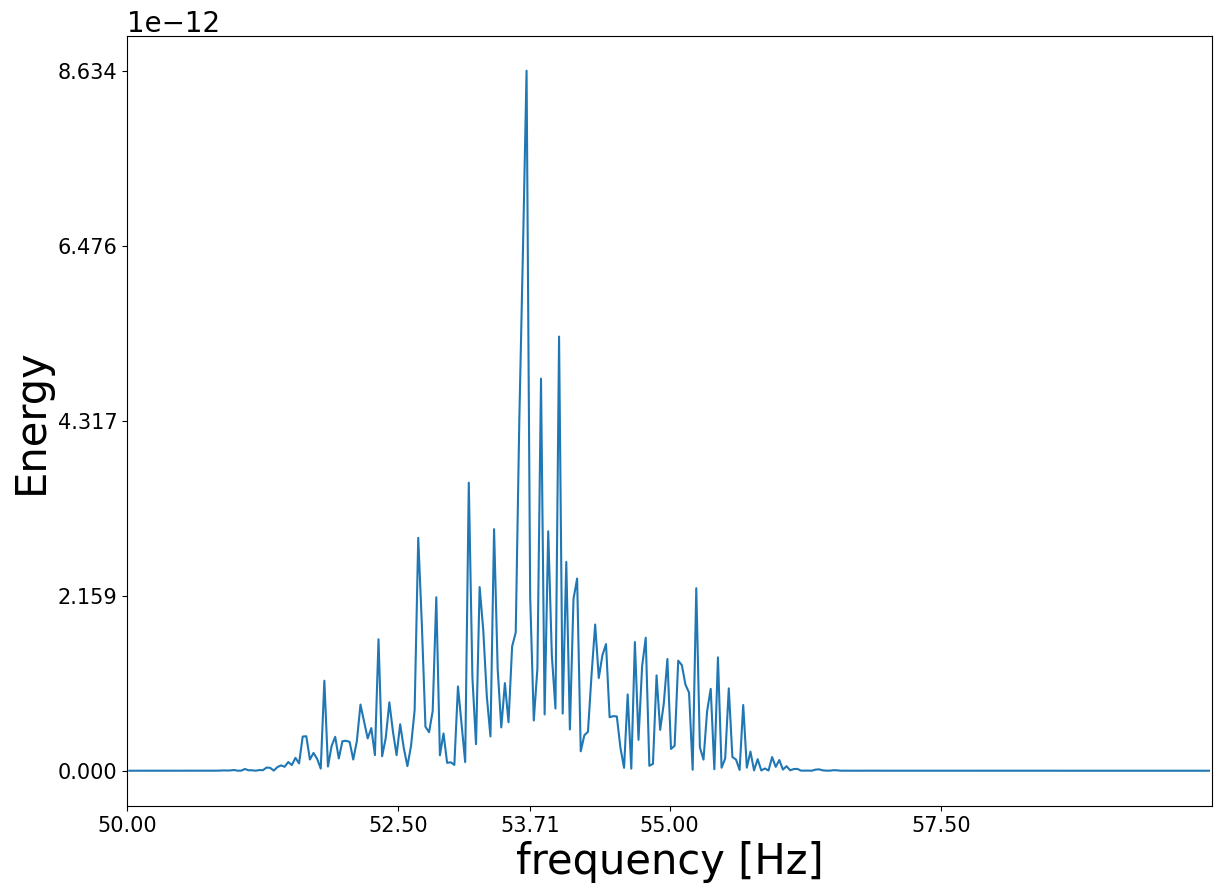

2023-05-11 21:14:56.759 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 4 - filtered data
2023-05-11 21:14:56.760 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 5


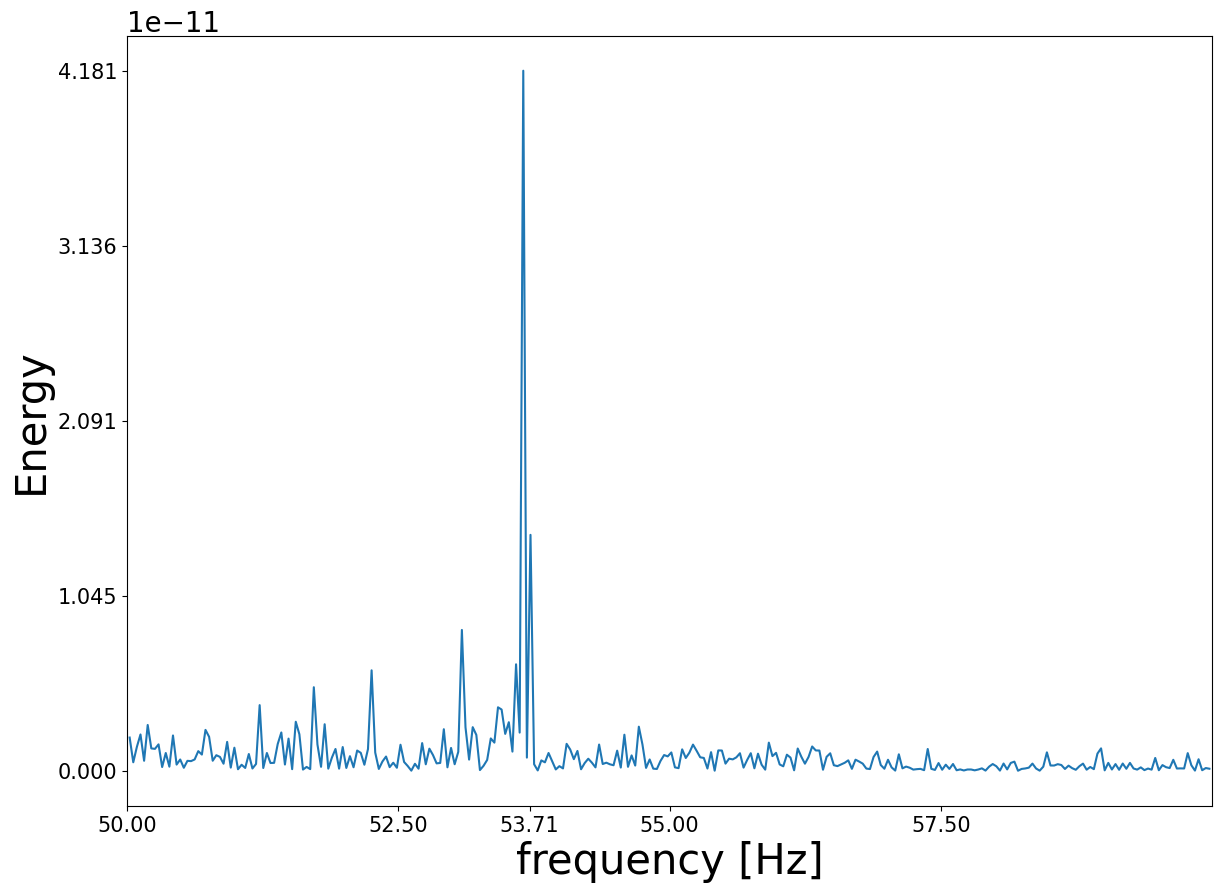

2023-05-11 21:14:56.963 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 5 - raw data
2023-05-11 21:14:56.965 | INFO     | __main__:<module>:7 - Train Data - Selecting Event 5


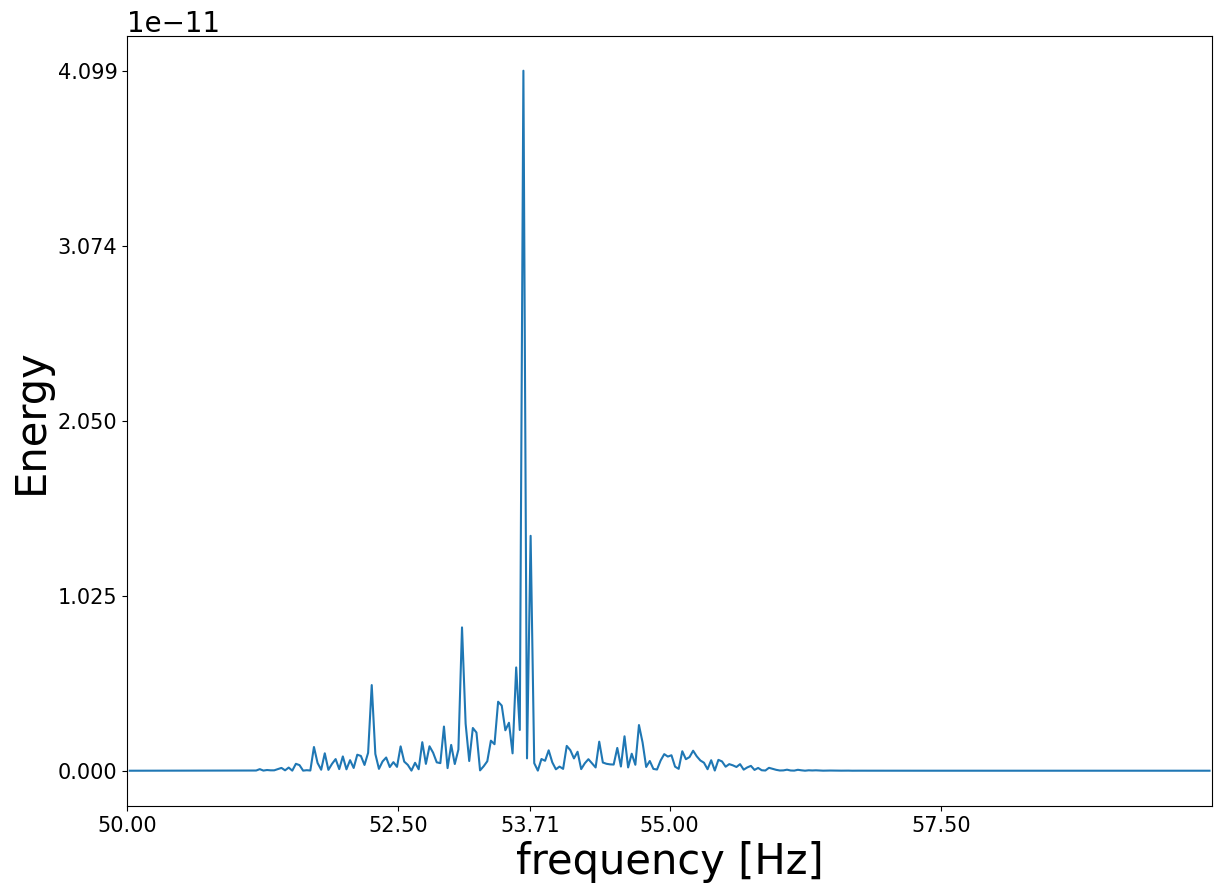

2023-05-11 21:14:57.193 | SUCCESS  | __main__:<module>:50 - DONE: train Data - Event 5 - filtered data
2023-05-11 21:14:57.194 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 1


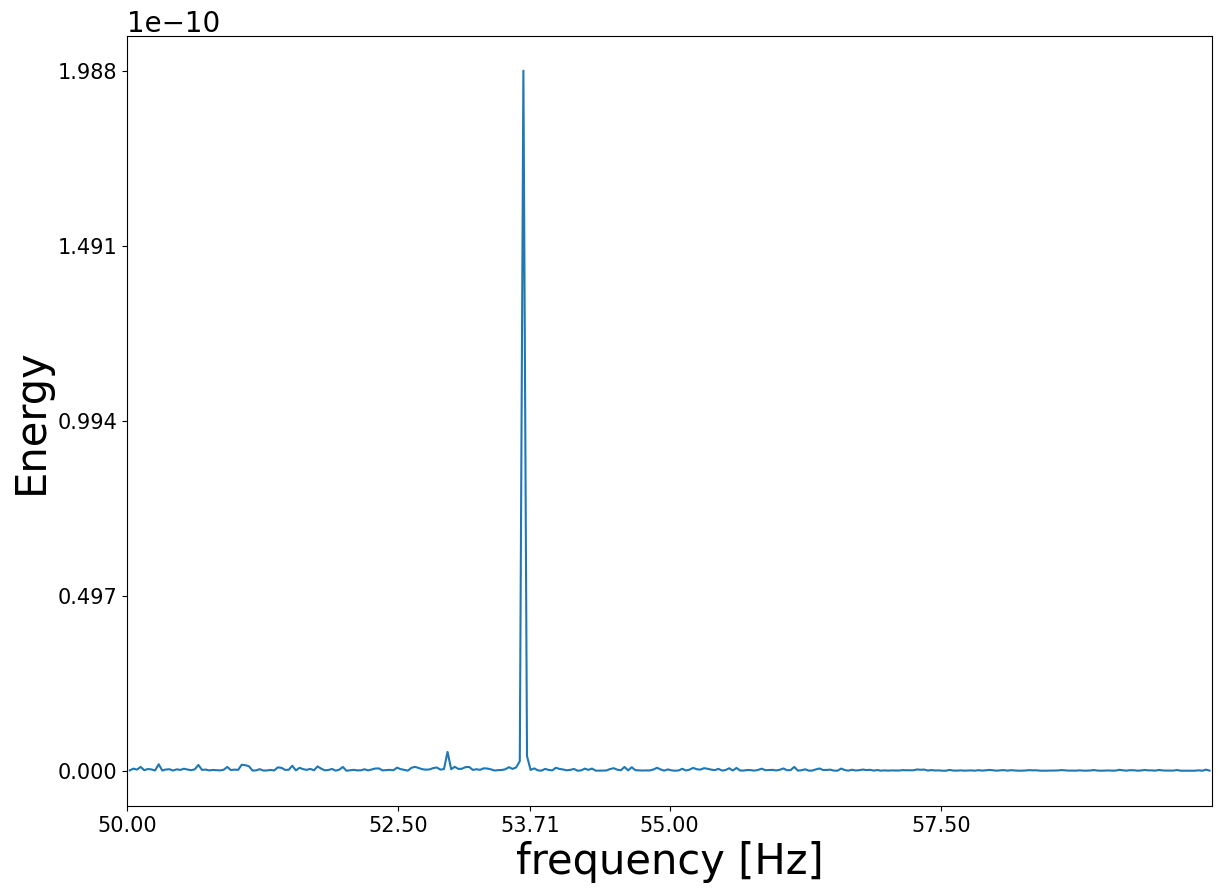

2023-05-11 21:14:57.445 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 1 - raw data
2023-05-11 21:14:57.446 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 1


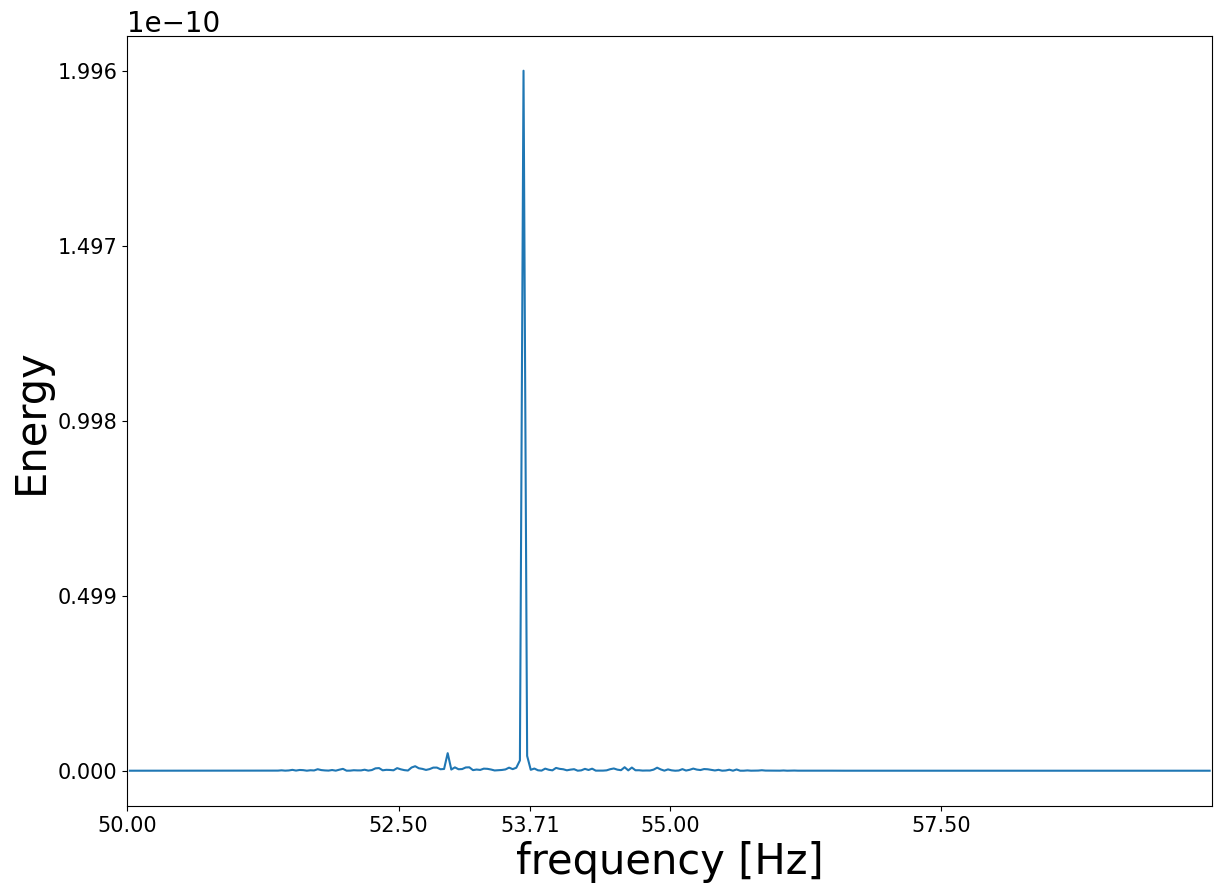

2023-05-11 21:14:57.665 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 1 - filtered data
2023-05-11 21:14:57.666 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 2


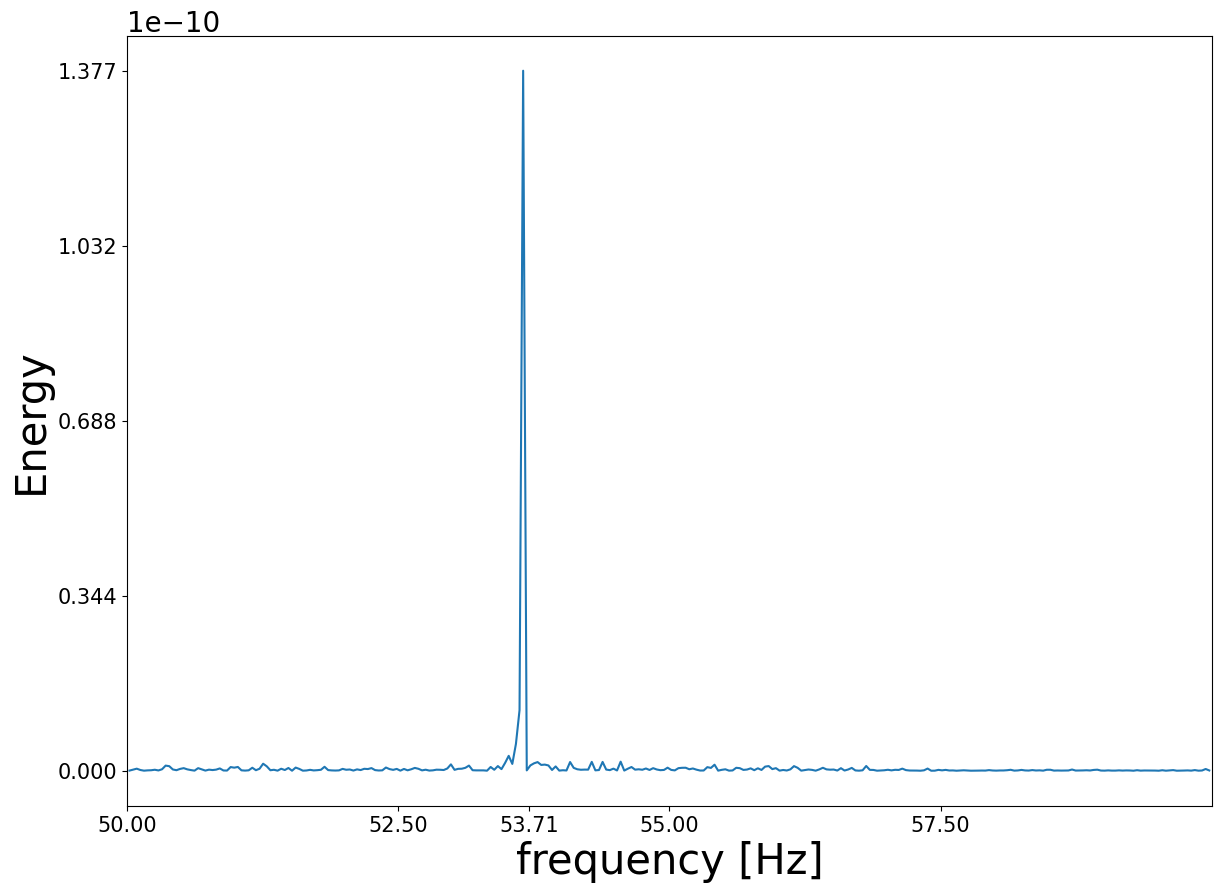

2023-05-11 21:14:57.887 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 2 - raw data
2023-05-11 21:14:57.888 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 2


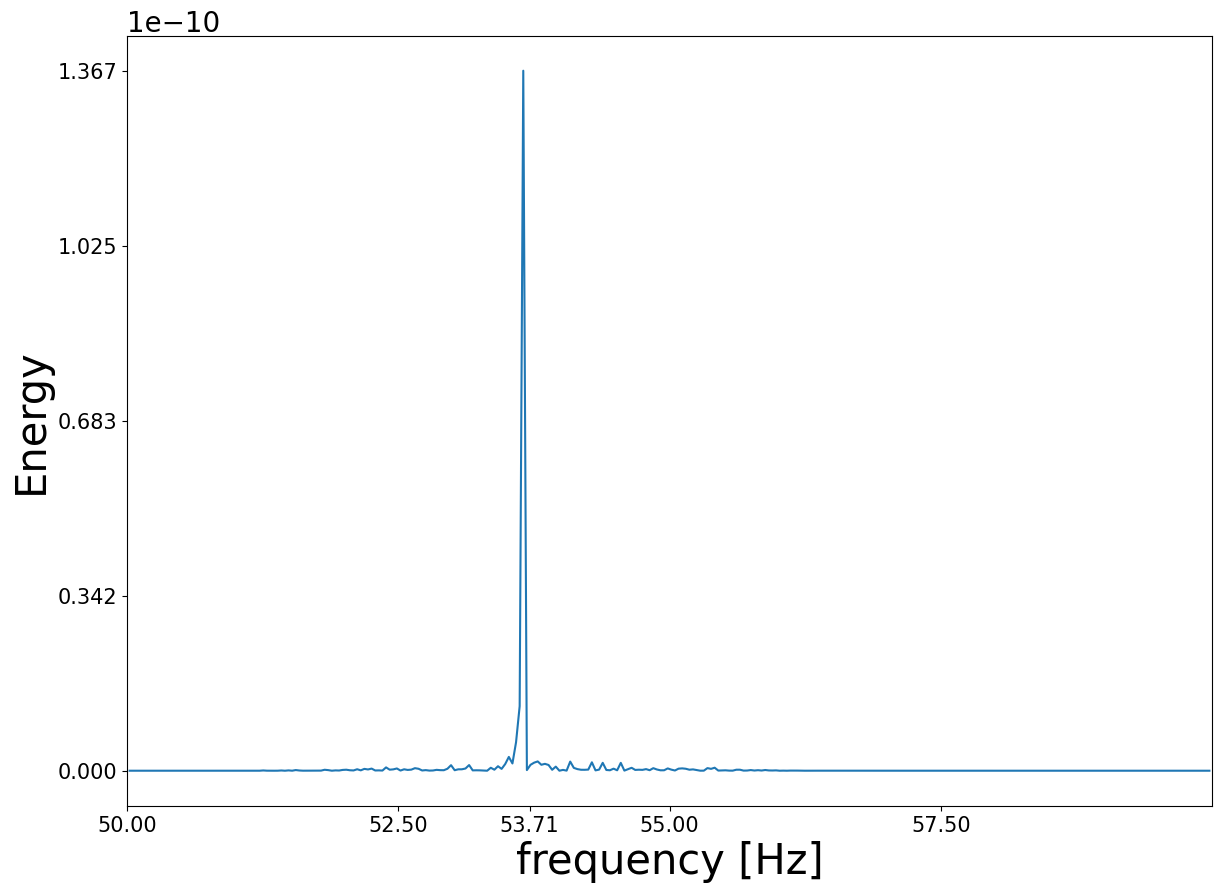

2023-05-11 21:14:58.099 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 2 - filtered data
2023-05-11 21:14:58.099 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 3


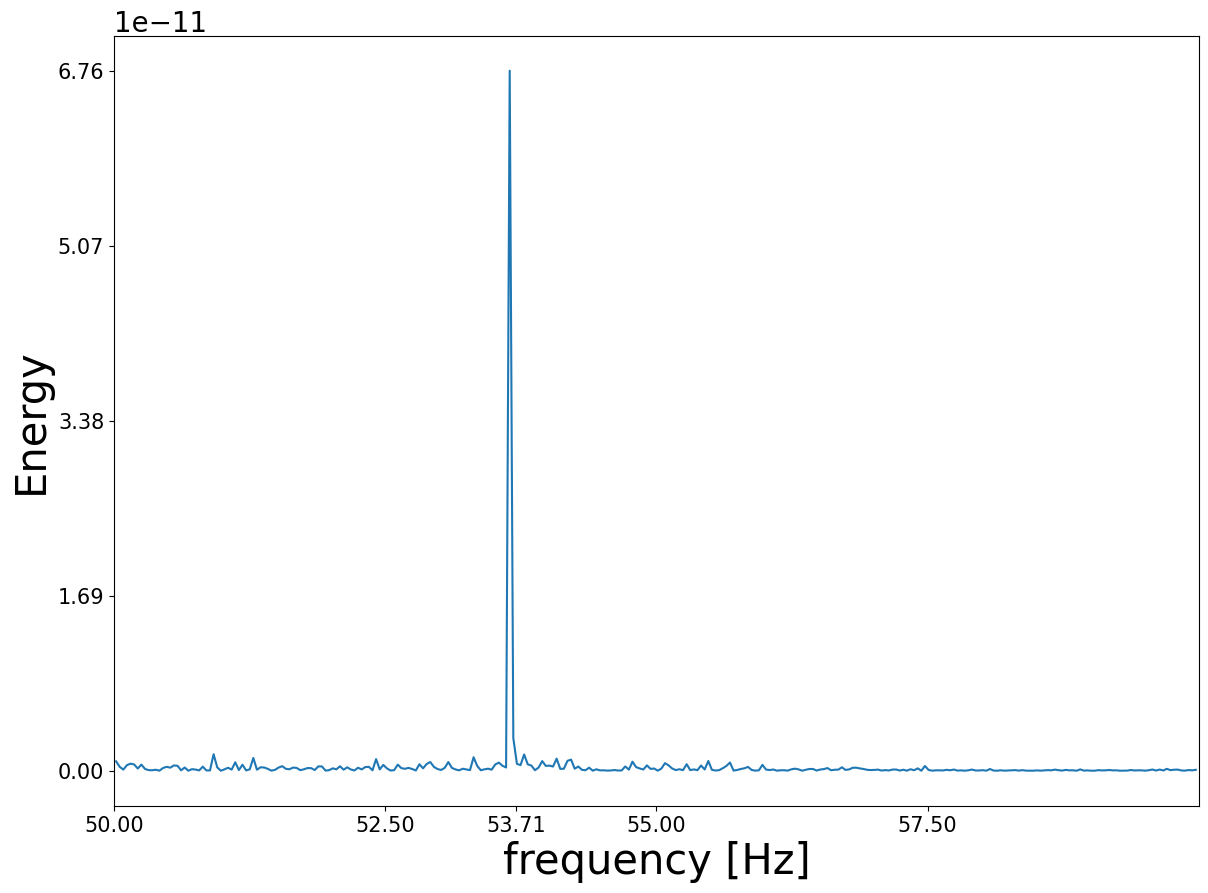

2023-05-11 21:14:58.312 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 3 - raw data
2023-05-11 21:14:58.313 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 3


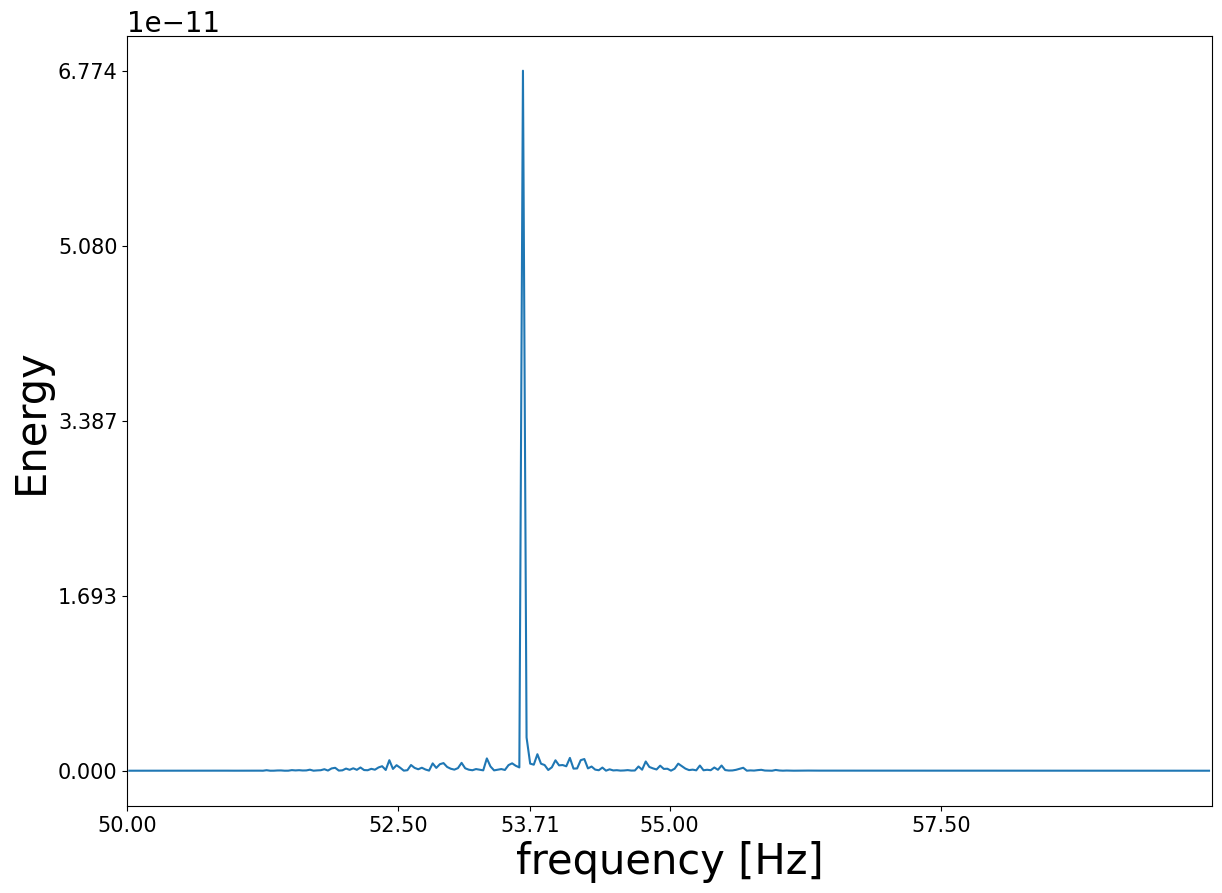

2023-05-11 21:14:58.525 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 3 - filtered data
2023-05-11 21:14:58.525 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 4


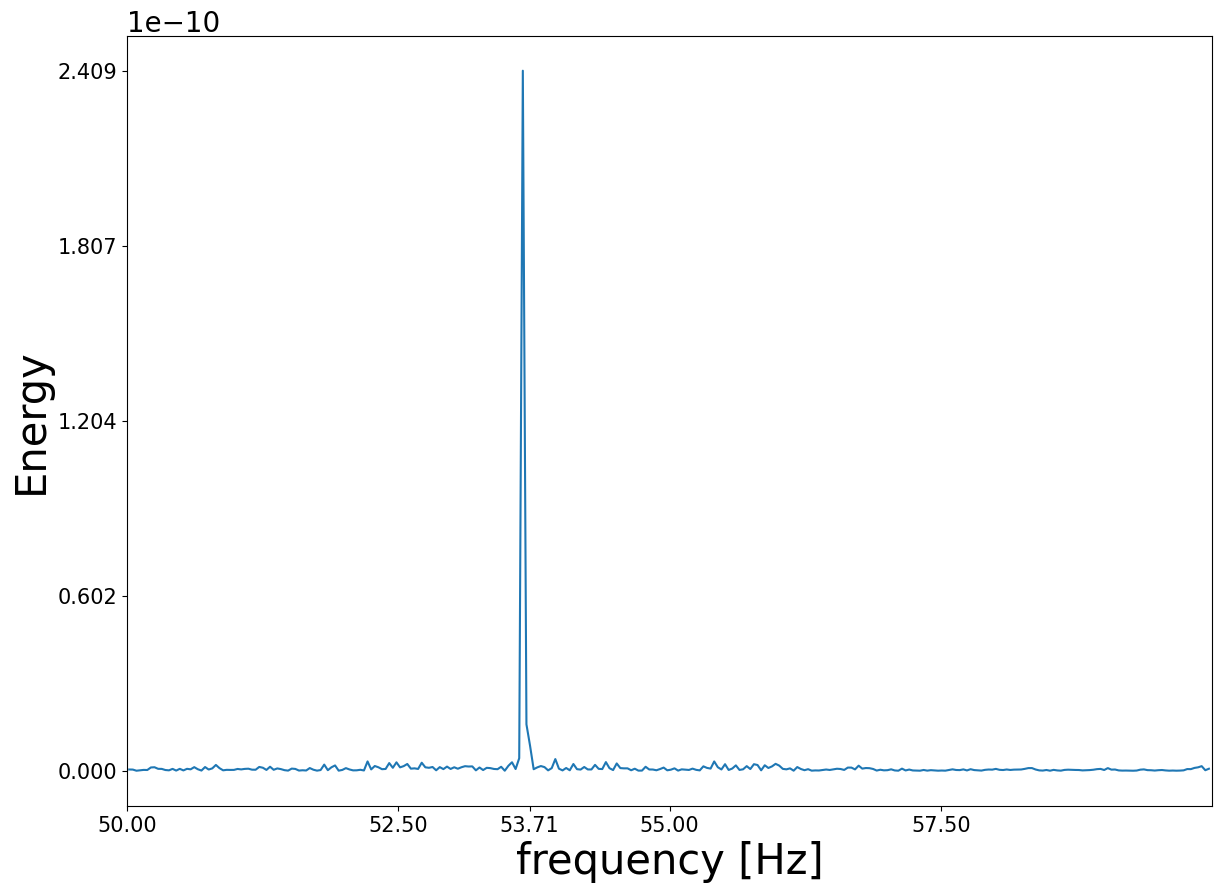

2023-05-11 21:14:58.739 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 4 - raw data
2023-05-11 21:14:58.739 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 4


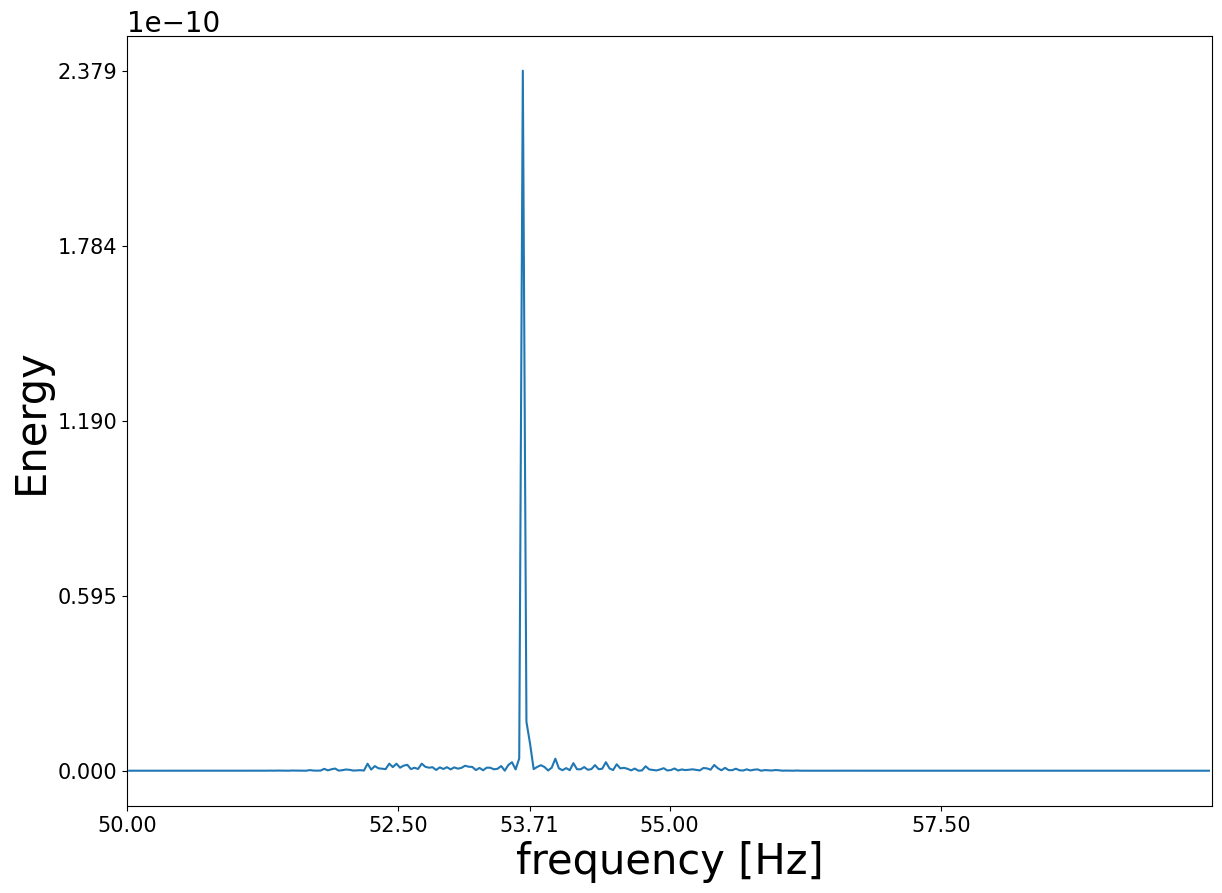

2023-05-11 21:14:58.972 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 4 - filtered data
2023-05-11 21:14:58.972 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 5


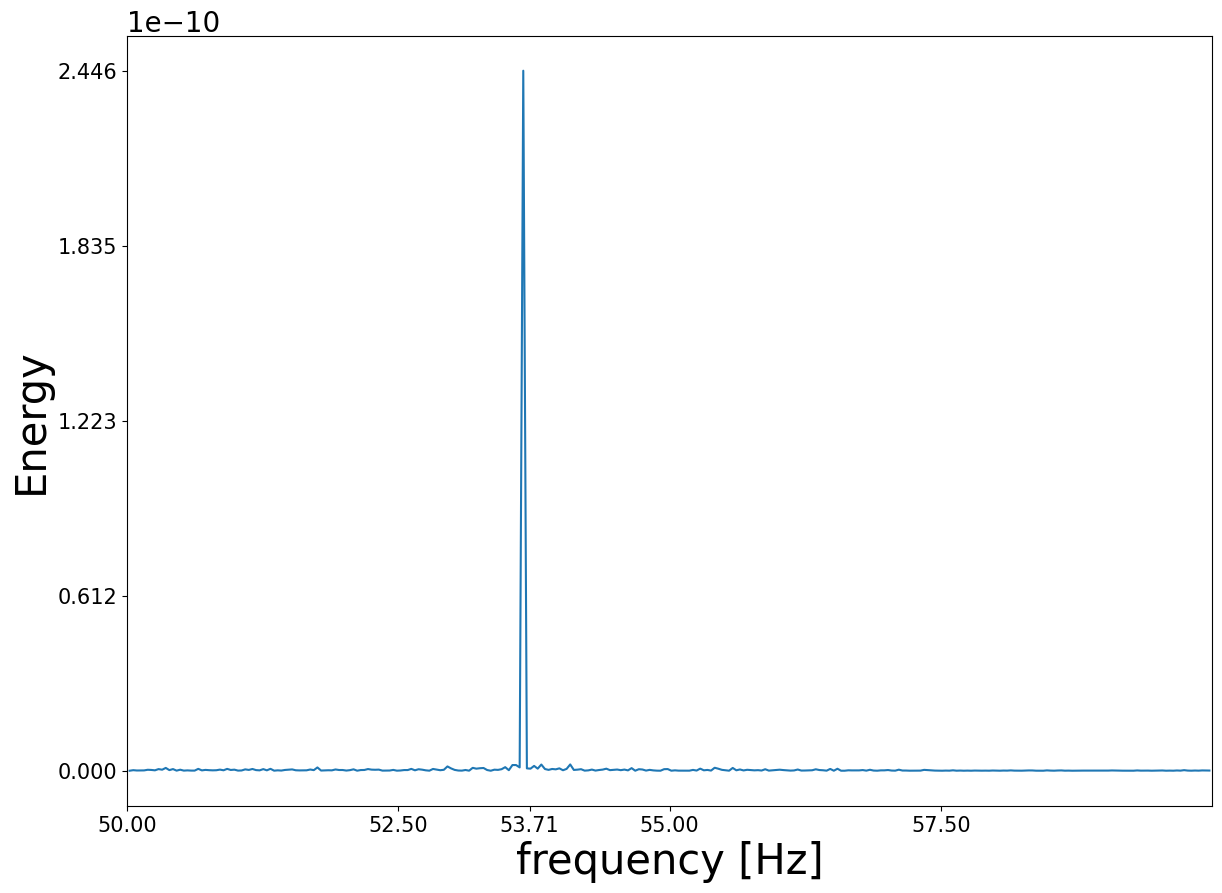

2023-05-11 21:14:59.227 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 5 - raw data
2023-05-11 21:14:59.227 | INFO     | __main__:<module>:7 - Test Data - Selecting Event 5


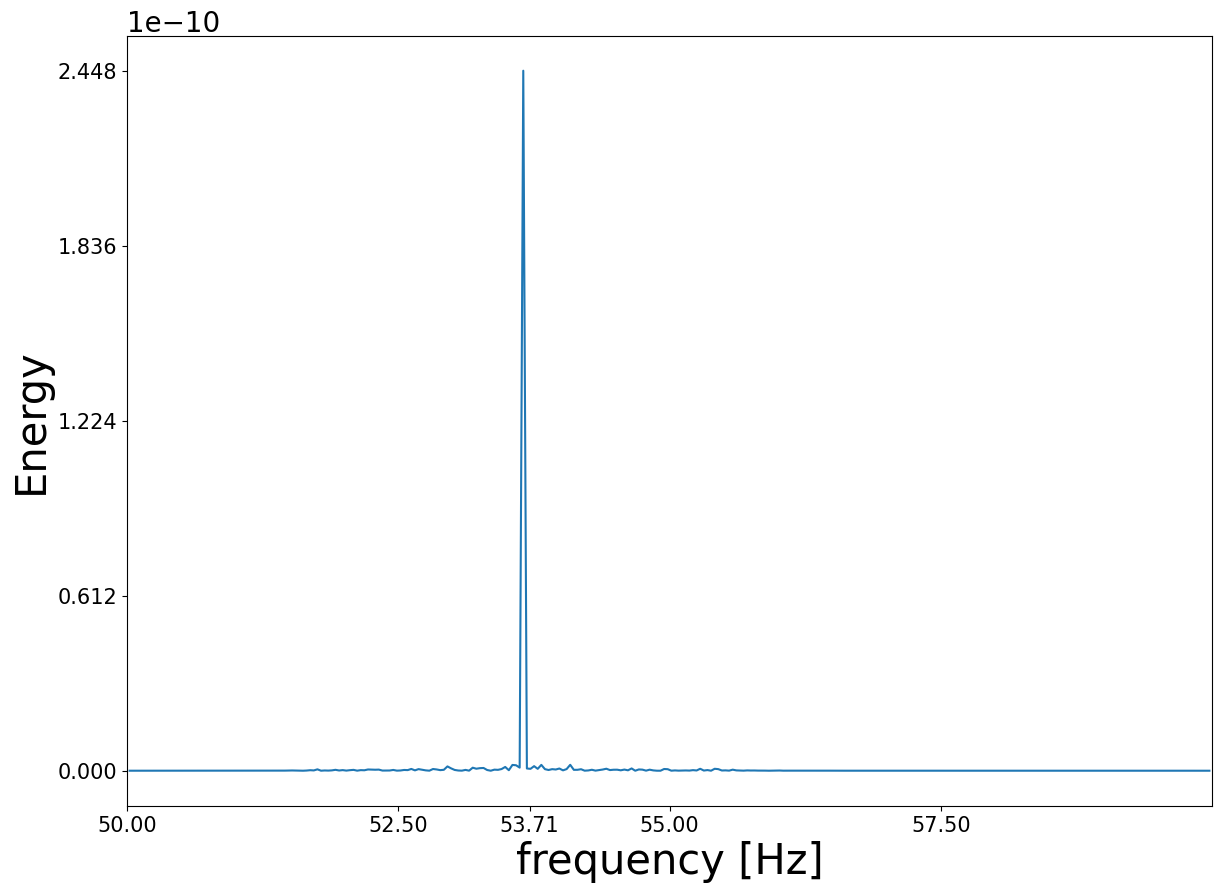

2023-05-11 21:14:59.463 | SUCCESS  | __main__:<module>:50 - DONE: test Data - Event 5 - filtered data


In [44]:
sliding_window_size = 3.0

for name_data, data in {"train": data_train, "test": data_test}.items():
    for event_number in range(1, 6):
        for column in ["Inferior_colliculus", "filtered_Inferior_colliculus"]:
            
            logger.info(f'{name_data.capitalize()} Data - Selecting Event {event_number}')

            event_data = select_event_window(
                df=data, 
                event_name=f"event_{event_number}", 
                samples_before=0, 
                samples_after=0
            )
            
            frequency, intensity, angle = fft(x=event_data.loc[:, column].to_numpy(), fs=FrequencySampling)
            
            title = f'FFT_{name_data}_event_{event_number}_' + \
                f'{["raw", "filtered"][int(column.startswith("filtered"))]}.jpg'
            
            fig = plt.figure(figsize=(14,10))

            ax = fig.add_subplot(111)

            y = (intensity**2)[(frequency>=50)&(frequency<=60)]
            x = frequency[(frequency>=50)&(frequency<=60)]
            
            ax.plot(x, y)

            ax.set_xlabel("frequency [Hz]", fontsize=30)
            ax.set_ylabel('Energy', fontsize=30)
            t = ax.yaxis.get_offset_text()
            t.set_size(20)
            plt.xticks(np.sort(np.append(np.arange(50, 60, 2.5), [53.71])), fontsize=15)
            plt.yticks(np.linspace(min(y), max(y), 5), fontsize=15)
            plt.xlim([50, 60])
            plt.savefig(
                title,
                format="jpg",
                bbox_inches='tight', 
                dpi=150
            )
            
            plt.show()
            
            ax.clear()
            plt.close(fig)
            del frequency, intensity, angle
            
            logger.success(f'DONE: {name_data} Data - Event {event_number} - '+ \
            f'{["raw", "filtered"][int(column.startswith("filtered"))]} data')

# FFT

2023-05-11 21:14:59.489 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 1
2023-05-11 21:14:59.496 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 2
2023-05-11 21:14:59.504 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 3
2023-05-11 21:14:59.511 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 4
2023-05-11 21:14:59.519 | INFO     | __main__:<module>:38 - Train Data - Selecting Event 5


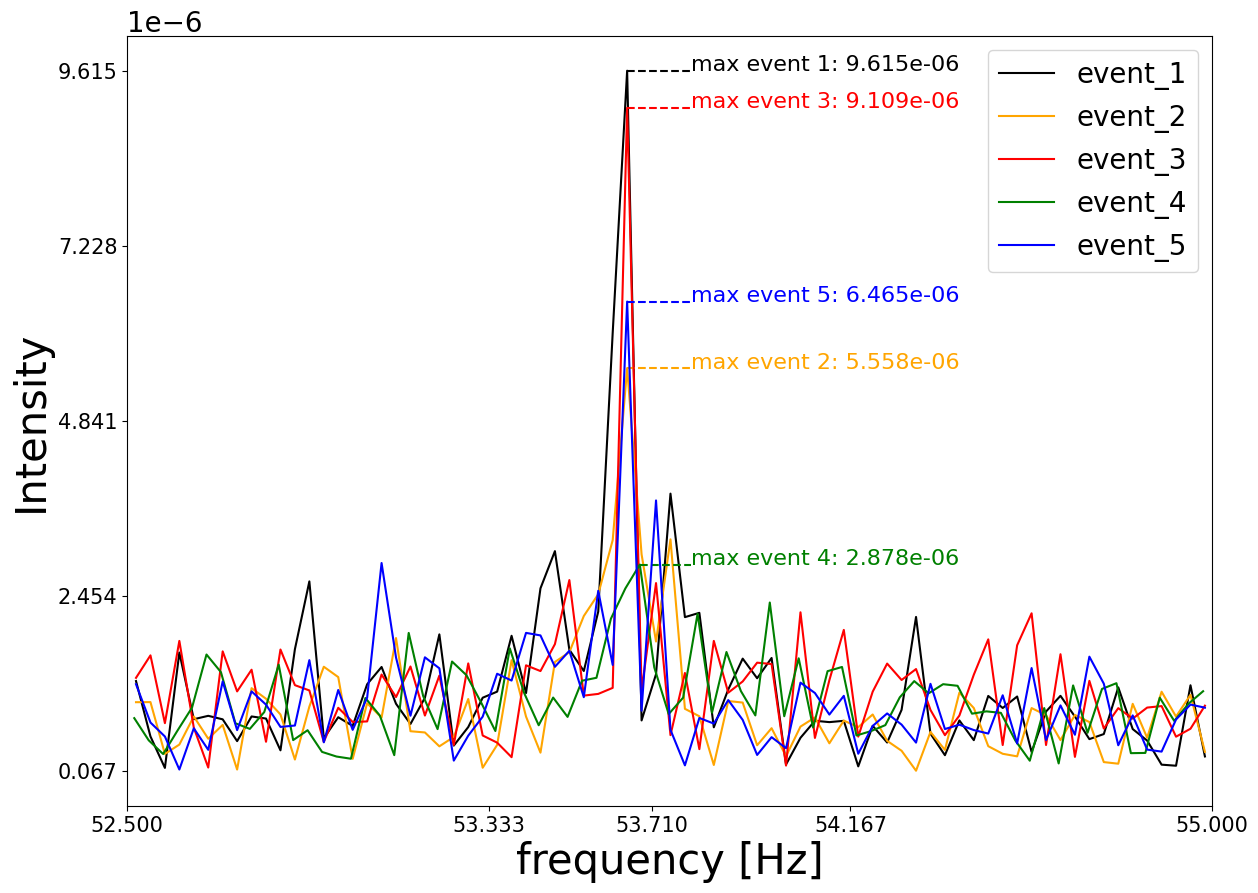

2023-05-11 21:14:59.891 | SUCCESS  | __main__:<module>:100 - DONE: train Data - Event 5 - raw data
2023-05-11 21:14:59.901 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 1
2023-05-11 21:14:59.909 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 2
2023-05-11 21:14:59.919 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 3
2023-05-11 21:14:59.931 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 4
2023-05-11 21:14:59.942 | INFO     | __main__:<module>:38 - Test Data - Selecting Event 5


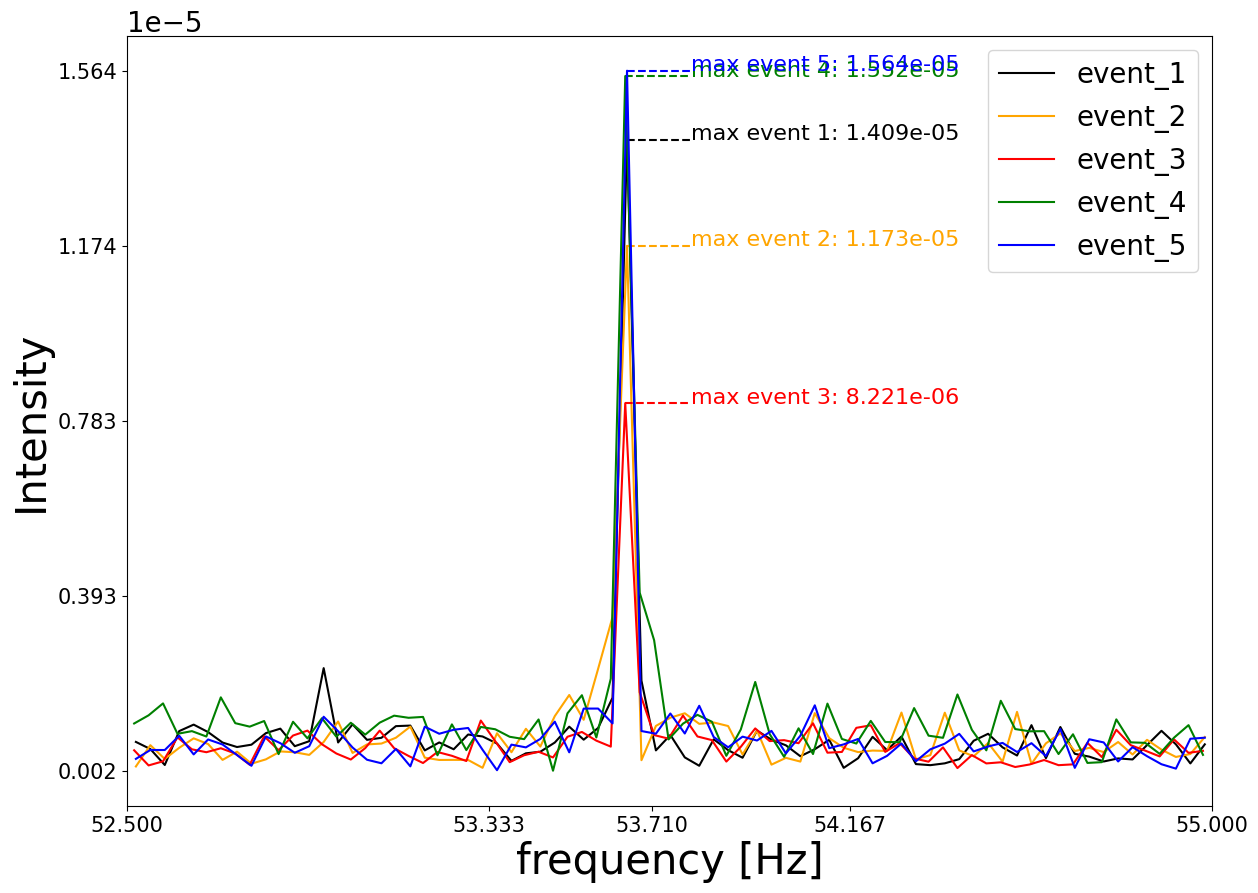

2023-05-11 21:15:00.287 | SUCCESS  | __main__:<module>:100 - DONE: test Data - Event 5 - raw data
/tmp/ipykernel_7875/914489825.py:138: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  exponent = st.mode(exponents).mode[0]


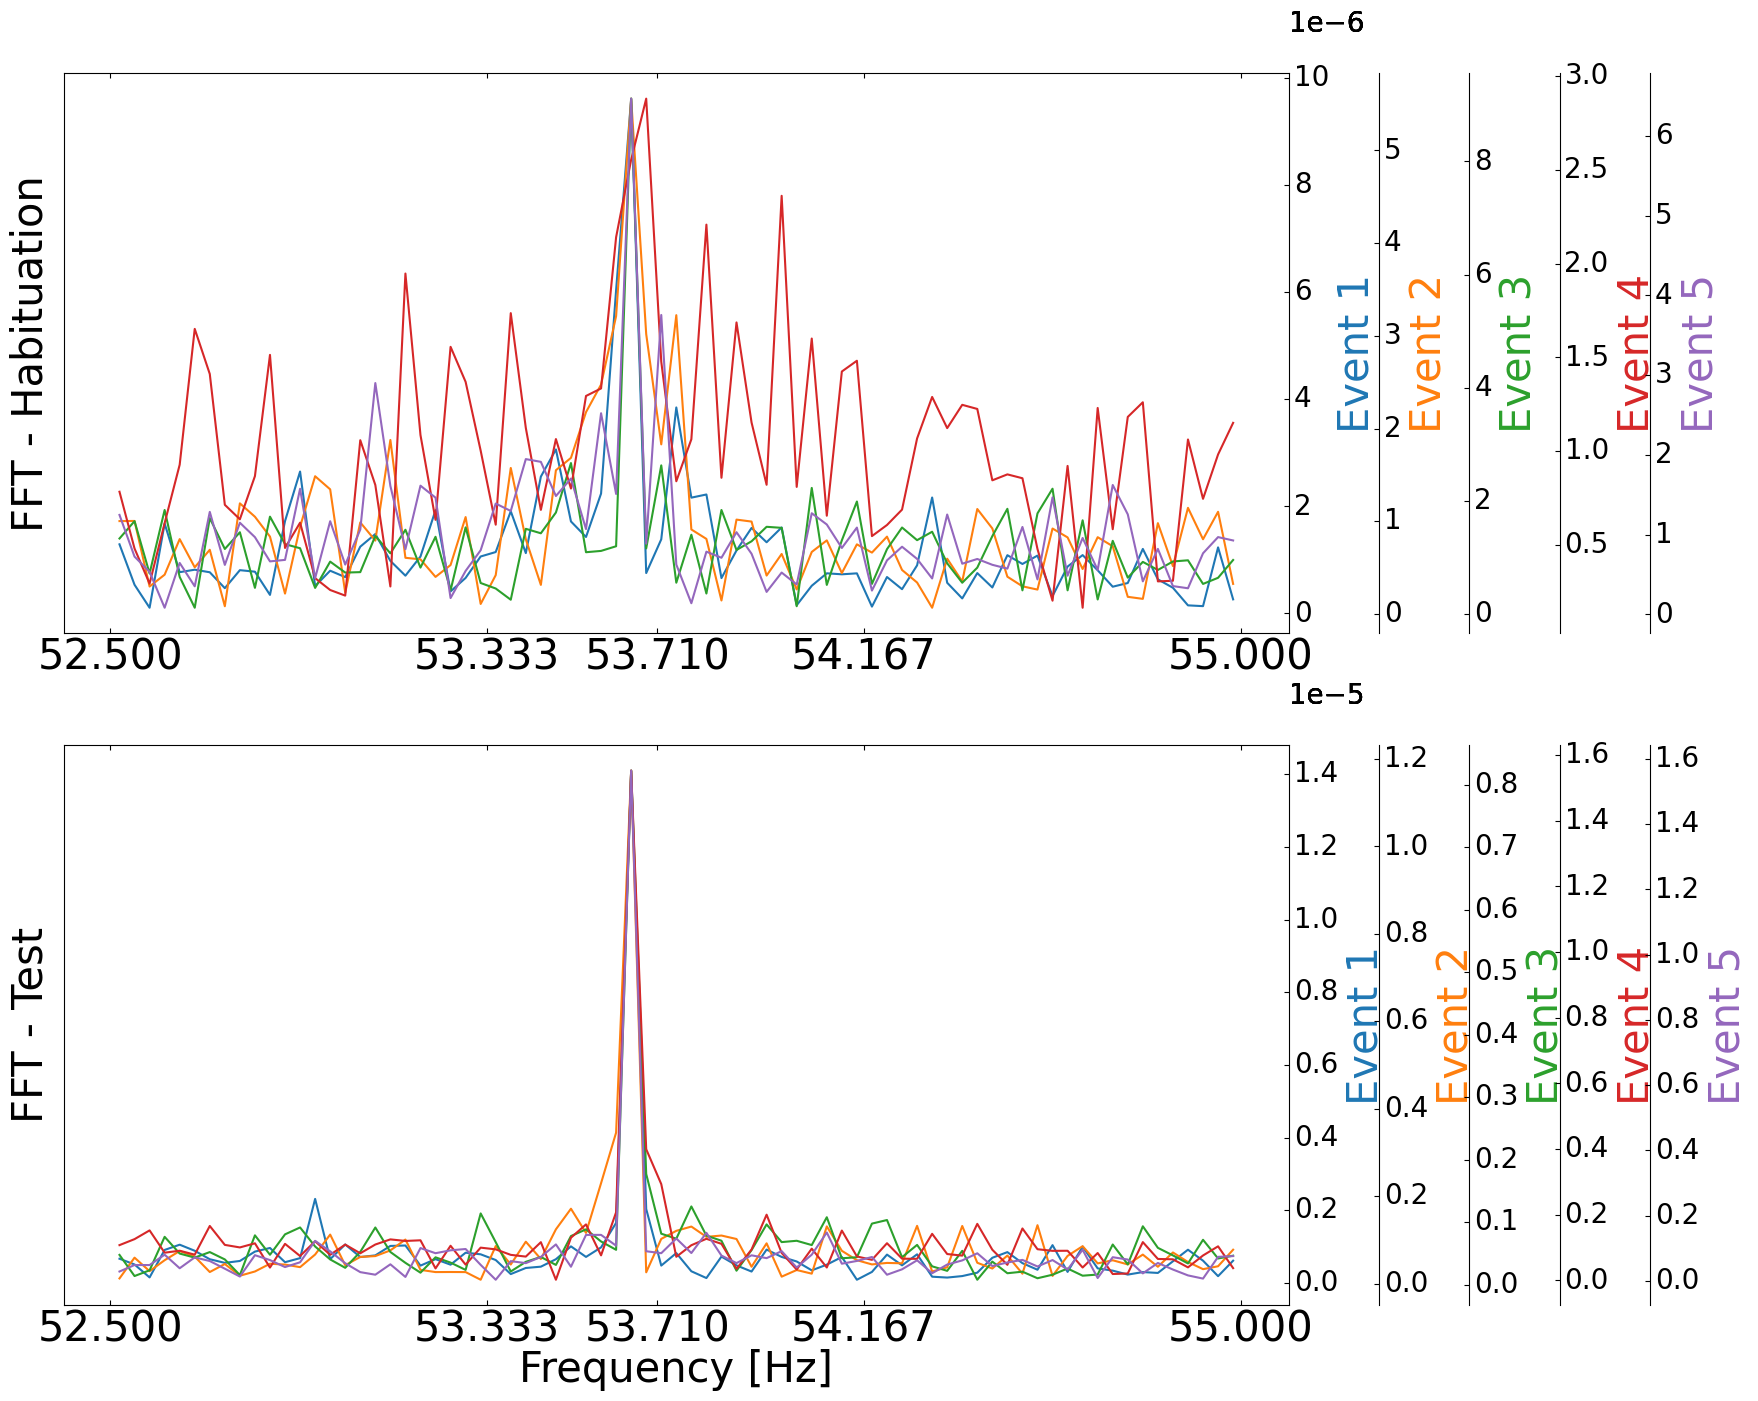

2023-05-11 21:15:01.468 | SUCCESS  | __main__:<module>:154 - Done plotting both experiments alongside!


In [45]:

plot_both = True
sliding_window_size = 3.0

lim = (52.5, 55)
ymin = float("Inf")
ymax = float("-Inf")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

colors = ["black", "orange", "red", "green", "blue"]

ffts = {
    "train": {
        "x": None,
        1: None,
        2: None,
        3: None,
        4: None,
        5: None
    },
    "test": {
        "x": None,
        1: None,
        2: None,
        3: None,
        4: None,
        5: None
    }
}

for name_data, data in {"train": data_train, "test": data_test}.items():
    fig = plt.figure(figsize=(14,10))

    ax = fig.add_subplot(111)

    for color, event_number in zip(colors, range(1, 6)):
        for column in ["Inferior_colliculus"]:
            
            logger.info(f'{name_data.capitalize()} Data - Selecting Event {event_number}')

            event_data = select_event_window(
                df=data, 
                event_name=f"event_{event_number}", 
                samples_before=0, 
                samples_after=0
            )
            
            frequency, intensity, angle = fft(x=event_data.loc[:, column].to_numpy(), fs=FrequencySampling)
            y = (intensity)[(frequency>=lim[0])&(frequency<=lim[1])]
            x = frequency[(frequency>=lim[0])&(frequency<=lim[1])]
            
            
            current_y_max = y.max()
            ymin = min(ymin, y.min())
            ymax = max(ymax, current_y_max)
            
            ax.plot(x, y, label=f"event_{event_number}", color=color)
            if ffts[name_data]["x"] is None:
                ffts[name_data]["x"] = x
            ffts[name_data][event_number] = y

            ftext = str(current_y_max).split('.')[0] + "." + \
                    str(current_y_max).split('.')[1].split('e')[0][:3] + "e" + \
                    str(current_y_max).split('.')[1].split('e')[1]
            
            # place a text box in upper left in axes coords
            ax.text(
                53.8, 
                current_y_max, 
                f"max event {event_number}: {ftext}", 
                fontsize=16, 
                color=color
            )
            
            plt.plot(
                [x[np.argwhere(y==current_y_max)[0][0]], 53.8], 
                [current_y_max]*2, 
                '--', 
                color=color
            )
    
    ax.set_xlabel("frequency [Hz]", fontsize=30)
    ax.set_ylabel('Intensity', fontsize=30)
    t = ax.yaxis.get_offset_text()
    t.set_size(20)
    
    plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])), fontsize=15)
    plt.yticks(np.linspace(ymin, ymax, 5), fontsize=15)
    plt.xlim([lim[0], lim[1]])
    plt.legend(prop={'size': 20})
    plt.savefig(
        f"all_FFT_{name_data}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()
    
    
    logger.success(f'DONE: {name_data} Data - Event {event_number} - '+ \
    f'{["raw", "filtered"][int(column.startswith("filtered"))]} data')

    
# ------------------------------------------------------------------------------------------
if plot_both:
    fontsize = 25
    number_of_axis = 5
    offset = 65
    fig_axis = plt.figure(figsize=(14, 16))
    for line, experiment, experiment_description in zip([1, 2], ["train", "test"], ["Habituation", "Test"]):
        host = host_subplot(int(f"21{line}"), axes_class=AA.Axes, figure=fig_axis)
        plt.subplots_adjust(right=1)

        axis = [host.twinx() for _ in range(number_of_axis)]

        host.set_ylabel(f"FFT - {experiment_description}", fontsize=fontsize)
        if line == 2:
            host.set_xlabel("Frequency [Hz]", fontsize=fontsize)
        host.set_yticks([], [])

        for i, par in enumerate(axis):
            if i > 0:
                new_fixed_axis = par.get_grid_helper().new_fixed_axis
                par.axis["right"] = new_fixed_axis(loc="right", axes=par,
                                                    offset=((i)*offset, 0))

            par.axis["right"].toggle(all=True)

            par.set_ylabel(f"Event {1+i}")

            p, = par.plot(ffts[experiment]["x"], ffts[experiment][i+1], label=f"event_{i+1}")

            par.axis["right"].label.set_color(p.get_color())

        plt.draw()

        exponents = [int(par._axislines['right'].offsetText._text.split('e')[1].replace('−', '-')) for par in axis]
        exponent = st.mode(exponents).mode[0]

        for i, par in enumerate(axis):
            par.ticklabel_format(axis='y', style='sci', scilimits=(exponent, exponent), useOffset=False)
            par.set_xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])))
    
    plt.draw()
    
    plt.savefig(
        f"all_FFT_{name_data}_scaled.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=100
    )
    plt.show()
    
    logger.success("Done plotting both experiments alongside!")


## Espectro/Bispectro/Trispectro/Quadrispectro

In [46]:
load_already_calculated: bool = False

if load_already_calculated:
    data_to_process = "train"
    id_results: str = f"rato-{rat_number}-grupo-{group_number}-{data_to_process}"
    name_to_load = f'{BASE_PATH}/hosa_{id_results}_{"28-04-2023"}_article.csv'

    hosa_train = pd.read_csv(name_to_load)

    data_to_process = "test"
    id_results: str = f"rato-{rat_number}-grupo-{group_number}-{data_to_process}"
    name_to_load = f'{BASE_PATH}/hosa_{id_results}_{"28-04-2023"}_article.csv'

    hosa_test = pd.read_csv(name_to_load)

In [47]:
class TDQS(Tdhosa):

    def run_td4spectrum(self, signal_dict: np.ndarray | pd.Series): 
        event, signal = list(signal_dict.items())[0]
        return {
            event: self.run_tdqs(
                signal
            )
        }

In [48]:
if not load_already_calculated:

    data_dict = {
        "train": data_train,
        "test": data_test
    }

    hosa_train = None
    hosa_test = None

    for data_to_process in ("train", "test"):

        id_results: str = f"rato-{rat_number}-grupo-{group_number}-{data_to_process}"

        frequency_array = np.arange(start=4, stop=60, step=0.01)

        TDQS_PARAMETERS = {
            "frequency_array": frequency_array,
            "phase_step": 0.01
        }


        data = data_dict[data_to_process]

        events = data.event.unique()
        events = events[events != "base"]

        logger.info(f"Events in the data: {events}")

        df_amps = pd.DataFrame()
        df_phases = pd.DataFrame()

        logger.info("Processing the tdts... This may take a while...\n")
        start_time = perf_counter()

        # Process the tdts for each channel, in parallel

        time = data.Time.to_numpy()
        TimeSampling = round(np.mean(time[1:] - time[:-1]), 6)
        FrequencySampling = 1.0/TimeSampling

        tdqs_object = TDQS(
            frequency_sampling=FrequencySampling,
            frequency_array=TDQS_PARAMETERS.get("frequency_array"),
            fmin=TDQS_PARAMETERS.get("fmin"),
            fmax=TDQS_PARAMETERS.get("fmax"),
            freq_step=TDQS_PARAMETERS.get("freq_step"),
            phase_step=TDQS_PARAMETERS["phase_step"]
        )

        f = lambda x: tdqs_object.run_td4spectrum(x)

        with Pool() as pool:

            for result in pool.map(f, [{event: select_event_window(
                df=data,
                event_name=event,
                samples_before=0,
                samples_after=0
            ).loc[:, f"{'norm_'*norm}Inferior_colliculus"].to_numpy()} for event in events]):

                event, result_data = list(result.items())[0]
                (
                    frequency_array, 
                    spectrum, 
                    phase_spectrum, 
                    bispectrum, 
                    phase_bispectrum, 
                    trispectrum, 
                    phase_trispectrum,
                    tetraspectrum,
                    phase_tetraspectrum         
                ) = result_data

                if "frequency" not in df_amps.columns:
                    df_amps = df_amps.assign(frequency=frequency_array)

                df_amps = df_amps.assign(**{f"tds_amp_{event}": spectrum})
                df_phases = df_phases.assign(**{f"tds_phase_{event}": phase_spectrum})

                df_amps = df_amps.assign(**{f"tdbs_amp_{event}": bispectrum})
                df_phases = df_phases.assign(**{f"tdbs_phase_{event}": phase_bispectrum})

                df_amps = df_amps.assign(**{f"tdts_amp_{event}": trispectrum})
                df_phases = df_phases.assign(**{f"tdts_phase_{event}": phase_trispectrum})

                df_amps = df_amps.assign(**{f"tdqs_amp_{event}": tetraspectrum})
                df_phases = df_phases.assign(**{f"tdqs_phase_{event}": phase_tetraspectrum})


        hosa_df = pd.concat([df_amps, df_phases], axis=1)

        if data_to_process == "train":
            df_amps_train = df_amps
            df_phases_train = df_phases
            hosa_train = hosa_df
        elif data_to_process == "test":
            df_amps_test = df_amps
            df_phases_test = df_phases
            hosa_test = hosa_df

        hosa_df.to_csv(f'{BASE_PATH}/hosa_{id_results}_{"-".join(str(pendulum.today()).split("T")[0].split("-")[::-1])}_article.csv', index=False)

        end_time = perf_counter()

        logger.success(f"Done processing {data_to_process} data. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")

In [49]:
is_amp = np.vectorize(lambda x: "amp" in x)

x = hosa_train.loc[:, "frequency"].to_numpy()

low_lim = 53.71-2
high_lim = 53.71 + 2

df_amps_train = hosa_train.loc[(x >= low_lim)&(x<=high_lim), is_amp(hosa_train.columns)]
df_amps_test = hosa_test.loc[(x>=low_lim)&(x<=high_lim), is_amp(hosa_train.columns)]

x = x[(x>=low_lim)&(x<=high_lim)]

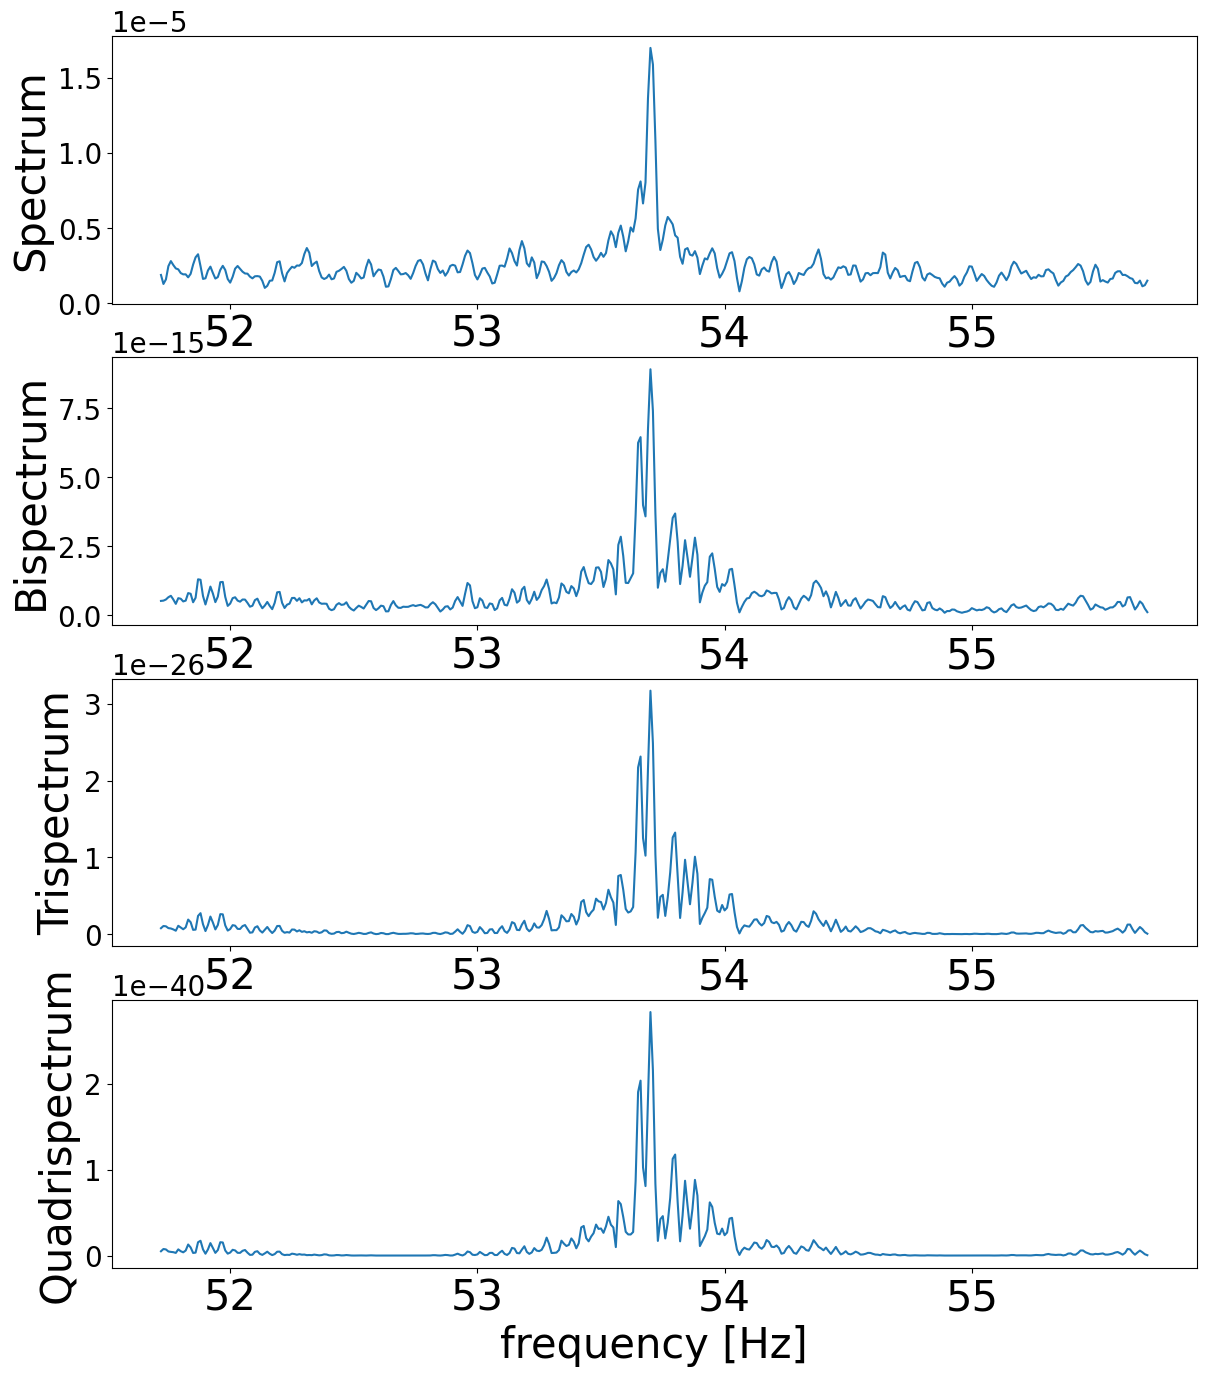

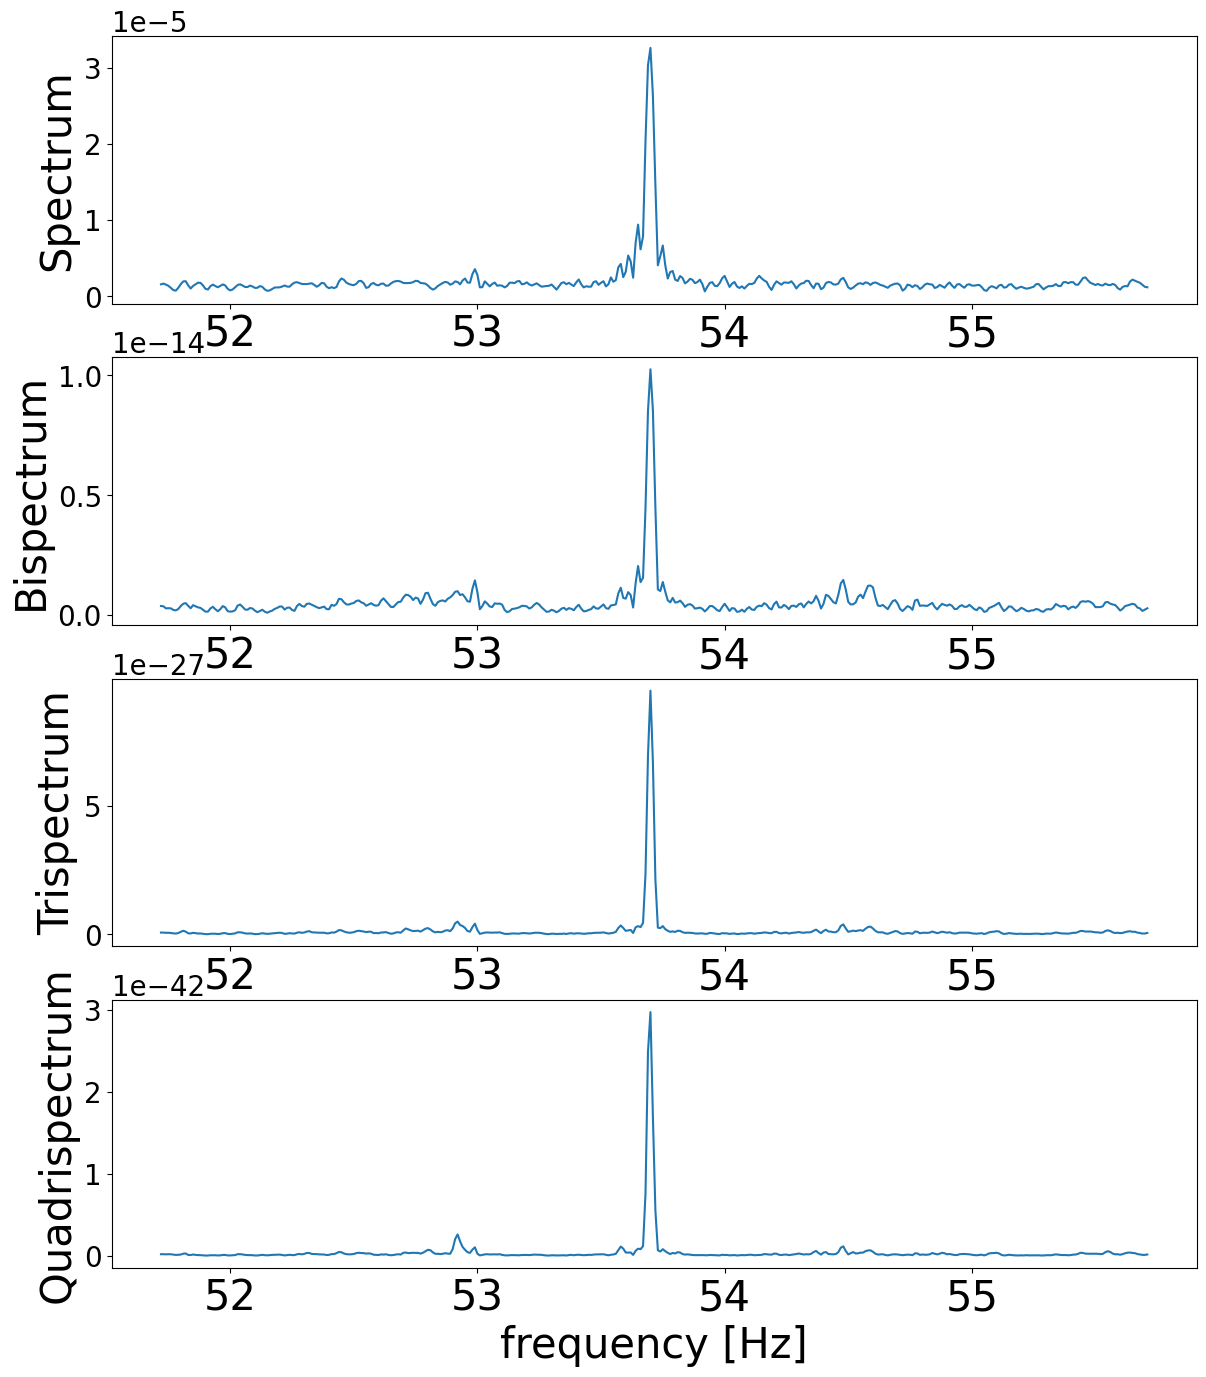

In [50]:
for title, amplitudes_df in {"Train": df_amps_train, "Test": df_amps_test}.items():

    tds = np.zeros(amplitudes_df.shape[0])
    tdbs = tds.copy()
    tdts = tds.copy()
    tdqs = tds.copy()
    
    
    
    for column in amplitudes_df.columns:
        if column.startswith("tds"):
            tds += amplitudes_df.loc[:, column].to_numpy()
        elif column.startswith("tdbs"):
            tdbs += amplitudes_df.loc[:, column].to_numpy()
        elif column.startswith("tdts"):
            tdts += amplitudes_df.loc[:, column].to_numpy()
        elif column.startswith("tdqs"):
            tdqs += amplitudes_df.loc[:, column].to_numpy()
            
    fig = plt.figure(figsize=(14,16))

    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)

    

    ax1.plot(x, tds)
    ax2.plot(x, tdbs)
    ax3.plot(x, tdts)
    ax4.plot(x, tdqs)
    
    ax1.set_ylabel('Spectrum', fontsize=30)
    ax2.set_ylabel('Bispectrum', fontsize=30)
    ax3.set_ylabel('Trispectrum', fontsize=30)
    ax4.set_ylabel('Quadrispectrum', fontsize=30)
    ax4.set_xlabel("frequency [Hz]", fontsize=30)
    
    plt.show()

[52.71 53.71 54.71]


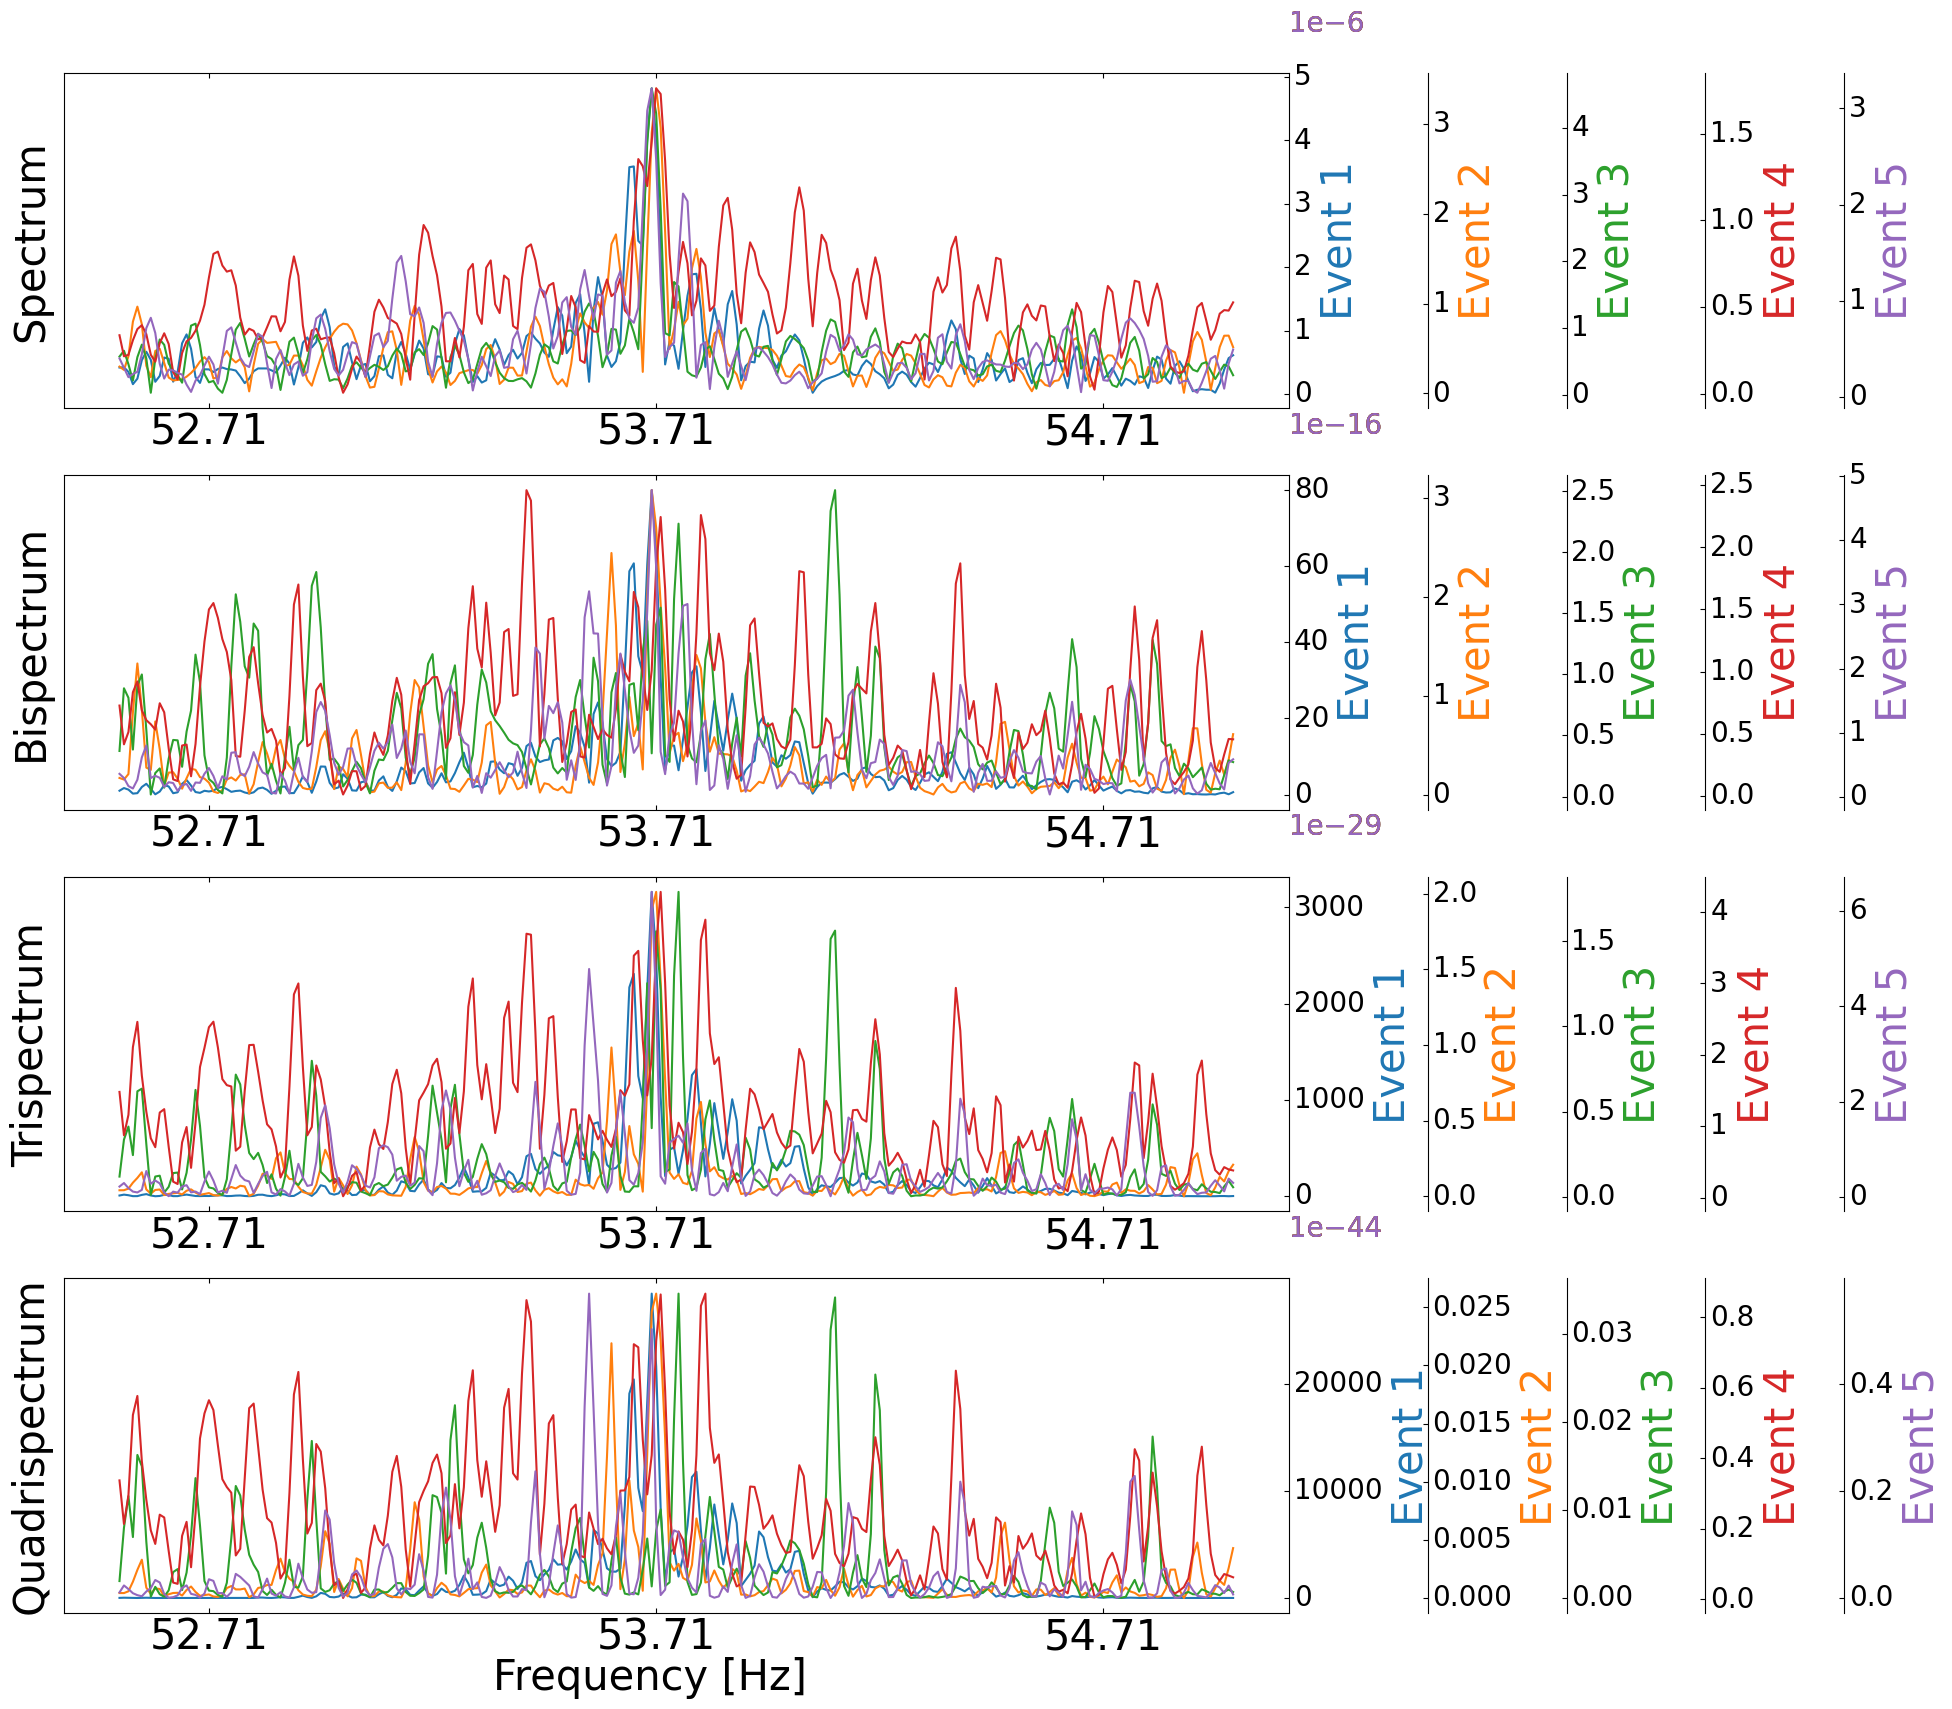

[52.71 53.71 54.71]


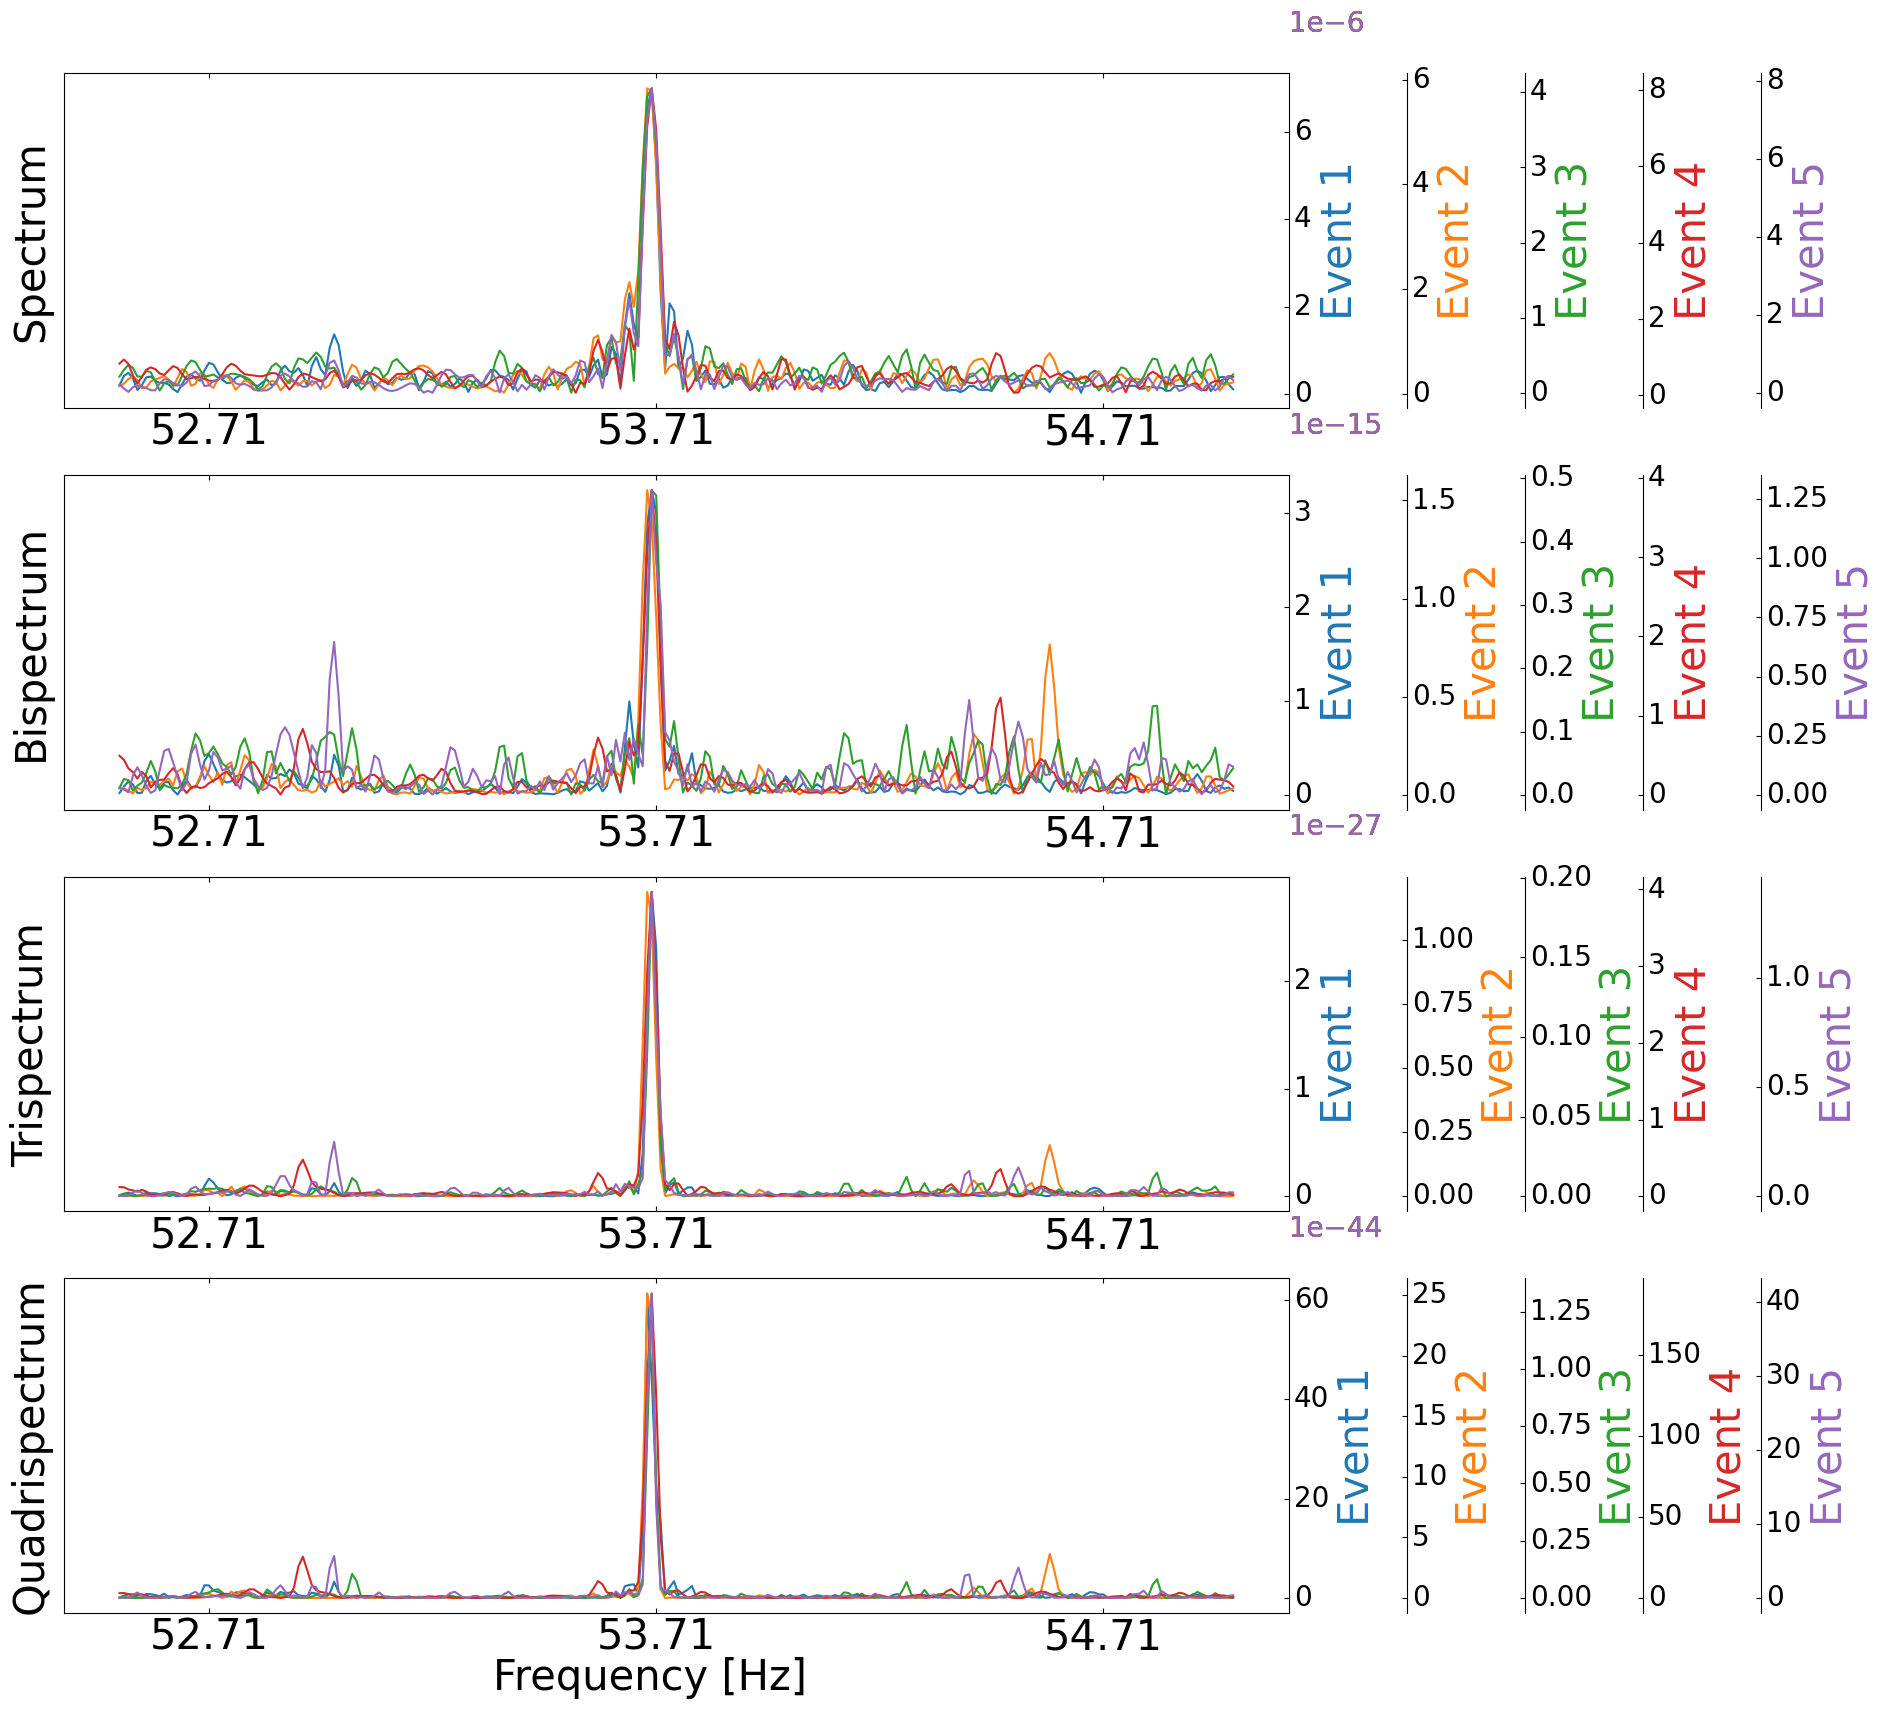

In [51]:
standardize = False
plt_scaled_plot = True

for data_to_process, df in {"train": hosa_train, "test": hosa_test}.items():

    band_to_plot = (52.5, 55)

    df = df[(df.iloc[:, 0]>=band_to_plot[0])&(df.iloc[:, 0]<=band_to_plot[1])]

    spectrum_colum_amp = [column for column in df.columns if column.startswith("tds_amp")]
    bispectrum_colum_amp = [column for column in df.columns if column.startswith("tdbs_amp")]
    trispectrum_colum_amp = [column for column in df.columns if column.startswith("tdts_amp")]
    tetraspectrum_colum_amp = [column for column in df.columns if column.startswith("tdqs_amp")]

    amplitudes_df = df.loc[:, spectrum_colum_amp + bispectrum_colum_amp + trispectrum_colum_amp + tetraspectrum_colum_amp]
    if standardize:
        amplitudes_df = amplitudes_df.apply(lambda x: standardize_array(x, scale_to_unit=True))

    spectrum_colum_phase = [column for column in df.columns if column.startswith("tds_phase")]
    bispectrum_colum_phase = [column for column in df.columns if column.startswith("tdbs_phase")]
    trispectrum_colum_phase = [column for column in df.columns if column.startswith("tdts_phase")]
    tetraspectrum_colum_phase = [column for column in df.columns if column.startswith("tdqs_phase")]

    phases_df = df.loc[:, spectrum_colum_phase + bispectrum_colum_phase + trispectrum_colum_phase + tetraspectrum_colum_phase]

    title = f"HOSA-rato-{rat_number}-grupo-{group_number}-{data_to_process}"

    ymin_spectrum = float('inf')
    ymax_spectrum = float('-inf')

    ymin_bispectrum = float('inf')
    ymax_bispectrum = float('-inf')

    ymin_trispectrum = float('inf')
    ymax_trispectrum = float('-inf')
    
    ymin_tetraspectrum = float('inf')
    ymax_tetraspectrum = float('-inf')
        
    plots_dict = {}

    for column in df.columns:

        if ("phase" in column) or ("frequency" in column):
            continue

        if column.startswith("tds"):
            experiment = "Spectrum"
        elif column.startswith("tdbs"):
            experiment = "Bispectrum"
        elif column.startswith("tdts"):
            experiment = "Trispectrum"
        elif column.startswith("tdqs"):
            experiment = "Quadrispectrum"

        if experiment not in plots_dict:
            plots_dict[experiment] = {}

        plot_number = int(column[-1]) - 1

        plots_dict[experiment][plot_number] = column

    number_of_axis = 5
    
    fig_axis = plt.figure(figsize=(14, 20))
    lines = [1, 2, 3, 4]
    experiments = ["Spectrum", "Bispectrum", "Trispectrum", "Quadrispectrum"]

    ticks = 53.71 + np.array([-1, 0, 1])
    print(ticks)
    for line, experiment in zip(lines, experiments):

        host = host_subplot(int(f"41{line}"), axes_class=AA.Axes, figure=fig_axis)
        plt.subplots_adjust(right=1)

        axis = [host.twinx() for _ in range(number_of_axis)]

        host.set_ylabel(experiment, fontsize=fontsize)

        host.set_xlabel(f"{'Frequency [Hz]'*(line == 4)}{'    '}")
        host.set_yticks([], [])

        for i, par in enumerate(axis):
            if data_to_process == "train":
                offset = 100
                # if line == 4 and i == 2:
                #     offset = 110
            else:
                offset = 85
        
            if i > 0:
                new_fixed_axis = par.get_grid_helper().new_fixed_axis
                par.axis["right"] = new_fixed_axis(loc="right", axes=par,
                                                    offset=((i)*offset, 0))

            par.axis["right"].toggle(all=True)

            par.set_ylabel(f"Event {(i%5)+1}", fontsize=fontsize)

            par.set_xticks(ticks)

            p, = par.plot(df.frequency, df.loc[:, plots_dict[experiment][i]])

            y_max = df.loc[:, plots_dict[experiment][i]].max()

            par.axis["right"].label.set_color(p.get_color())
            par.axis["right"].offsetText.set_color(p.get_color())
            
        plt.draw()

        exponents = [int(par._axislines['right'].offsetText._text.split('e')[1].replace('−', '-')) for par in axis]
        exponent = st.mode(exponents, keepdims=False).mode

        for i, par in enumerate(axis):
            if line == 4 and data_to_process == "train":
                exponent = -44
            if line == 4 and data_to_process == "test":
                exponent = -44
            par.ticklabel_format(axis='y', style='sci', scilimits=(exponent, exponent), useOffset=False)

    plt.draw()

    plt.savefig(
        f"hosa_{data_to_process}_scaled.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=100
    )
    plt.show()

# Statistical tests

## Gain 53.71Hz compared to the average amplitude between 50Hz and 60Hz (excluded the peak)

In [52]:
train_spectrum_peaks = [
    hosa_train.loc[
        (hosa_train.frequency>=53.70)&(hosa_train.frequency<=53.72), 
        plots_dict["Spectrum"][pn]
    ].max()/ \
    hosa_train.loc[
        (
            (hosa_train.frequency<=53.50)&(hosa_train.frequency>=50)
        )|(
            (hosa_train.frequency>=53.92)&(hosa_train.frequency<=60)
        ), 
        plots_dict["Spectrum"][pn]
    ].mean() for pn in range(5)
]

test_spectrum_peaks = [
    hosa_test.loc[
        (hosa_test.frequency>=53.70)&(hosa_test.frequency<=53.72), 
        plots_dict["Spectrum"][pn]
    ].max() / \
    hosa_test.loc[
        (
            (hosa_test.frequency<=53.50)&(hosa_test.frequency>=50)
        )|(
            (hosa_test.frequency>=53.92)&(hosa_test.frequency<=60)
        ), 
        plots_dict["Spectrum"][pn]
    ].mean() for pn in range(5)
]

t_statistic, p_value = stats.ttest_ind(train_spectrum_peaks[1:], test_spectrum_peaks, equal_var=False)
logger.info(f"Spectrum: Statistic: {t_statistic}, p-value: {p_value}")

train_bispectrum_peaks = [
    hosa_train.loc[
        (hosa_train.frequency>=53.70)&(hosa_train.frequency<=53.72),
        plots_dict["Bispectrum"][pn]
    ].max() / \
    hosa_test.loc[
        (
            (hosa_train.frequency<=53.50)&(hosa_train.frequency>=50)
        )|(
            (hosa_train.frequency>=53.92)&(hosa_train.frequency<=60)
        ), 
        plots_dict["Bispectrum"][pn]
    ].mean() for pn in range(5)
]

test_bispectrum_peaks = [
    hosa_test.loc[
        (hosa_test.frequency>=53.70)&(hosa_test.frequency<=53.72),
        plots_dict["Bispectrum"][pn]
    ].max() / \
    hosa_test.loc[
        (
            (hosa_test.frequency<=53.50)&(hosa_test.frequency>=50)
        )|(
            (hosa_test.frequency>=53.92)&(hosa_test.frequency<=60)
        ), 
        plots_dict["Bispectrum"][pn]
    ].mean() for pn in range(5)
]

t_statistic, p_value = stats.ttest_ind(train_bispectrum_peaks[1:], test_bispectrum_peaks, equal_var=False)
logger.info(f"Bispectrum: Statistic: {t_statistic}, p-value: {p_value}")

train_trispectrum_peaks = [
    hosa_train.loc[
        (hosa_train.frequency>=53.70)&(hosa_train.frequency<=53.72),
        plots_dict["Trispectrum"][pn]
    ].max() / \
    hosa_test.loc[
        (
            (hosa_train.frequency<=53.50)&(hosa_train.frequency>=50)
        )|(
            (hosa_train.frequency>=53.92)&(hosa_train.frequency<=60)
        ), 
        plots_dict["Trispectrum"][pn]
    ].mean() for pn in range(5)
]

test_trispectrum_peaks = [
    hosa_test.loc[
        (hosa_test.frequency>=53.70)&(hosa_test.frequency<=53.72),
        plots_dict["Trispectrum"][pn]
    ].max() / \
    hosa_test.loc[
        (
            (hosa_test.frequency<=53.50)&(hosa_test.frequency>=50)
        )|(
            (hosa_test.frequency>=53.92)&(hosa_test.frequency<=60)
        ), 
        plots_dict["Trispectrum"][pn]
    ].mean() for pn in range(5)
]

t_statistic, p_value = stats.ttest_ind(train_trispectrum_peaks[1:], test_trispectrum_peaks, equal_var=False)
logger.info(f"Trispectrum: Statistic: {t_statistic}, p-value: {p_value}")

train_quadrispectrum_peaks = [
    hosa_train.loc[
        (hosa_train.frequency>=53.70)&(hosa_train.frequency<=53.72),
        plots_dict["Quadrispectrum"][pn]
    ].max() / \
    hosa_test.loc[
        (
            (hosa_train.frequency<=53.50)&(hosa_train.frequency>=50)
        )|(
            (hosa_train.frequency>=53.92)&(hosa_train.frequency<=60)
        ), 
        plots_dict["Quadrispectrum"][pn]
    ].mean() for pn in range(5)
]

test_quadrispectrum_peaks = [
    hosa_test.loc[
        (hosa_test.frequency>=53.70)&(hosa_test.frequency<=53.72),
        plots_dict["Quadrispectrum"][pn]
    ].max() / \
    hosa_test.loc[
        (
            (hosa_test.frequency<=53.50)&(hosa_test.frequency>=50)
        )|(
            (hosa_test.frequency>=53.92)&(hosa_test.frequency<=60)
        ), 
        plots_dict["Quadrispectrum"][pn]
    ].mean() for pn in range(5)
]

t_statistic, p_value = stats.ttest_ind(train_quadrispectrum_peaks[1:], test_quadrispectrum_peaks, equal_var=False)
logger.info(f"Quadrispectrum: Statistic: {t_statistic}, p-value: {p_value}")

2023-05-11 21:15:05.762 | INFO     | __main__:<module>:32 - Spectrum: Statistic: -4.2397738711472215, p-value: 0.004379795622637475
2023-05-11 21:15:05.772 | INFO     | __main__:<module>:65 - Bispectrum: Statistic: -3.3348741259648387, p-value: 0.025849713672004778
2023-05-11 21:15:05.782 | INFO     | __main__:<module>:98 - Trispectrum: Statistic: -4.8619873483608345, p-value: 0.007997013063659015
2023-05-11 21:15:05.791 | INFO     | __main__:<module>:131 - Quadrispectrum: Statistic: -5.610856871351919, p-value: 0.004953100947147865


## Amplitude 53.71Hz

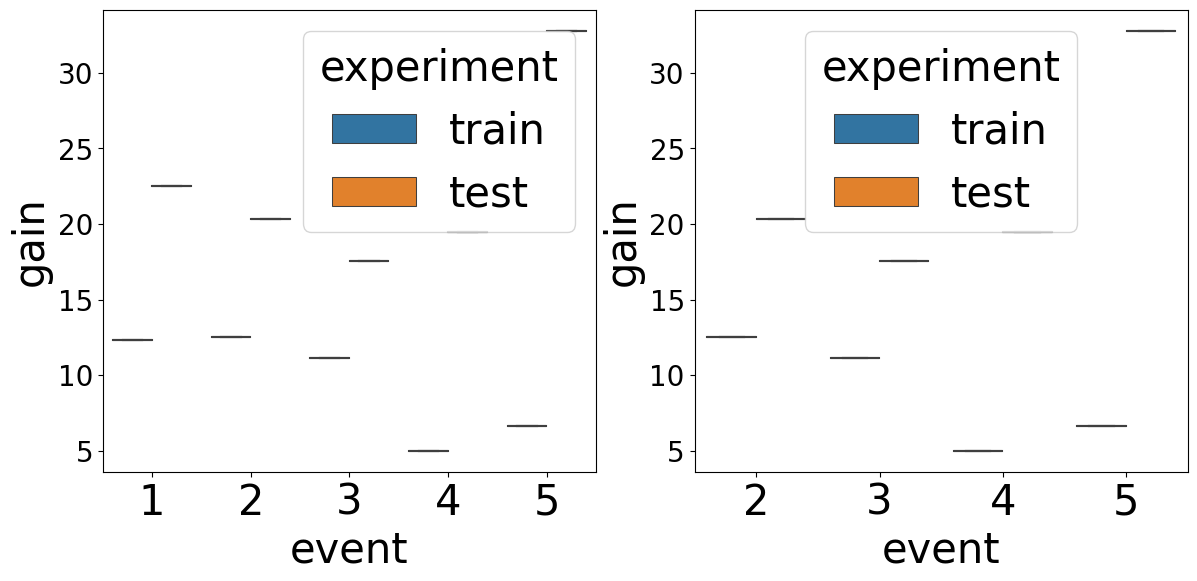

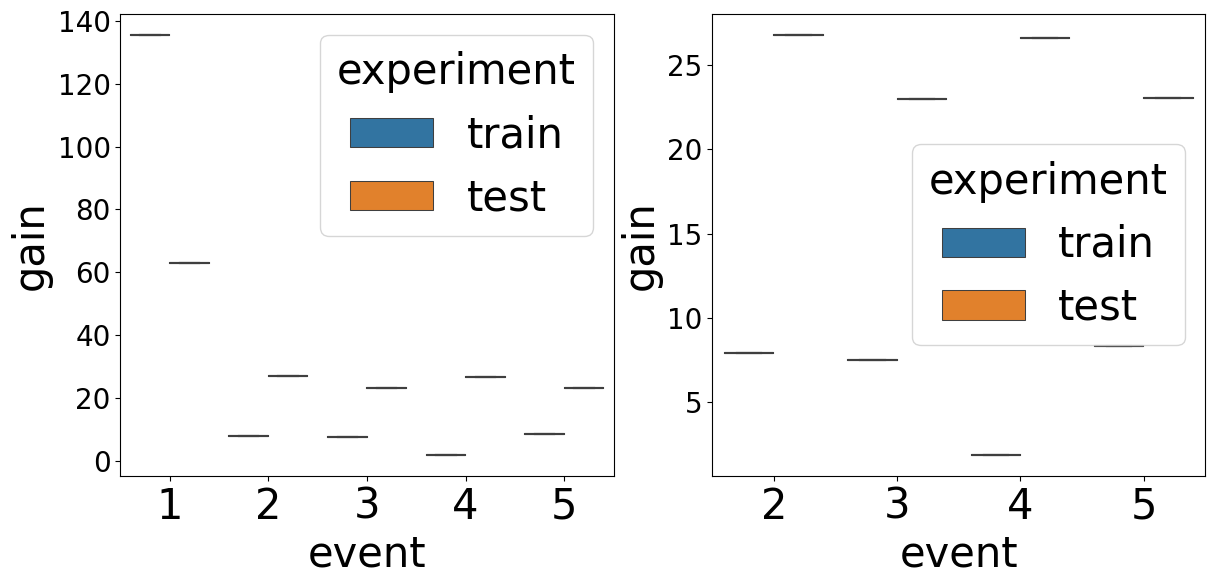

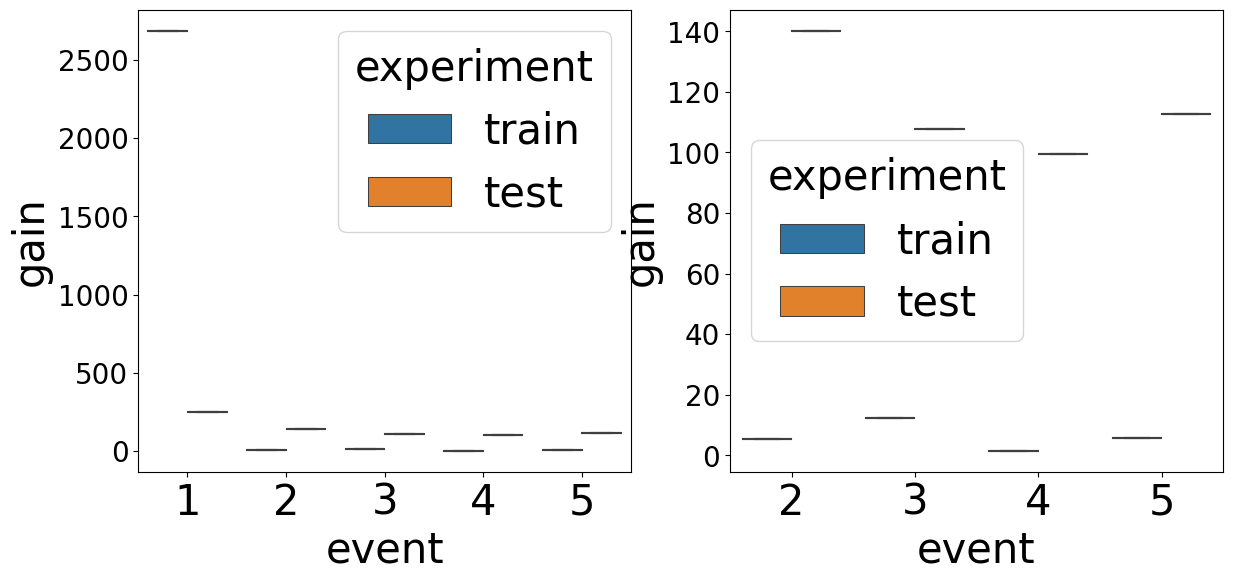

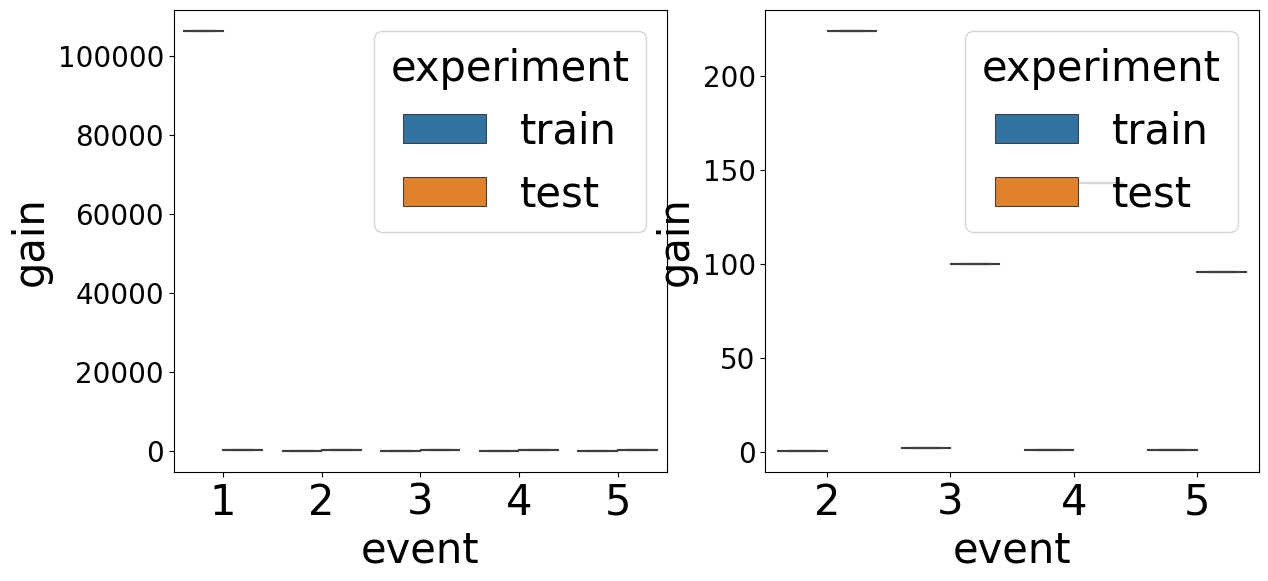

In [53]:
data_train = train_spectrum_peaks
data_test = test_spectrum_peaks

df = pd.DataFrame()
df = df.assign(event=np.append(np.arange(1, 6), np.arange(1, 6)))
df = df.assign(gain=np.append(data_train, data_test))
df = df.assign(experiment=["train"]*5+["test"]*5)

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x='event', y='gain', data=df, ax=ax1, hue='experiment')
sns.boxplot(x='event', y='gain', data=df[df.event!=1], ax=ax2, hue='experiment')
plt.show()

data_train = train_bispectrum_peaks
data_test = test_bispectrum_peaks

df = pd.DataFrame()
df = df.assign(event=np.append(np.arange(1, 6), np.arange(1, 6)))
df = df.assign(gain=np.append(data_train, data_test))
df = df.assign(experiment=["train"]*5+["test"]*5)

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x='event', y='gain', data=df, ax=ax1, hue='experiment')
sns.boxplot(x='event', y='gain', data=df[df.event!=1], ax=ax2, hue='experiment')
plt.show()

data_train = train_trispectrum_peaks
data_test = test_trispectrum_peaks

df = pd.DataFrame()
df = df.assign(event=np.append(np.arange(1, 6), np.arange(1, 6)))
df = df.assign(gain=np.append(data_train, data_test))
df = df.assign(experiment=["train"]*5+["test"]*5)

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x='event', y='gain', data=df, ax=ax1, hue='experiment')
sns.boxplot(x='event', y='gain', data=df[df.event!=1], ax=ax2, hue='experiment')
plt.show()

data_train = train_quadrispectrum_peaks
data_test = test_quadrispectrum_peaks

df = pd.DataFrame()
df = df.assign(event=np.append(np.arange(1, 6), np.arange(1, 6)))
df = df.assign(gain=np.append(data_train, data_test))
df = df.assign(experiment=["train"]*5+["test"]*5)

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x='event', y='gain', data=df, ax=ax1, hue='experiment')
sns.boxplot(x='event', y='gain', data=df[df.event!=1], ax=ax2, hue='experiment')
plt.show()

In [54]:
train_spectrum_peaks = [
    hosa_train.loc[
        (hosa_train.frequency>=53.70)&(hosa_train.frequency<=53.72), 
        plots_dict["Spectrum"][pn]
    ].max() for pn in range(5)
]

test_spectrum_peaks = [
    hosa_test.loc[
        (hosa_test.frequency>=53.70)&(hosa_test.frequency<=53.72), 
        plots_dict["Spectrum"][pn]
    ].max() for pn in range(5)
]

t_statistic, p_value = stats.ttest_ind(train_spectrum_peaks[1:], test_spectrum_peaks, equal_var=False)
logger.info(f"Spectrum: Statistic: {t_statistic}, p-value: {p_value}")

train_bispectrum_peaks = [
    hosa_train.loc[
        (hosa_train.frequency>=53.70)&(hosa_train.frequency<=53.72),
        plots_dict["Bispectrum"][pn]
    ].max() for pn in range(5)
]

test_bispectrum_peaks = [
    hosa_test.loc[
        (hosa_test.frequency>=53.70)&(hosa_test.frequency<=53.72),
        plots_dict["Bispectrum"][pn]
    ].max() for pn in range(5)
]

t_statistic, p_value = stats.ttest_ind(train_bispectrum_peaks[1:], test_bispectrum_peaks, equal_var=False)
logger.info(f"Bispectrum: Statistic: {t_statistic}, p-value: {p_value}")

train_trispectrum_peaks = [
    hosa_train.loc[
        (hosa_train.frequency>=53.70)&(hosa_train.frequency<=53.72),
        plots_dict["Trispectrum"][pn]
    ].max() for pn in range(5)
]

test_trispectrum_peaks = [
    hosa_test.loc[
        (hosa_test.frequency>=53.70)&(hosa_test.frequency<=53.72),
        plots_dict["Trispectrum"][pn]
    ].max() for pn in range(5)
]

t_statistic, p_value = stats.ttest_ind(train_trispectrum_peaks[1:], test_trispectrum_peaks, equal_var=False)
logger.info(f"Trispectrum: Statistic: {t_statistic}, p-value: {p_value}")

train_quadrispectrum_peaks = [
    hosa_train.loc[
        (hosa_train.frequency>=53.70)&(hosa_train.frequency<=53.72),
        plots_dict["Quadrispectrum"][pn]
    ].max() for pn in range(5)
]

test_quadrispectrum_peaks = [
    hosa_test.loc[
        (hosa_test.frequency>=53.70)&(hosa_test.frequency<=53.72),
        plots_dict["Quadrispectrum"][pn]
    ].max() for pn in range(5)
]

t_statistic, p_value = stats.ttest_ind(train_quadrispectrum_peaks[1:], test_quadrispectrum_peaks, equal_var=False)
logger.info(f"Quadrispectrum: Statistic: {t_statistic}, p-value: {p_value}")

2023-05-11 21:15:07.363 | INFO     | __main__:<module>:16 - Spectrum: Statistic: -2.6623797557033817, p-value: 0.03261433395713238
2023-05-11 21:15:07.368 | INFO     | __main__:<module>:33 - Bispectrum: Statistic: -2.5508987846662925, p-value: 0.06257029554510679
2023-05-11 21:15:07.372 | INFO     | __main__:<module>:50 - Trispectrum: Statistic: -2.4601701471629056, p-value: 0.0696568707914272
2023-05-11 21:15:07.376 | INFO     | __main__:<module>:67 - Quadrispectrum: Statistic: -1.4507892843972217, p-value: 0.22044641739478352


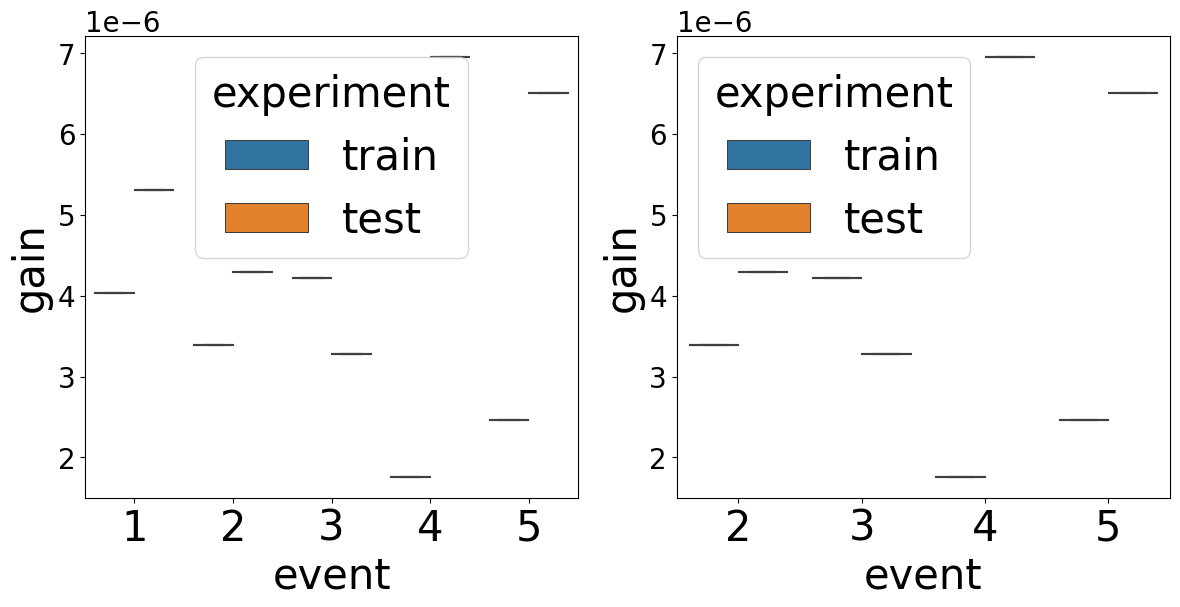

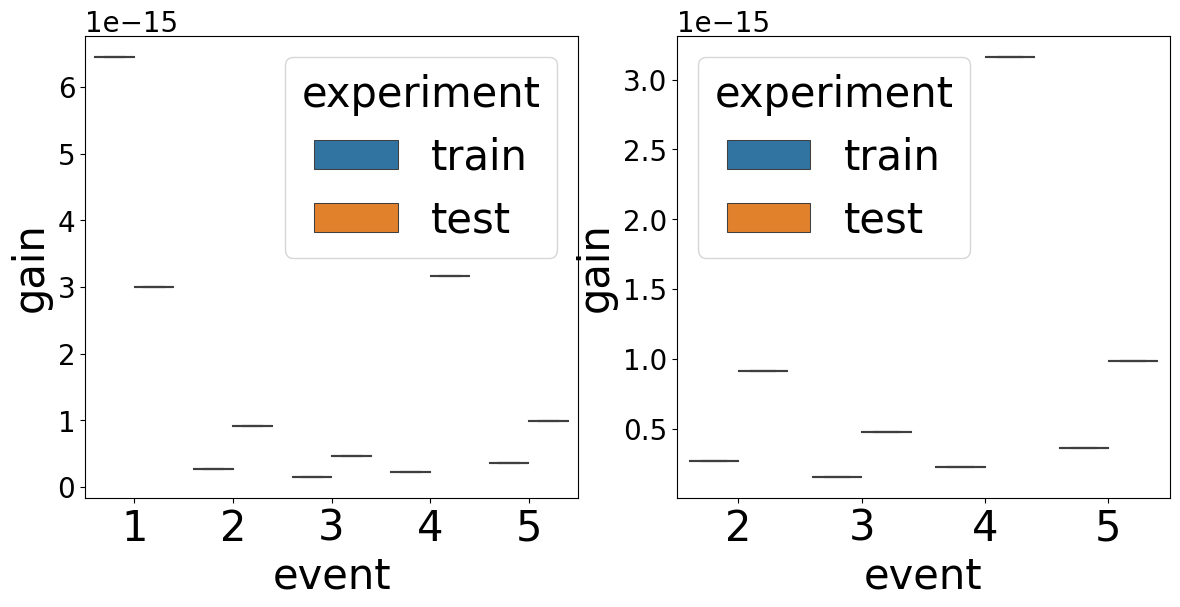

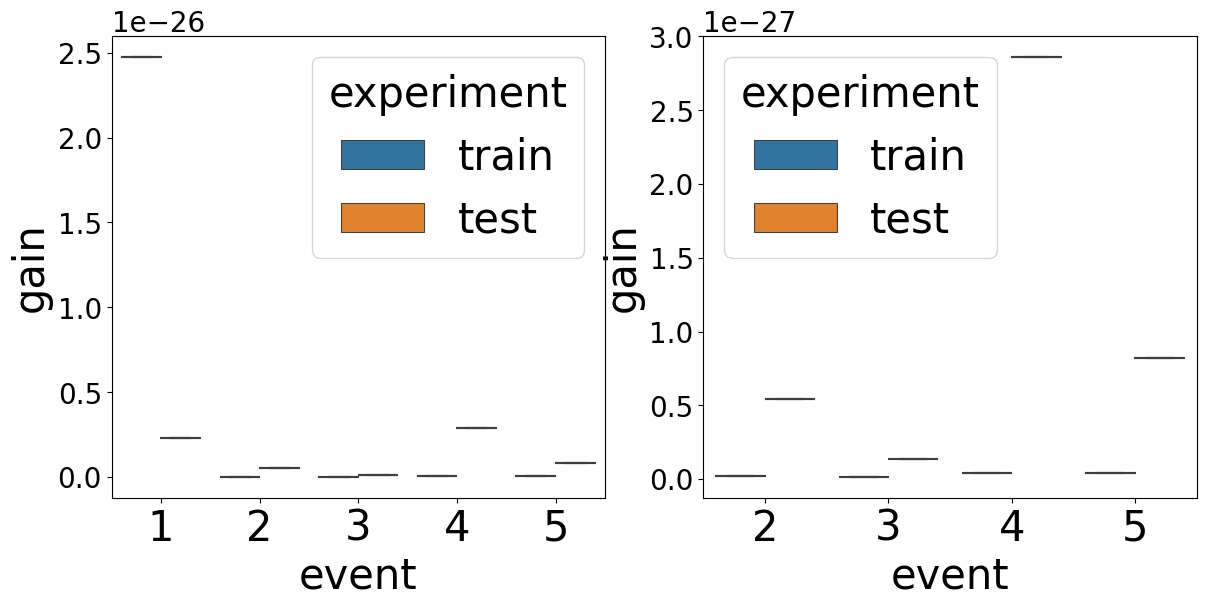

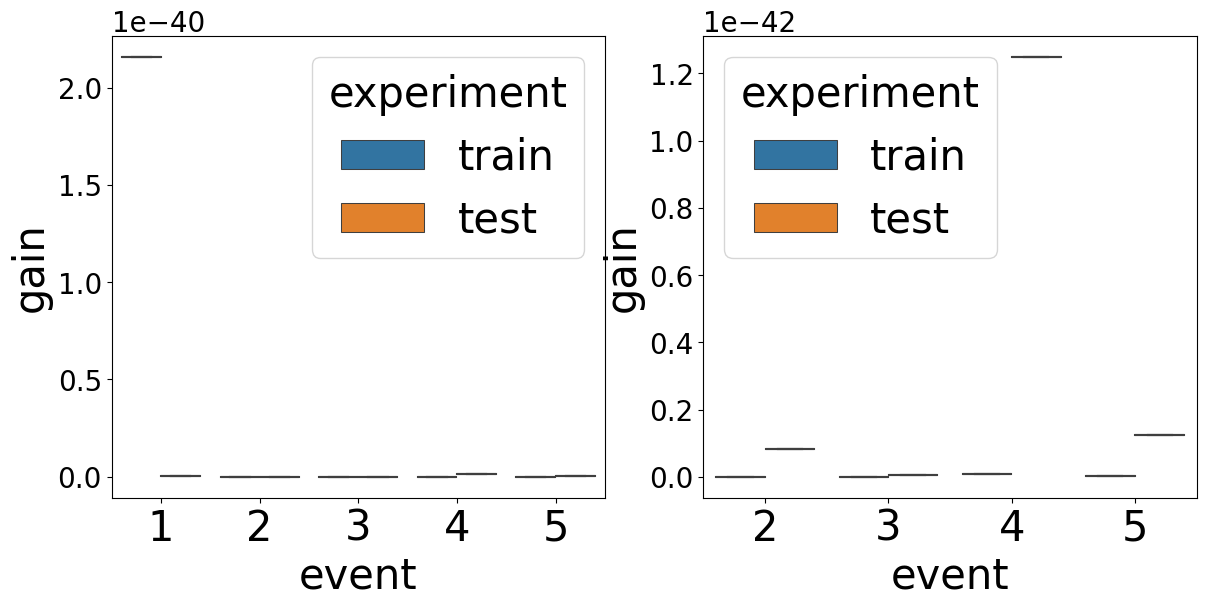

In [55]:
data_train = train_spectrum_peaks
data_test = test_spectrum_peaks

df = pd.DataFrame()
df = df.assign(event=np.append(np.arange(1, 6), np.arange(1, 6)))
df = df.assign(gain=np.append(data_train, data_test))
df = df.assign(experiment=["train"]*5+["test"]*5)

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x='event', y='gain', data=df, ax=ax1, hue='experiment')
sns.boxplot(x='event', y='gain', data=df[df.event!=1], ax=ax2, hue='experiment')
plt.show()

data_train = train_bispectrum_peaks
data_test = test_bispectrum_peaks

df = pd.DataFrame()
df = df.assign(event=np.append(np.arange(1, 6), np.arange(1, 6)))
df = df.assign(gain=np.append(data_train, data_test))
df = df.assign(experiment=["train"]*5+["test"]*5)

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x='event', y='gain', data=df, ax=ax1, hue='experiment')
sns.boxplot(x='event', y='gain', data=df[df.event!=1], ax=ax2, hue='experiment')
plt.show()

data_train = train_trispectrum_peaks
data_test = test_trispectrum_peaks

df = pd.DataFrame()
df = df.assign(event=np.append(np.arange(1, 6), np.arange(1, 6)))
df = df.assign(gain=np.append(data_train, data_test))
df = df.assign(experiment=["train"]*5+["test"]*5)

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x='event', y='gain', data=df, ax=ax1, hue='experiment')
sns.boxplot(x='event', y='gain', data=df[df.event!=1], ax=ax2, hue='experiment')
plt.show()

data_train = train_quadrispectrum_peaks
data_test = test_quadrispectrum_peaks

df = pd.DataFrame()
df = df.assign(event=np.append(np.arange(1, 6), np.arange(1, 6)))
df = df.assign(gain=np.append(data_train, data_test))
df = df.assign(experiment=["train"]*5+["test"]*5)

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x='event', y='gain', data=df, ax=ax1, hue='experiment')
sns.boxplot(x='event', y='gain', data=df[df.event!=1], ax=ax2, hue='experiment')
plt.show()

# MPC

In [56]:
class PolarPlotPhasors:
    @classmethod
    def create_polar_plot(cls, figsize=(14,10), grid=True, ticks=True):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='polar')
        ax.set_yticklabels([])
        plt.grid(grid)
        if ticks:
            plt.xticks(
                [
                    0, 
                    0.25*np.pi, 
                    0.5*np.pi,
                    0.75*np.pi, 
                    np.pi, 
                    1.25*np.pi, 
                    1.5*np.pi, 
                    1.75*np.pi
                ], 
                [
                    "0", 
                    "$\\frac{\pi}{4}$",
                    "$\\frac{\pi}{2}$",
                    "$\\frac{3 \pi}{4}$",
                    "$\pi$",
                    "$\\frac{5\pi}{4}$",
                    "$\\frac{3\pi}{2}$",
                    "$\\frac{7\pi}{4}$"
                ],
                fontsize=20
            )
        else:
            plt.xticks([])
        ax.set_theta_zero_location('E')
        ax.set_ylim([0, 1])
        return ax
    
    @classmethod
    def add_angle_polar(cls, ax, angle, gain=1, color="gray", linewidth=1):
        ax.plot([0, angle], [0, gain], color=color, linewidth=linewidth)
        return ax
    
    @classmethod
    def plot_array_angles_colored(cls, angles, gains, color="gray", linewidth=1, grid=False, ticks=True):
        ax = cls.create_polar_plot(grid=grid, ticks=ticks)
        for angle, gain in zip(angles, gains):
            ax = cls.add_angle_polar(ax, angle, gain, color, linewidth)
        return ax
    
    @classmethod
    def add_vector_polar(cls, ax, angle, module, color, linewidth):
        ax.plot([0, angle], [0, module], color=color, linewidth=linewidth)
        return ax
    
    @classmethod
    def plot_two_array_angles(cls, angles1, angles2, color1="gray", color2="blue", linewidth=1, grid=False, ticks=True):
        ax = cls.create_polar_plot(grid=grid, ticks=ticks)

        new_angles = np.zeros((4,len(angles)))
        modules = np.zeros((4,len(angles)))

        new_angles[1, :] = new_angles[2, :] = angles
        new_angles = new_angles.T.reshape(-1)

        modules[1:3, :] = 1
        modules = modules.T.reshape(-1)

        ax.plot(new_angles, modules, color=color, linewidth=linewidth)

        return ax
    
    @classmethod
    def plot_array_angles(cls, angles, modules_phasors=None, color="gray", linewidth=1, grid=False, ticks=True):

        gains = 1 if modules_phasors is None else modules_phasors
        
        ax = cls.create_polar_plot(grid=grid, ticks=ticks)

        new_angles = np.zeros((2,len(angles)))
        modules = np.zeros((2,len(angles)))

        new_angles[1, :] = angles
        new_angles = new_angles.T.reshape(-1)

        modules[1, :] = gains
        modules = modules.T.reshape(-1)

        ax.plot(new_angles, modules, color=color, linewidth=linewidth)
        
        del new_angles
        del modules
        del gains

        return ax

In [57]:
def get_MPC(
    signal1, 
    signal2,
    signal1_name: str = "signal_1",
    signal2_name: str = "signal_2",
    sliding_window: bool = False,
    sliding_window_size: float = 3.0,
    TimeSampling: float = None,
    plot: bool = True,
    save: bool = False,
    name_to_save: str = "fig.eps",
    legend_size=15,
    dpi=100,
    ticks=True
):
    
    if not sliding_window:
        
        analytic_signal_1 = hilbert(signal1)
        phase_data_signal_1 = np.unwrap(np.angle(analytic_signal_1))

        analytic_signal_2 = hilbert(signal2)
        phase_data_signal_2 = np.unwrap(np.angle(analytic_signal_2))

        phase_angle_diff = phase_data_signal_1 - phase_data_signal_2

        euler_phase_diff = np.exp(1j*phase_angle_diff)

        mean_phase_diff = np.mean(euler_phase_diff)

        phase_sync = np.abs(mean_phase_diff)
        
        phase_angle = np.angle(mean_phase_diff)

        print(f"The synchronization between {signal1_name} and {signal2_name} is {np.round(phase_sync, 4)}")
        print(f"The mean angle between {signal1_name} and {signal2_name} is {np.round(phase_angle, 2)} rad")
         
    else:
        if TimeSampling is None:
            raise ValueError("TimeSampling must be passed as float.")

        # Mean synchronization using sliding window with 90% time overlap
        N = len(signal1)
        step = int(0.1*(sliding_window_size/TimeSampling))
        number_of_windows_overlap = int((sliding_window_size/TimeSampling)//step)
        start_window = np.arange(0, N, step).astype(int)
        end_window = (start_window + int(sliding_window_size/TimeSampling)).astype(int)
        end_window[-1] = N - 1

        clustering_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)
        mean_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)

        for i in range(number_of_windows_overlap):
            signal1_data = signal1[start_window[i]:end_window[i]]
            signal2_data = signal2[start_window[i]:end_window[i]]
            analytic_signal1 = hilbert(signal1_data)
            analytic_signal2 = hilbert(signal2_data)
            phase_data_signal1 = np.unwrap(np.angle(analytic_signal1))
            phase_data_signal2 = np.unwrap(np.angle(analytic_signal2))
            phase_angle_diff = phase_data_signal1 - phase_data_signal2
            euler_phase_diff = np.exp(1j*phase_angle_diff)
            mean_phase_diff = np.mean(euler_phase_diff)
            phase_sync = np.abs(mean_phase_diff)
            clustering_phase_array[i] = phase_sync
            mean_phase_array[i] = np.angle(mean_phase_diff)

        phase_sync = clustering_phase_array
        phase_angle = mean_phase_array
        
        mean_phase_sync = clustering_phase_array.mean()
        mean_phase_angle = np.angle(np.mean(np.exp(1j*mean_phase_array)))
                
        print(f"The mean synchronization between {signal1_name} and {signal2_name} is {np.round(mean_phase_sync, 4)}")
        print(f"The mean angle between {signal1_name} and {signal2_name} is {np.round(mean_phase_angle, 2)} rad")
        
    if plot:
        
        ax = PolarPlotPhasors.plot_array_angles(
            phase_angle_diff if not sliding_window else phase_angle, 
            color=None, 
            linewidth=0.5,
            modules_phasors=phase_sync if sliding_window else None,
            ticks=ticks
        )
        
        ax = PolarPlotPhasors.add_vector_polar(
            ax, 
            angle=phase_angle if not sliding_window else mean_phase_angle, 
            module=phase_sync if not sliding_window else mean_phase_sync, 
            linewidth=10, 
            color='red'
        )

#         ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync if not sliding_window else mean_phase_sync, 4)}", fontsize=16)
        if ticks:
            ax.set_xlabel(
                f"{np.round(phase_sync if not sliding_window else mean_phase_sync, 4)}", 
                fontsize=legend_size,
            )
        
        if save:
            if name_to_save == "fig.eps" and os.path.isfile("fig.eps"):
                i = 2
                while os.path.isfile(name_to_save):
                    name_to_save =  f"fig_{i}.eps"
                    i += 1
            plt.savefig(
                name_to_save, 
                format=name_to_save.split(".")[-1],
                bbox_inches='tight', 
                dpi=dpi
            )
        
        plt.show()
        
    ax.clear()
        
    del analytic_signal_1
    del phase_data_signal_1
    del analytic_signal_2
    del phase_data_signal_2
    del phase_angle_diff
    del euler_phase_diff
    del mean_phase_diff
    del ax
        
    return phase_sync, phase_angle

In [58]:
data_train = data_train_backup
data_test = data_test_backup

2023-05-11 21:15:08.797 | INFO     | __main__:<module>:22 - MPC - Train Data - Event 1


The synchronization between CS and IC is 0.5584
The mean angle between CS and IC is -1.61 rad


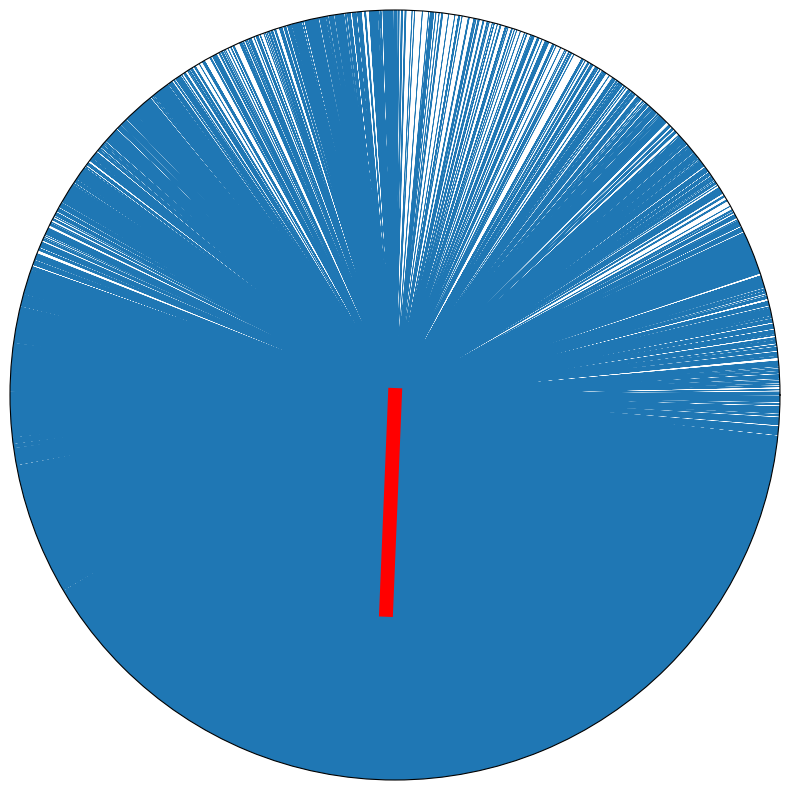

2023-05-11 21:15:12.519 | SUCCESS  | __main__:<module>:95 - DONE: train Data - Event 1
2023-05-11 21:15:12.523 | INFO     | __main__:<module>:22 - MPC - Train Data - Event 2


The synchronization between CS and IC is 0.4677
The mean angle between CS and IC is -2.26 rad


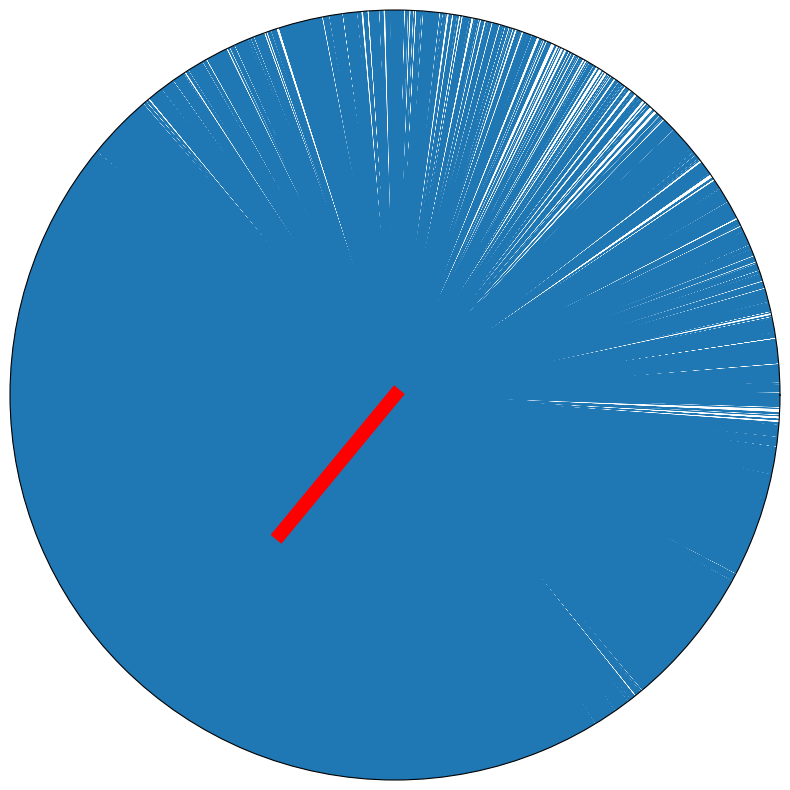

2023-05-11 21:15:16.683 | SUCCESS  | __main__:<module>:95 - DONE: train Data - Event 2
2023-05-11 21:15:16.686 | INFO     | __main__:<module>:22 - MPC - Train Data - Event 3


The synchronization between CS and IC is 0.5973
The mean angle between CS and IC is -1.53 rad


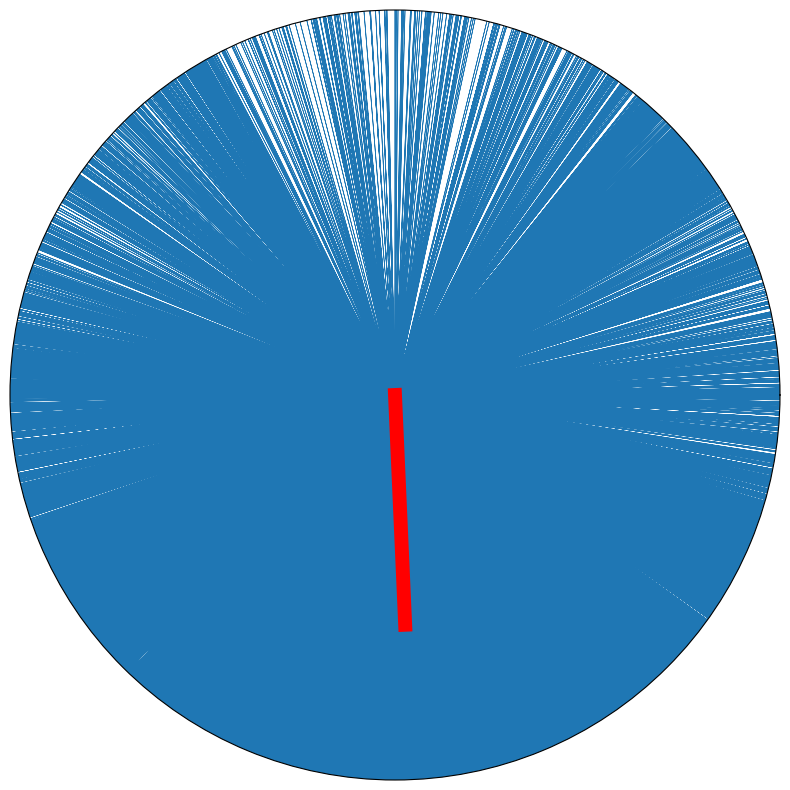

2023-05-11 21:15:21.033 | SUCCESS  | __main__:<module>:95 - DONE: train Data - Event 3
2023-05-11 21:15:21.037 | INFO     | __main__:<module>:22 - MPC - Train Data - Event 4


The synchronization between CS and IC is 0.2413
The mean angle between CS and IC is -1.0 rad


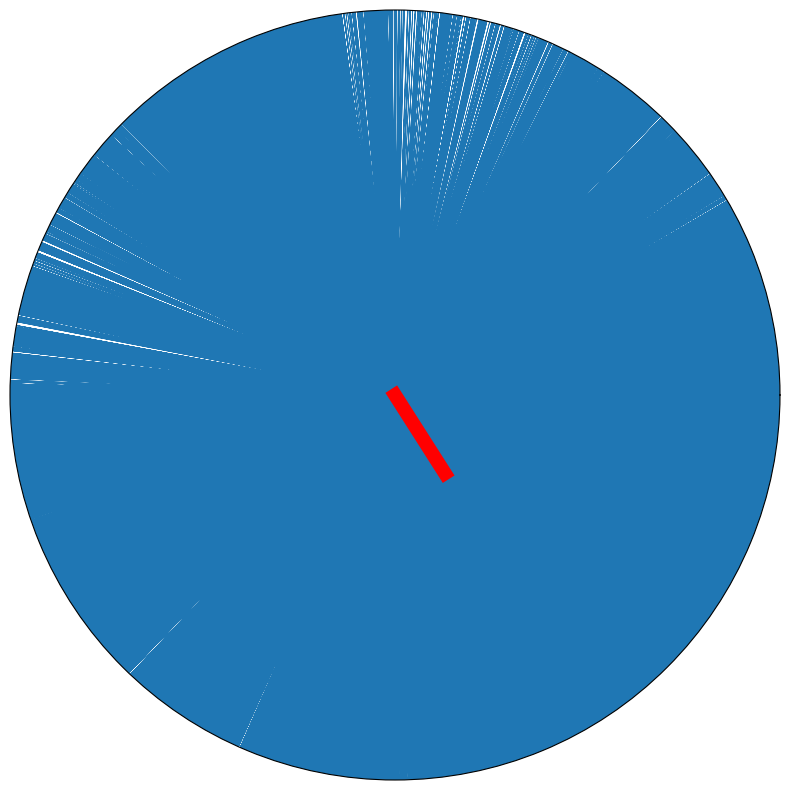

2023-05-11 21:15:24.645 | SUCCESS  | __main__:<module>:95 - DONE: train Data - Event 4
2023-05-11 21:15:24.648 | INFO     | __main__:<module>:22 - MPC - Train Data - Event 5


The synchronization between CS and IC is 0.4361
The mean angle between CS and IC is -1.42 rad


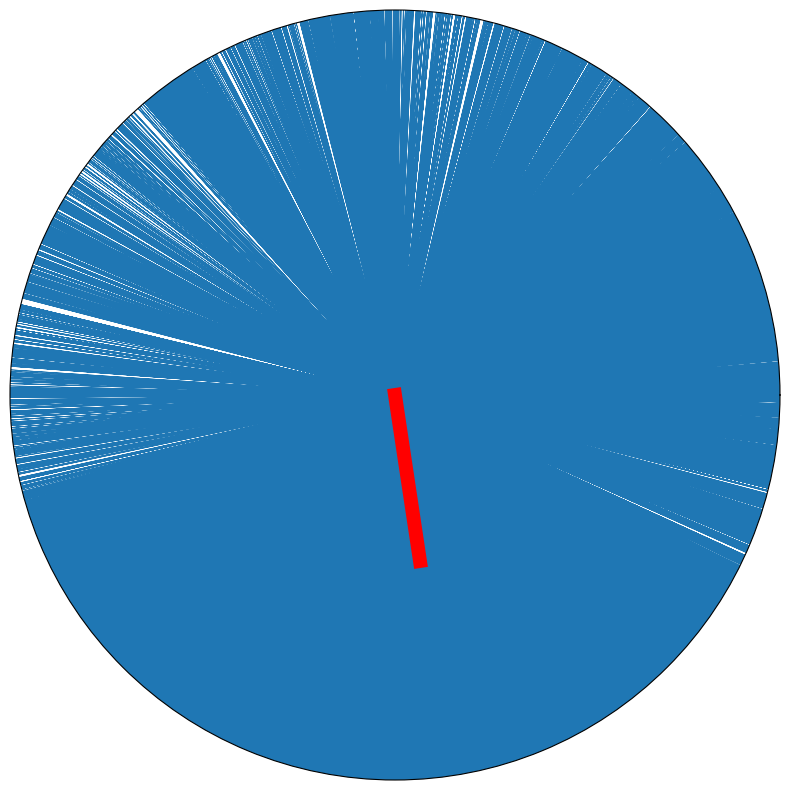

2023-05-11 21:15:28.952 | SUCCESS  | __main__:<module>:95 - DONE: train Data - Event 5


In [59]:
sliding_window_size = 3.0
extension_to_save_files = "jpg"
legend_size = 50

run_MPC_over_time: bool = False
run_MPC_sliding_window: bool = False
procces_raw_data: bool = False

name_data = "train"
data = data_train

for event_number in range(1, 6):
    column = "filtered_Inferior_colliculus"

    event_data = select_event_window(
        df=data, 
        event_name=f"event_{event_number}", 
        samples_before=0, 
        samples_after=0
    )

    logger.info(f'MPC - {name_data.capitalize()} Data - Event {event_number}')

    phase_sync, phase_angle = get_MPC(
        signal1 = event_data.CS_modulating, 
        signal2 = event_data.loc[:, column],
        signal1_name = "CS",
        signal2_name = "IC",
        sliding_window = False,
        sliding_window_size = sliding_window_size,
        TimeSampling = TimeSampling,
        save=True,
        name_to_save=f'MPC_{name_data}_event_{event_number}' + \
        f'.{extension_to_save_files}',
        legend_size=legend_size,
        ticks=False
    )

    if run_MPC_sliding_window:
        logger.info(f'Sliding MPC polar - {name_data.capitalize()} Data - Event {event_number}')

        phase_sync_array, phase_angle_array = get_MPC(
            signal1 = event_data.CS_modulating, 
            signal2 = event_data.loc[:, column],
            signal1_name = "CS",
            signal2_name = "IC",
            sliding_window = True,
            sliding_window_size = sliding_window_size,
            TimeSampling = TimeSampling,
            save=True,
            name_to_save=f'sliding_MPC_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            legend_size=legend_size,
            ticks=False
        )

    if run_MPC_over_time:
        logger.info(f'sliding MPC over time - {name_data.capitalize()} Data - Event {event_number}')

        plt.figure(figsize=(14,10))

        t = 0
        for MPC in phase_sync_array:
            plt.plot([t, t, t + sliding_window_size, t + sliding_window_size], [0, MPC, MPC, 0])
            t += sliding_window_size

        plt.xlabel("time [s]")
        plt.ylabel('Mean Phase Clustering')
        plt.ylim([0, 1])
        plt.savefig(
            f'sliding_MPC_over_time_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            format="extension_to_save_files"
        )

        plt.show()

        frequency, intensity, angle = fft(x=event_data.loc[:, column].to_numpy(), fs=FrequencySampling)

        plt.figure(figsize=(14,10))

        plt.plot(frequency, intensity)

        plt.xlabel("frequency [Hz]")
        plt.ylabel('Intensity FFT')
        plt.xlim([50, 60])
        plt.savefig(
            f'FFT_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            format="extension_to_save_files"
        )

        plt.show()

    logger.success(f'DONE: {name_data} Data - Event {event_number}')

2023-05-11 21:15:28.965 | INFO     | __main__:<module>:22 - MPC - Test Data - Event 1


The synchronization between CS and IC is 0.8841
The mean angle between CS and IC is 0.58 rad


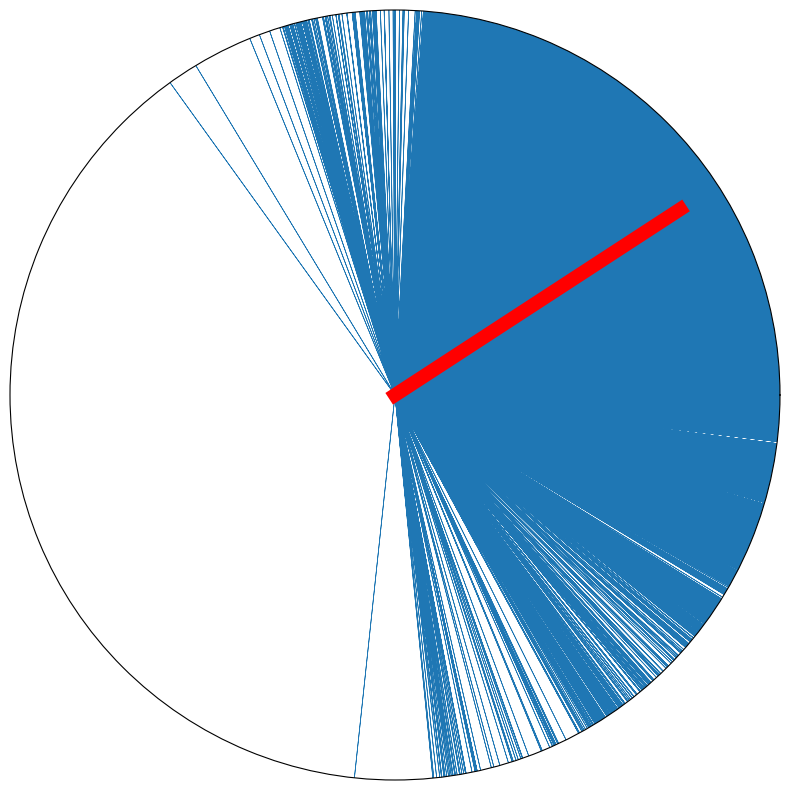

2023-05-11 21:15:33.280 | SUCCESS  | __main__:<module>:95 - DONE: test Data - Event 1
2023-05-11 21:15:33.283 | INFO     | __main__:<module>:22 - MPC - Test Data - Event 2


The synchronization between CS and IC is 0.8023
The mean angle between CS and IC is 1.22 rad


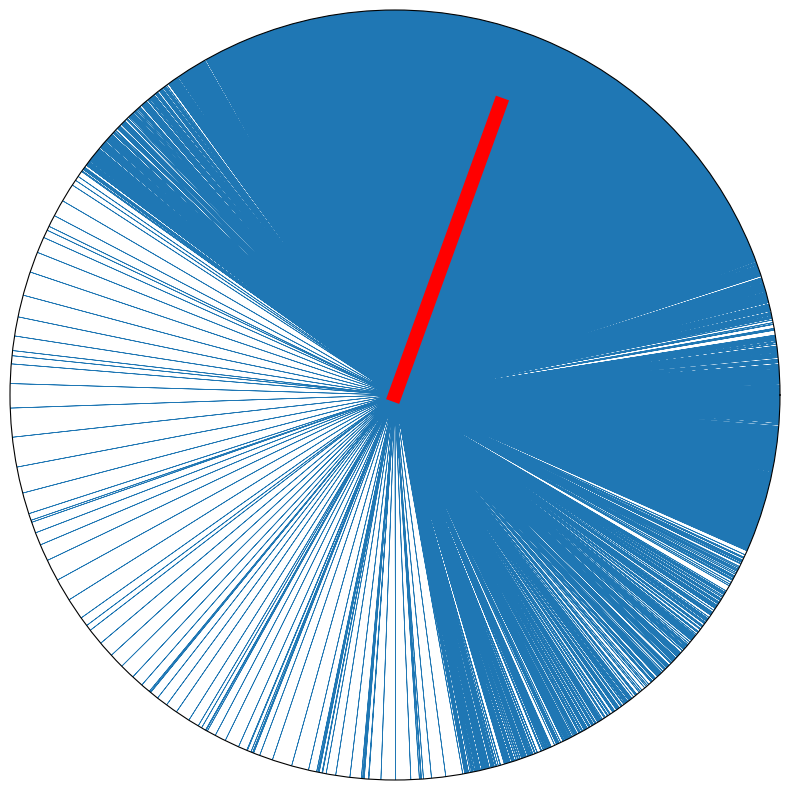

2023-05-11 21:15:37.761 | SUCCESS  | __main__:<module>:95 - DONE: test Data - Event 2
2023-05-11 21:15:37.765 | INFO     | __main__:<module>:22 - MPC - Test Data - Event 3


The synchronization between CS and IC is 0.8005
The mean angle between CS and IC is 2.45 rad


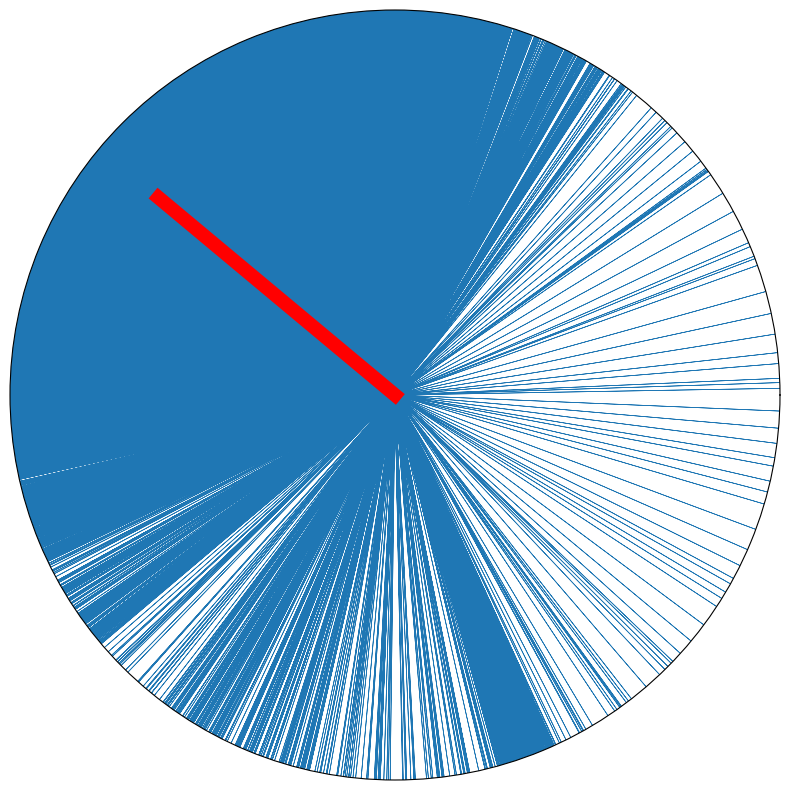

2023-05-11 21:15:41.874 | SUCCESS  | __main__:<module>:95 - DONE: test Data - Event 3
2023-05-11 21:15:41.877 | INFO     | __main__:<module>:22 - MPC - Test Data - Event 4


The synchronization between CS and IC is 0.8901
The mean angle between CS and IC is 2.38 rad


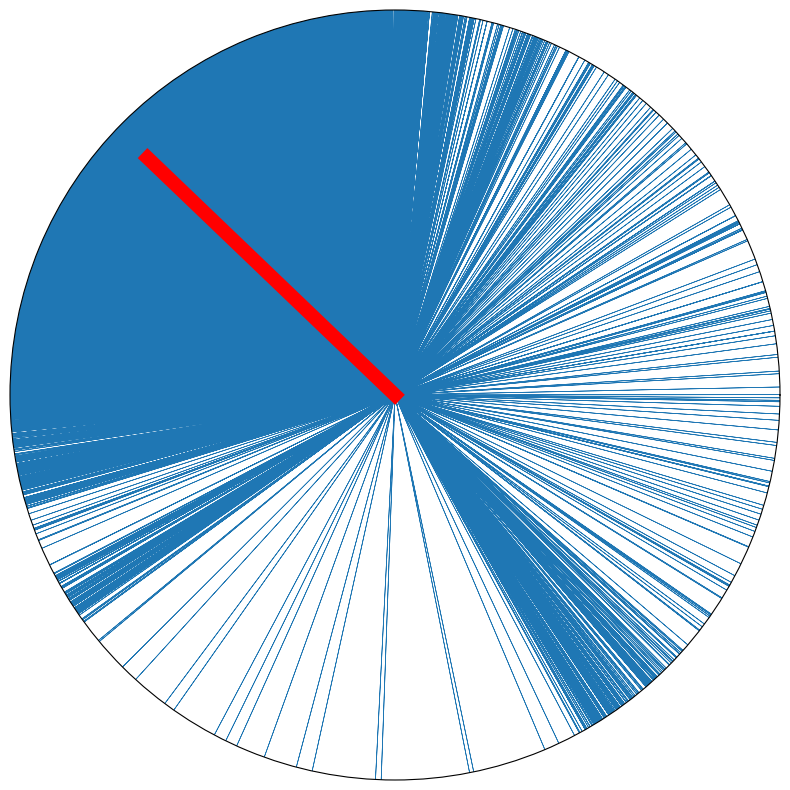

2023-05-11 21:15:46.797 | SUCCESS  | __main__:<module>:95 - DONE: test Data - Event 4
2023-05-11 21:15:46.801 | INFO     | __main__:<module>:22 - MPC - Test Data - Event 5


The synchronization between CS and IC is 0.8977
The mean angle between CS and IC is 2.66 rad


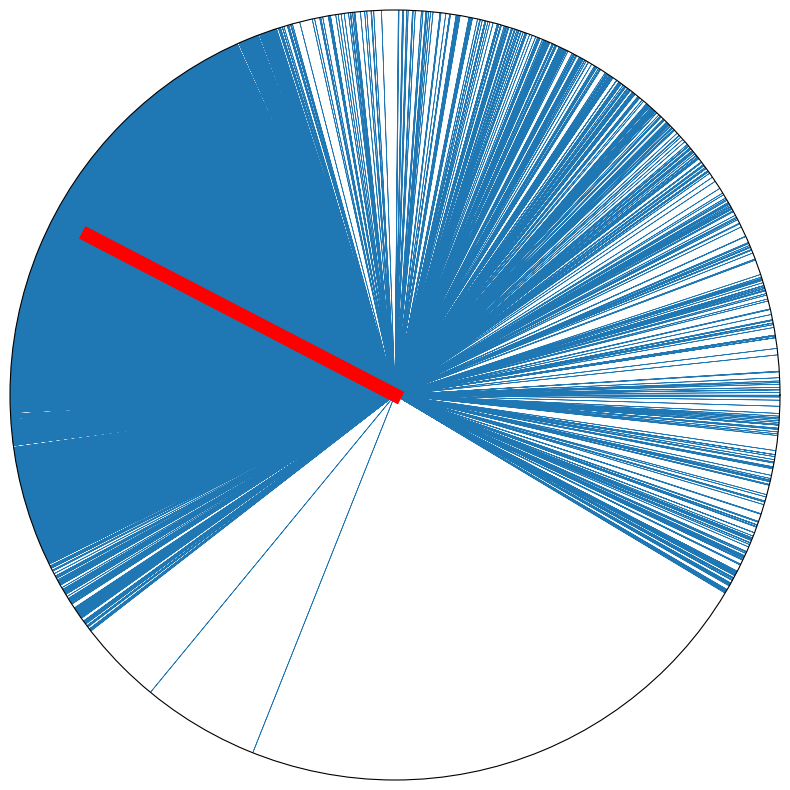

2023-05-11 21:15:51.220 | SUCCESS  | __main__:<module>:95 - DONE: test Data - Event 5


In [60]:
sliding_window_size = 3.0
extension_to_save_files = "jpg"
legend_size = 50

run_MPC_over_time: bool = False
run_MPC_sliding_window: bool = False
procces_raw_data: bool = False

name_data = "test"
data = data_test

for event_number in range(1, 6):
    column = "filtered_Inferior_colliculus"

    event_data = select_event_window(
        df=data, 
        event_name=f"event_{event_number}", 
        samples_before=0, 
        samples_after=0
    )

    logger.info(f'MPC - {name_data.capitalize()} Data - Event {event_number}')

    phase_sync, phase_angle = get_MPC(
        signal1 = event_data.CS_modulating, 
        signal2 = event_data.loc[:, column],
        signal1_name = "CS",
        signal2_name = "IC",
        sliding_window = False,
        sliding_window_size = sliding_window_size,
        TimeSampling = TimeSampling,
        save=True,
        name_to_save=f'MPC_{name_data}_event_{event_number}' + \
        f'.{extension_to_save_files}',
        legend_size=legend_size,
        ticks=False
    )

    if run_MPC_sliding_window:
        logger.info(f'Sliding MPC polar - {name_data.capitalize()} Data - Event {event_number}')

        phase_sync_array, phase_angle_array = get_MPC(
            signal1 = event_data.CS_modulating, 
            signal2 = event_data.loc[:, column],
            signal1_name = "CS",
            signal2_name = "IC",
            sliding_window = True,
            sliding_window_size = sliding_window_size,
            TimeSampling = TimeSampling,
            save=True,
            name_to_save=f'sliding_MPC_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            legend_size=legend_size,
            ticks=False
        )

    if run_MPC_over_time:
        logger.info(f'sliding MPC over time - {name_data.capitalize()} Data - Event {event_number}')

        plt.figure(figsize=(14,10))

        t = 0
        for MPC in phase_sync_array:
            plt.plot([t, t, t + sliding_window_size, t + sliding_window_size], [0, MPC, MPC, 0])
            t += sliding_window_size

        plt.xlabel("time [s]")
        plt.ylabel('Mean Phase Clustering')
        plt.ylim([0, 1])
        plt.savefig(
            f'sliding_MPC_over_time_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            format="extension_to_save_files"
        )

        plt.show()

        frequency, intensity, angle = fft(x=event_data.loc[:, column].to_numpy(), fs=FrequencySampling)

        plt.figure(figsize=(14,10))

        plt.plot(frequency, intensity)

        plt.xlabel("frequency [Hz]")
        plt.ylabel('Intensity FFT')
        plt.xlim([50, 60])
        plt.savefig(
            f'FFT_{name_data}_event_{event_number}' + \
            f'.{extension_to_save_files}',
            format="extension_to_save_files"
        )

        plt.show()

    logger.success(f'DONE: {name_data} Data - Event {event_number}')

In [61]:
logger.success("Done")

2023-05-11 21:15:51.223 | SUCCESS  | __main__:<module>:1 - Done
